In [1]:
import os, re
from typing import Optional
import aiofiles

SQL_DIR: str = os.path.join(os.path.abspath("../../"), "sql/commands/com/de/insight2")

class SqlQuery:
    @staticmethod
    async def read_sql(sql_name) -> str:
        try:
            SQL_PATH = os.path.join(SQL_DIR, f'{sql_name}.sql')
            async with aiofiles.open(SQL_PATH, 'r', encoding='utf-8') as file:
                return await file.read()
        except FileNotFoundError:
            print(f"File {SQL_PATH} not found.")
            return ""
        except Exception as e:
            print(f"An error occurred while reading {SQL_PATH}: {e}")
            return ""

In [2]:
!pip install asyncpg
import asyncio
import asyncpg
import pandas as pd

print ("Fetching data...")

async def fetch_data(query: str):
    conn = await asyncpg.connect(
        host=os.environ.get("DB_HOST", "localhost"),
        port=5433,
        user=os.environ.get("DB_USER", "auth_user"),
        password=os.environ.get("DB_PASSWORD", "auth_password"),
        database=os.environ.get("DB_NAME", "auth_db")
    )

    rows = await conn.fetch(query)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(rows, columns=rows[0].keys() if rows else [])
    await conn.close()
    return df

Fetching data...


# -- Detect unexpected volume drops/spikes and logic changes

In [3]:
SQL_NAME = "3_/3_1"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head()

segment_id              segment_name  year month current_volume  \
0         172        Clicked Past Month  2025    12          42865   
1          50    Sent atleast 20 emails  2025    11          17045   
2          94      DO NOT SEND GAMBLING  2025     9          10894   
3         149          Clicked HeyPiggy  2025    10          28230   
4         150  5 days recent engagement  2025    12          37722   

  previous_volume trend_volume  campaigns_alone_count change_status  \
0           30799        36832                      1        STABLE   
1            None        17045                      1        STABLE   
2            None        10894                      1        STABLE   
3            None        28230                      2        STABLE   
4            None        37722                      1        STABLE   

  percent_change investigation_required  
0          39.18     No action required  
1           None     No action required  
2           None     No action required  
3           None     No action required  
4           None     No action required

SEGMENT VOLUME ESTIMATION & VALIDATION ANALYSIS

📋 SAMPLE DATA:
   segment_id              segment_name  year month current_volume  \
0         172        Clicked Past Month  2025    12          42865   
1          50    Sent atleast 20 emails  2025    11          17045   
2          94      DO NOT SEND GAMBLING  2025     9          10894   
3         149          Clicked HeyPiggy  2025    10          28230   
4         150  5 days recent engagement  2025    12          37722   

  previous_volume trend_volume  campaigns_alone_count change_status  \
0           30799        36832                      1        STABLE   
1            None        17045                      1        STABLE   
2            None        10894                      1        STABLE   
3            None        28230                      2        STABLE   
4            None        37722                      1        STABLE   

  percent_change investigation_required  
0          39.18     No action required  
1   

TypeError: DataFrame.nlargest() got an unexpected keyword argument 'key'

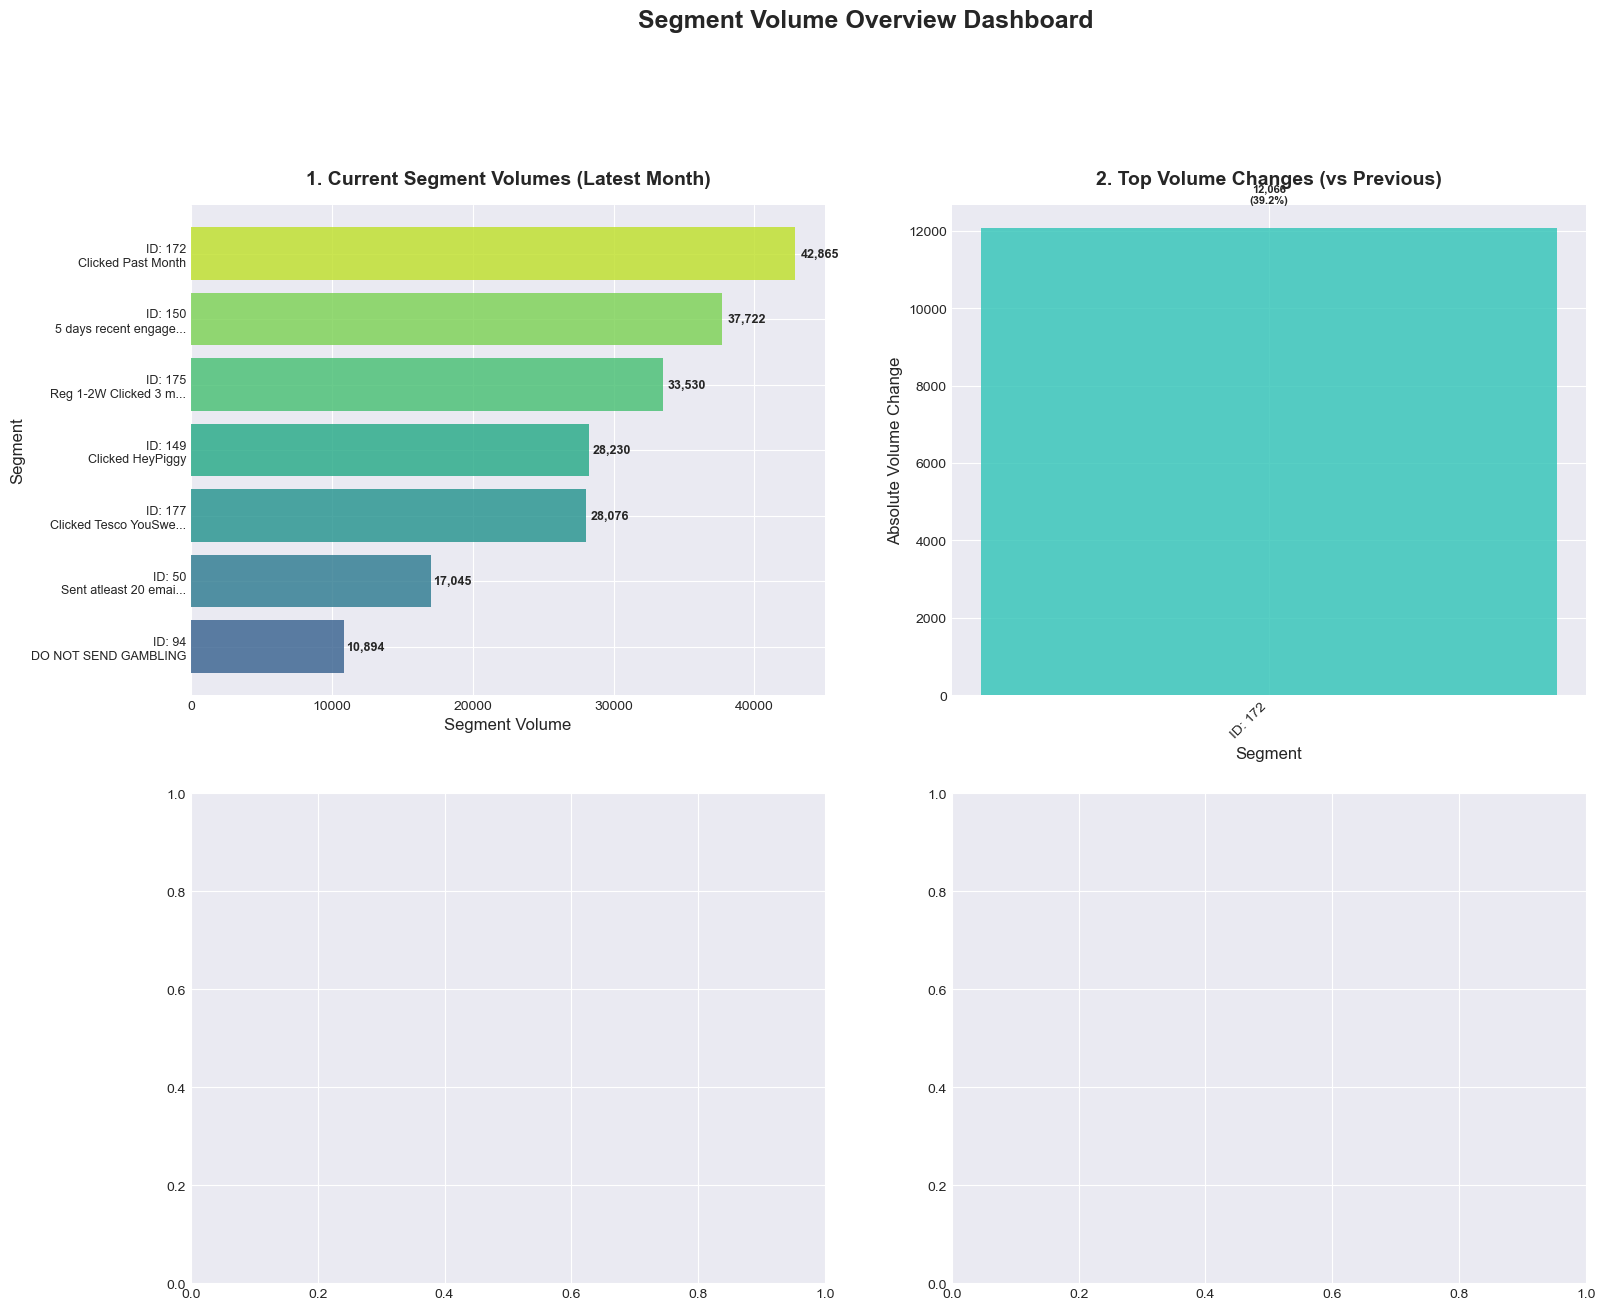

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_volumes(df):
    """
    Comprehensive segment volume estimation and validation analysis
    """
    
    print("=" * 100)
    print("SEGMENT VOLUME ESTIMATION & VALIDATION ANALYSIS")
    print("=" * 100)
    
    # Display first few rows to confirm data structure
    print("\n📋 SAMPLE DATA:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert to numeric where possible
    numeric_cols = ['current_volume', 'previous_volume', 'trend_volume', 
                   'campaigns_alone_count', 'percent_change']
    
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Create datetime column for time series analysis
    df_analysis['date'] = pd.to_datetime(df_analysis['year'].astype(str) + '-' + 
                                         df_analysis['month'].astype(str) + '-01')
    
    # Sort by date
    df_analysis = df_analysis.sort_values('date', ascending=True)
    
    # Calculate basic statistics
    total_segments = df_analysis['segment_id'].nunique()
    total_months = df_analysis['date'].nunique()
    latest_month = df_analysis['date'].max()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Tracked: {total_segments}")
    print(f"   • Time Period: {df_analysis['date'].min().strftime('%b %Y')} to {latest_month.strftime('%b %Y')}")
    print(f"   • Total Observations: {len(df_analysis)}")
    print(f"   • Average Segments per Month: {len(df_analysis)/total_months:.1f}")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Volume Overview Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Volume Overview Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Current Volume Distribution (Top-left)
    ax1 = axes1[0, 0]
    # Sort by current volume for better visualization
    latest_data = df_analysis.sort_values('date', ascending=False).drop_duplicates('segment_id', keep='first')
    latest_data = latest_data.sort_values('current_volume', ascending=True)
    
    # Take top 15 segments if there are many
    if len(latest_data) > 15:
        display_data = latest_data.tail(15)
    else:
        display_data = latest_data
    
    bars1 = ax1.barh(range(len(display_data)), display_data['current_volume'], 
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(display_data))),
                    alpha=0.8)
    
    ax1.set_title('1. Current Segment Volumes (Latest Month)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Segment Volume', fontsize=12)
    ax1.set_ylabel('Segment', fontsize=12)
    ax1.set_yticks(range(len(display_data)))
    
    # Fix: Use proper indexing for the row data
    yticklabels = []
    for _, row in display_data.iterrows():
        segment_name = str(row['segment_name'])
        if len(segment_name) > 20:
            label = f"ID: {row['segment_id']}\n{segment_name[:20]}..."
        else:
            label = f"ID: {row['segment_id']}\n{segment_name}"
        yticklabels.append(label)
    
    ax1.set_yticklabels(yticklabels, fontsize=9)
    
    # Add value labels
    for i, (bar, vol) in enumerate(zip(bars1, display_data['current_volume'])):
        ax1.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                f'{vol:,.0f}', va='center', fontweight='bold', fontsize=9)
    
    # 1.2 Volume Change Analysis (Top-right)
    ax2 = axes1[0, 1]
    
    # Filter segments with previous volume data
    segments_with_change = df_analysis.dropna(subset=['previous_volume'])
    
    if len(segments_with_change) > 0:
        # Calculate absolute and percent changes
        segments_with_change['abs_change'] = segments_with_change['current_volume'] - segments_with_change['previous_volume']
        segments_with_change['pct_change'] = segments_with_change['abs_change'] / segments_with_change['previous_volume'] * 100
        
        # Sort by absolute change for visualization
        top_changes = segments_with_change.nlargest(10, 'abs_change', keep='all')
        
        x_pos = np.arange(len(top_changes))
        colors2 = ['#2EC4B6' if change > 0 else '#FF6B6B' for change in top_changes['abs_change']]
        
        bars2 = ax2.bar(x_pos, top_changes['abs_change'], color=colors2, alpha=0.8)
        
        ax2.set_title('2. Top Volume Changes (vs Previous)', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Segment', fontsize=12)
        ax2.set_ylabel('Absolute Volume Change', fontsize=12)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([f"ID: {id}" for id in top_changes['segment_id']], rotation=45, ha='right')
        
        # Add change labels
        for i, (bar, abs_change, pct_change) in enumerate(zip(bars2, top_changes['abs_change'], top_changes['pct_change'])):
            height = bar.get_height()
            label_y = height + (height * 0.05) if height >= 0 else height - (abs(height) * 0.05)
            ax2.text(bar.get_x() + bar.get_width()/2, label_y,
                    f'{abs_change:,.0f}\n({pct_change:.1f}%)', ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No previous volume data available\nfor change analysis',
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('2. Volume Change Analysis', fontsize=14, fontweight='bold', pad=15)
    
    # 1.3 Volume vs Trend Comparison (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Filter segments with trend volume
    segments_with_trend = df_analysis.dropna(subset=['trend_volume'])
    
    if len(segments_with_trend) > 0:
        # Calculate deviation from trend
        segments_with_trend['deviation'] = ((segments_with_trend['current_volume'] - segments_with_trend['trend_volume']) / 
                                           segments_with_trend['trend_volume'] * 100)
        
        # Sort by absolute deviation
        top_deviations = segments_with_trend.nlargest(10, 'deviation', key=abs, keep='all')
        
        colors3 = ['#2EC4B6' if dev > 0 else '#FF6B6B' for dev in top_deviations['deviation']]
        
        bars3 = ax3.bar(range(len(top_deviations)), top_deviations['deviation'], color=colors3, alpha=0.8)
        
        ax3.axhline(y=0, color='black', linewidth=1)
        ax3.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='+20% Threshold')
        ax3.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='-20% Threshold')
        
        ax3.set_title('3. Deviation from Trend Volume (%)', fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Segment', fontsize=12)
        ax3.set_ylabel('Deviation from Trend (%)', fontsize=12)
        ax3.set_xticks(range(len(top_deviations)))
        ax3.set_xticklabels([f"ID: {id}" for id in top_deviations['segment_id']], rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Add deviation labels
        for i, (bar, dev) in enumerate(zip(bars3, top_deviations['deviation'])):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if dev > 0 else -5),
                    f'{dev:.1f}%', ha='center', va='bottom' if dev > 0 else 'top',
                    fontweight='bold', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'No trend volume data available',
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('3. Trend Deviation Analysis', fontsize=14, fontweight='bold', pad=15)
    
    # 1.4 Investigation Status (Bottom-right)
    ax4 = axes1[1, 1]
    
    if 'investigation_required' in df_analysis.columns:
        investigation_counts = df_analysis['investigation_required'].value_counts()
        
        if len(investigation_counts) > 0:
            # Create donut chart
            wedges, texts, autotexts = ax4.pie(investigation_counts.values, 
                                              labels=investigation_counts.index,
                                              autopct='%1.1f%%',
                                              startangle=90,
                                              colors=['#2EC4B6', '#FF6B6B', '#FF9F1C'],
                                              wedgeprops=dict(width=0.3, edgecolor='w'))
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(11)
            
            ax4.set_title('4. Investigation Status Distribution', fontsize=14, fontweight='bold', pad=15)
            
            # Add count in center
            if 'Yes' in investigation_counts.index:
                total_investigations = investigation_counts.get('Yes', 0)
            elif 'yes' in investigation_counts.index:
                total_investigations = investigation_counts.get('yes', 0)
            else:
                total_investigations = 0
                
            ax4.text(0, 0, f'{total_investigations}\nsegments\nneed review', 
                    ha='center', va='center', fontsize=14, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No investigation data available',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('4. Investigation Status', fontsize=14, fontweight='bold', pad=15)
    else:
        ax4.text(0.5, 0.5, 'No investigation data available',
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('4. Investigation Status', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("VOLUME ESTIMATION & VALIDATION INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    total_current_volume = df_analysis['current_volume'].sum()
    avg_segment_volume = df_analysis['current_volume'].mean()
    median_segment_volume = df_analysis['current_volume'].median()
    
    # Volume stability analysis
    segments_with_history = df_analysis.dropna(subset=['previous_volume'])
    
    # Detect anomalies
    if len(df_analysis) > 1:
        volume_std = df_analysis['current_volume'].std()
        if volume_std > 0:
            df_analysis['volume_zscore'] = (df_analysis['current_volume'] - df_analysis['current_volume'].mean()) / volume_std
            anomalies = df_analysis[np.abs(df_analysis['volume_zscore']) > 2]
        else:
            df_analysis['volume_zscore'] = 0
            anomalies = pd.DataFrame()
    else:
        anomalies = pd.DataFrame()
    
    # Calculate proportion of total list
    if total_current_volume > 0:
        df_analysis['proportion_of_total'] = df_analysis['current_volume'] / total_current_volume * 100
    else:
        df_analysis['proportion_of_total'] = 0
    
    # Identify largest and smallest segments
    largest_segment_idx = df_analysis['current_volume'].idxmax()
    smallest_segment_idx = df_analysis['current_volume'].idxmin()
    
    largest_segment = df_analysis.loc[largest_segment_idx]
    smallest_segment = df_analysis.loc[smallest_segment_idx]
    
    # Identify segments with significant changes
    if 'percent_change' in df_analysis.columns:
        significant_changes_mask = df_analysis['percent_change'].abs() > 20
        significant_changes = df_analysis[significant_changes_mask]
    else:
        significant_changes = pd.DataFrame()
    
    # Calculate reachable list percentage
    reachable_estimate = df_analysis['current_volume'].max()  # Largest segment as proxy
    
    print(f"\n📊 VOLUME ESTIMATION SUMMARY:")
    print(f"   • Total Estimated Volume (sum of all segments): {total_current_volume:,.0f}")
    print(f"   • Average Segment Volume: {avg_segment_volume:,.0f}")
    print(f"   • Median Segment Volume: {median_segment_volume:,.0f}")
    print(f"   • Largest Segment: ID {largest_segment['segment_id']} ({largest_segment['segment_name']}) - {largest_segment['current_volume']:,.0f} contacts")
    print(f"   • Smallest Segment: ID {smallest_segment['segment_id']} ({smallest_segment['segment_name']}) - {smallest_segment['current_volume']:,.0f} contacts")
    
    if len(segments_with_history) > 0:
        avg_volume_change = (segments_with_history['current_volume'] - 
                            segments_with_history['previous_volume']).mean()
        median_pct_change = segments_with_history['percent_change'].median()
        print(f"   • Average Volume Change: {avg_volume_change:,.0f} contacts")
        print(f"   • Median Percent Change: {median_pct_change:.1f}%")
    
    print(f"\n⚠️  ANOMALY DETECTION:")
    if len(anomalies) > 0:
        print(f"   • {len(anomalies)} segments show unusual volume patterns (Z-score > 2):")
        for _, row in anomalies.iterrows():
            segment_name = str(row['segment_name'])
            if len(segment_name) > 30:
                segment_name = segment_name[:30] + "..."
            print(f"     ⚠️  ID {row['segment_id']}: {segment_name} - Volume: {row['current_volume']:,.0f}, Z-score: {row['volume_zscore']:.2f}")
    else:
        print(f"   • No significant volume anomalies detected")
    
    print(f"\n📈 SEGMENT PROPORTION ANALYSIS:")
    # Top 5 segments by proportion
    top_proportions = df_analysis.nlargest(5, 'proportion_of_total')
    for _, row in top_proportions.iterrows():
        print(f"   • ID {row['segment_id']}: {row['proportion_of_total']:.1f}% of total estimated volume")
    
    if len(significant_changes) > 0:
        print(f"\n🔄 SIGNIFICANT VOLUME CHANGES (>20%):")
        for _, row in significant_changes.iterrows():
            print(f"   • ID {row['segment_id']}: {row['percent_change']:.1f}% change ({row['previous_volume']:,.0f} → {row['current_volume']:,.0f})")
    
    print(f"\n🎯 REACHABILITY ANALYSIS:")
    if total_current_volume > 0:
        reachable_pct = reachable_estimate / total_current_volume * 100
        print(f"   • Estimated Maximum Reachable Contacts: {reachable_estimate:,.0f}")
        print(f"   • Largest segment represents {reachable_pct:.1f}% of total segment volume")
    else:
        print(f"   • No volume data available for reachability analysis")
    
    # Calculate overlap risk (simplified)
    if len(df_analysis) > 1 and total_current_volume > 0:
        avg_proportion = 100 / len(df_analysis)
        high_overlap_risk = df_analysis[df_analysis['proportion_of_total'] > avg_proportion * 3]
        if len(high_overlap_risk) > 0:
            print(f"   • High overlap risk detected: {len(high_overlap_risk)} segments are disproportionately large")
    
    print(f"\n🔍 INVESTIGATION PRIORITIES:")
    
    # Priority 1: Segments needing investigation
    if 'investigation_required' in df_analysis.columns:
        needs_investigation = df_analysis[df_analysis['investigation_required'].isin(['Yes', 'Requires review', 'yes'])]
        if len(needs_investigation) > 0:
            print(f"   1. IMMEDIATE: {len(needs_investigation)} segments flagged for investigation:")
            for _, row in needs_investigation.iterrows():
                print(f"      • ID {row['segment_id']}: {row['segment_name']}")
        else:
            print(f"   1. No segments currently flagged for investigation")
    
    # Priority 2: Significant changes without investigation flag
    if 'investigation_required' in df_analysis.columns and len(significant_changes) > 0:
        unflagged_changes = significant_changes[~significant_changes['investigation_required'].isin(['Yes', 'yes', 'Yes'])]
        if len(unflagged_changes) > 0:
            print(f"   2. REVIEW: {len(unflagged_changes)} segments with >20% change but no investigation flag:")
            for _, row in unflagged_changes.head(3).iterrows():  # Limit to top 3
                print(f"      • ID {row['segment_id']}: {row['percent_change']:.1f}% change")
    
    # Priority 3: Inconsistent trend deviations
    if 'trend_volume' in df_analysis.columns:
        trend_deviations = df_analysis.dropna(subset=['trend_volume'])
        if len(trend_deviations) > 0:
            trend_deviations['trend_deviation_pct'] = ((trend_deviations['current_volume'] - trend_deviations['trend_volume']) / 
                                                      trend_deviations['trend_volume'] * 100)
            large_deviations = trend_deviations[trend_deviations['trend_deviation_pct'].abs() > 15]
            if len(large_deviations) > 0:
                print(f"   3. VALIDATE: {len(large_deviations)} segments deviate >15% from trend:")
                for _, row in large_deviations.head(3).iterrows():
                    print(f"      • ID {row['segment_id']}: {row['trend_deviation_pct']:.1f}% deviation from trend")
    
    # Priority 4: Campaign usage patterns
    if 'campaigns_alone_count' in df_analysis.columns:
        high_usage_segments = df_analysis[df_analysis['campaigns_alone_count'] > 1]
        if len(high_usage_segments) > 0:
            print(f"   4. USAGE PATTERN: {len(high_usage_segments)} segments used in multiple standalone campaigns")
    
    print(f"\n📋 ACTIONABLE RECOMMENDATIONS:")
    
    # Recommendation 1: Volume validation
    print(f"   1. VOLUME VALIDATION:")
    print(f"      • Cross-validate largest segments (IDs: {largest_segment['segment_id']}) against total list size")
    if largest_segment['proportion_of_total'] > 25:
        print(f"      • ⚠️ INVESTIGATE: Segment {largest_segment['segment_id']} represents {largest_segment['proportion_of_total']:.1f}% of total list - potential overlap issue")
    
    # Recommendation 2: Trend monitoring
    if len(segments_with_history) > 0:
        print(f"   2. TREND MONITORING:")
        print(f"      • Set up alerts for volume changes >20% month-over-month")
        print(f"      • Establish baseline volumes for all active segments")
    
    # Recommendation 3: Logic verification
    if len(anomalies) > 0:
        print(f"   3. LOGIC VERIFICATION:")
        print(f"      • Review segment logic for anomalies: {', '.join([str(id) for id in anomalies['segment_id'].tolist()])}")
    
    # Recommendation 4: Reach optimization
    print(f"   4. REACH OPTIMIZATION:")
    high_impact_segments = df_analysis[df_analysis['proportion_of_total'] > 5]
    if len(high_impact_segments) > 0:
        print(f"      • Focus on {len(high_impact_segments)} segments representing >5% of total volume for maximum impact")
    
    small_segments = df_analysis[df_analysis['proportion_of_total'] < 1]
    if len(small_segments) > 0:
        print(f"      • Consider combining {len(small_segments)} small segments (<1% each) for efficiency")
    
    # Recommendation 5: Data quality
    missing_previous = df_analysis['previous_volume'].isna().sum()
    if missing_previous > 0:
        print(f"   5. DATA QUALITY:")
        print(f"      • {missing_previous} segments missing previous volume data - establish tracking")
    
    print(f"\n" + "=" * 100)
    print("DETAILED SEGMENT VOLUME ANALYSIS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'date', 'current_volume', 
                   'previous_volume', 'percent_change', 'investigation_required']
    
    if 'trend_volume' in df_analysis.columns:
        summary_cols.append('trend_volume')
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    summary_df['date'] = summary_df['date'].dt.strftime('%b %Y')
    
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if x == int(x):
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['current_volume'] = summary_df['current_volume'].apply(format_number)
    summary_df['previous_volume'] = summary_df['previous_volume'].apply(format_number)
    summary_df['percent_change'] = summary_df['percent_change'].apply(lambda x: f"{x:.1f}%" if pd.notnull(x) else "N/A")
    
    if 'trend_volume' in summary_df.columns:
        summary_df['trend_volume'] = summary_df['trend_volume'].apply(format_number)
    
    # Sort by current volume (as numeric)
    df_analysis['current_volume_num'] = pd.to_numeric(df_analysis['current_volume'], errors='coerce')
    sorted_indices = df_analysis.sort_values('current_volume_num', ascending=False).index
    
    summary_df = summary_df.loc[sorted_indices]
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Estimated Volume': f"{total_current_volume:,.0f}",
        'Average Segment Size': f"{avg_segment_volume:,.0f}",
        'Median Segment Size': f"{median_segment_volume:,.0f}",
        'Number of Segments': f"{total_segments}",
        'Segments with History': f"{len(segments_with_history)}",
        'Segments Needing Investigation': f"{len(needs_investigation) if 'investigation_required' in df_analysis.columns else 'N/A'}",
        'Volume Anomalies Detected': f"{len(anomalies)}",
        'Maximum Segment Proportion': f"{largest_segment['proportion_of_total']:.1f}%" if 'proportion_of_total' in largest_segment else "N/A",
    }
    
    if total_current_volume > 0:
        metrics['Estimated Reachable %'] = f"{reachable_estimate/total_current_volume*100:.1f}%"
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_volumes(df)

# --- 1. Basic segment size estimation

In [6]:
SQL_NAME = "3_/3_2"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head()

segment_id                                 segment_name segment_folder  \
0          50                       Sent atleast 20 emails       Segments   
1          52                              Not in YFS List       Segments   
2          71  Opened more than 5 but not opened last week       Segments   
3          89                     Opened but never clicked       Segments   
4          92                              Gaming Interest       Segments   

   total_campaigns avg_sent_per_campaign  min_sent  max_sent estimated_size  
0                4    18774.142857142857     16391     22871           None  
1                1    22871.000000000000     22871     22871           None  
2                1    26219.000000000000     26219     26219           None  
3                4    23570.750000000000     20852     26910           None  
4                8    11937.818181818182     10060     15355           None

SEGMENT SIZE ESTIMATION & VALIDATION ANALYSIS

📋 DATA PREVIEW:
   segment_id                                 segment_name segment_folder  \
0          50                       Sent atleast 20 emails       Segments   
1          52                              Not in YFS List       Segments   
2          71  Opened more than 5 but not opened last week       Segments   
3          89                     Opened but never clicked       Segments   
4          92                              Gaming Interest       Segments   

   total_campaigns avg_sent_per_campaign  min_sent  max_sent estimated_size  
0                4    18774.142857142857     16391     22871           None  
1                1    22871.000000000000     22871     22871           None  
2                1    26219.000000000000     26219     26219           None  
3                4    23570.750000000000     20852     26910           None  
4                8    11937.818181818182     10060     15355           None  
------

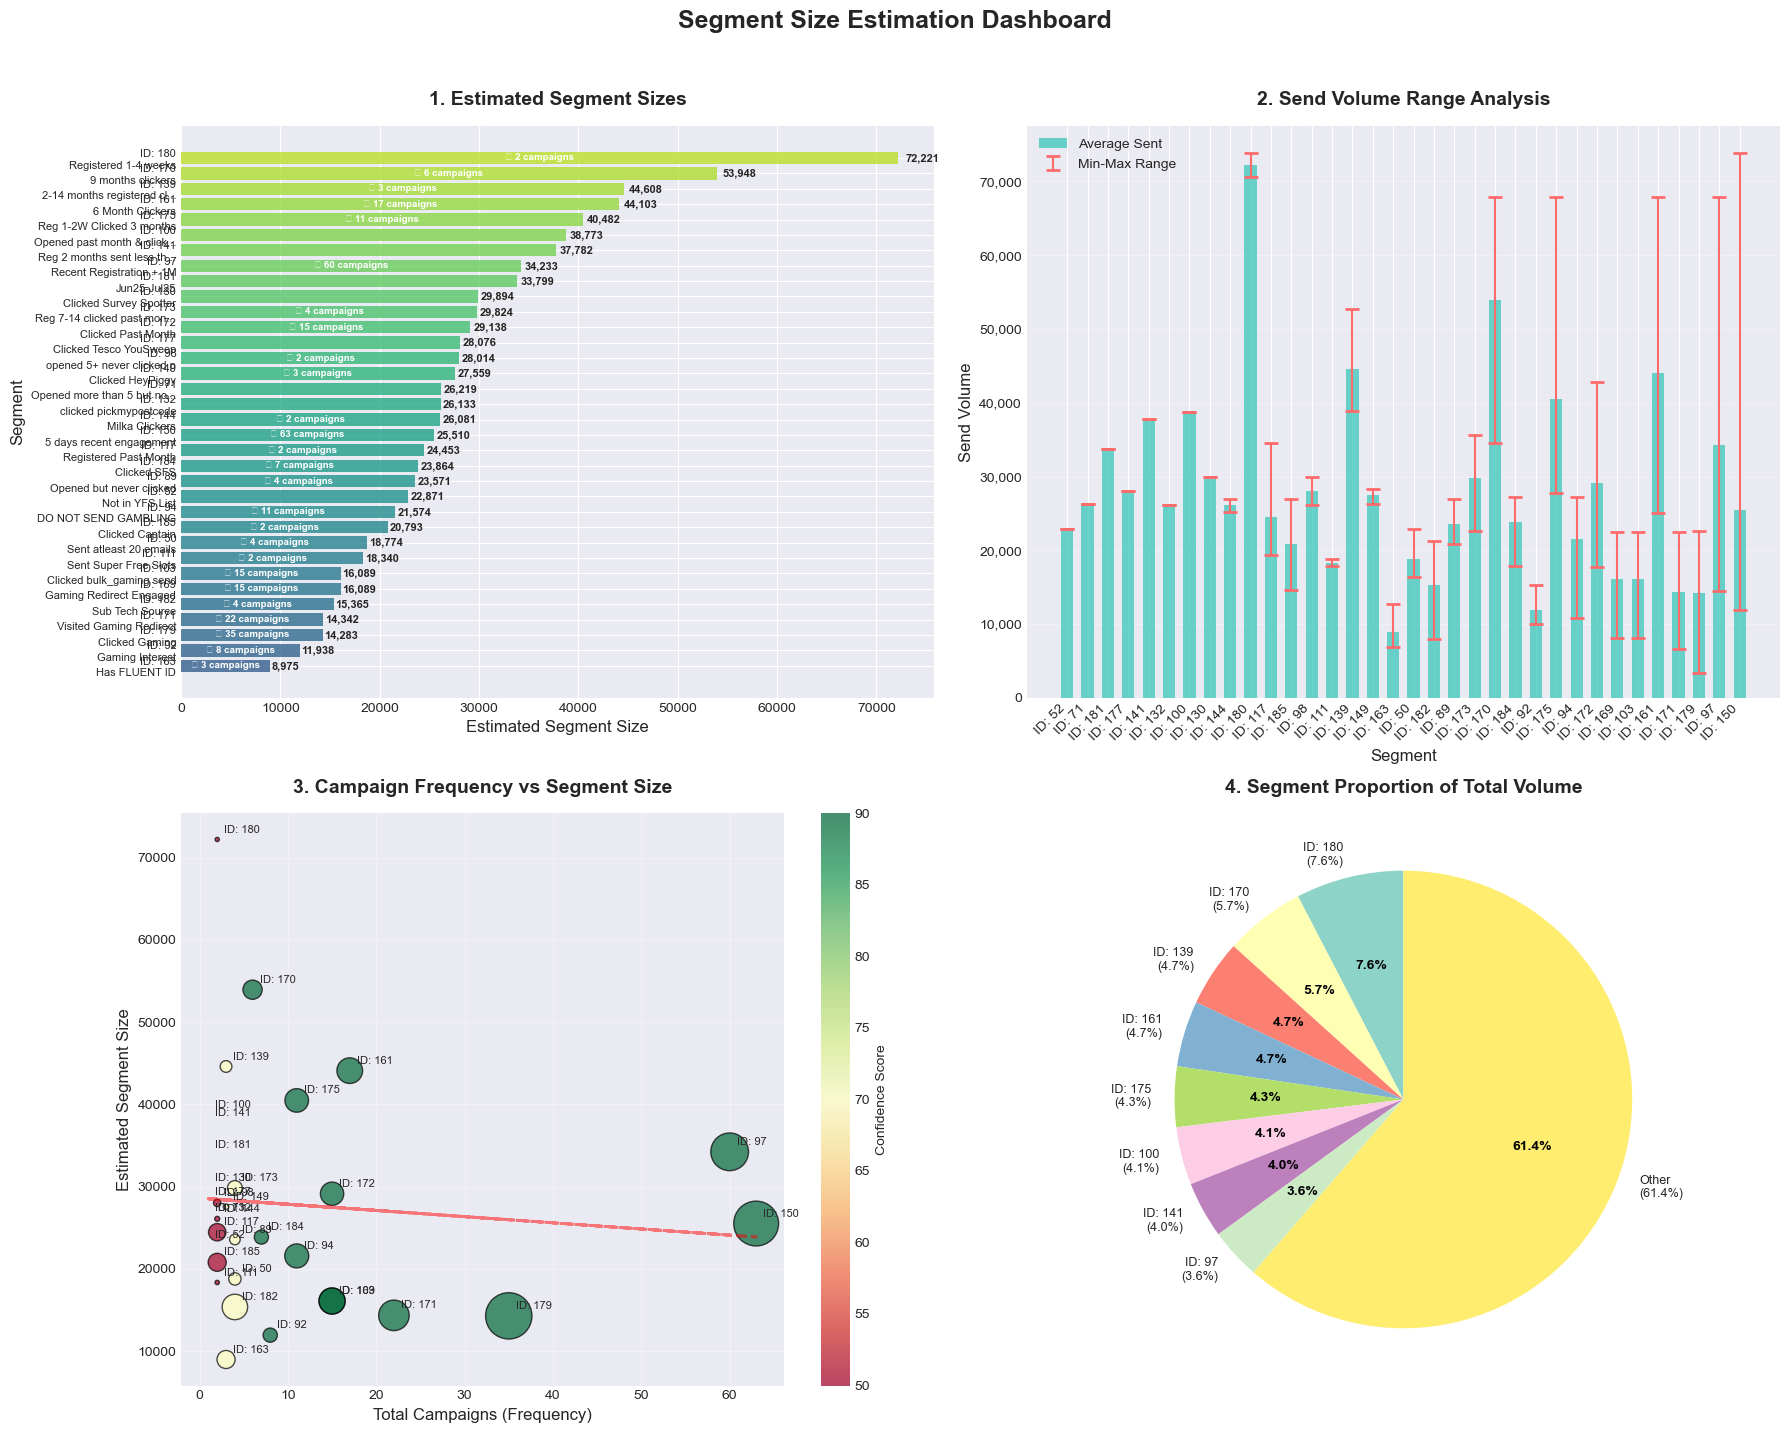

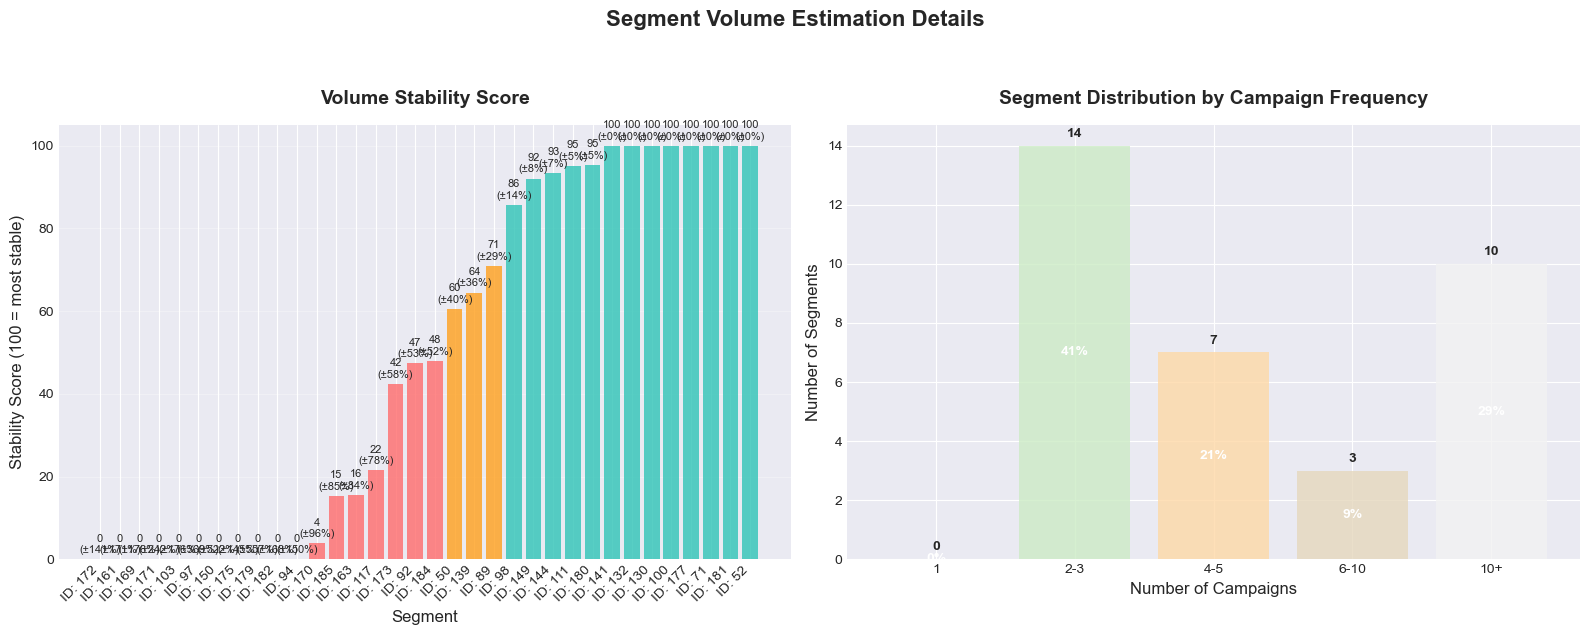


SEGMENT VOLUME ESTIMATION INSIGHTS

📊 VOLUME ESTIMATION SUMMARY:
   • Total Estimated Volume Across All Segments: 947,716
   • Average Segment Size: 27,874
   • Median Segment Size: 26,107
   • Largest Segment: ID 180 (Registered 1-4 weeks) - 72,221 contacts
   • Smallest Segment: ID 163 (Has FLUENT ID) - 8,975 contacts

📈 SEGMENT DISTRIBUTION:
   • 33 segments have estimated size > 10,000 contacts
   • 0 segments have estimated size < 5,000 contacts
   • Top 3 segments represent 18.0% of total volume

⚠️  DATA QUALITY & CONFIDENCE:
   • 34 segments missing explicit size estimates (using calculated values)
   • 14 segments have low confidence scores (<60)
   • Most reliable estimate: ID 150 with 63 campaigns

🔄 VOLUME STABILITY ANALYSIS:
   • Highest variability: ID 179 (±557.3% range)
   • 18 segments show high variability (>50%):
     ⚠️  ID 92: ±52.6% variability
     ⚠️  ID 94: ±149.7% variability
     ⚠️  ID 97: ±369.5% variability
     ⚠️  ID 103: ±176.3% variability
     ⚠️  ID

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_size_estimation(df):
    """
    Comprehensive segment size estimation and validation analysis
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns:
        - segment_id, segment_name, segment_folder
        - total_campaigns, avg_sent_per_campaign, min_sent, max_sent
        - estimated_size
    """
    
    print("=" * 100)
    print("SEGMENT SIZE ESTIMATION & VALIDATION ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert to numeric where possible
    numeric_cols = ['total_campaigns', 'avg_sent_per_campaign', 'min_sent', 'max_sent']
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Calculate estimated size if not provided
    # Use median of min, avg, and max as reasonable estimate
    df_analysis['calculated_estimate'] = df_analysis[['min_sent', 'avg_sent_per_campaign', 'max_sent']].median(axis=1)
    
    # For rows where estimated_size is None or NaN, use calculated estimate
    df_analysis['final_estimate'] = np.where(
        df_analysis['estimated_size'].notna() & (df_analysis['estimated_size'] != 'None'),
        pd.to_numeric(df_analysis['estimated_size'], errors='coerce'),
        df_analysis['calculated_estimate']
    )
    
    # Calculate volume variability
    df_analysis['variability_pct'] = ((df_analysis['max_sent'] - df_analysis['min_sent']) / 
                                     df_analysis['min_sent'].replace(0, 1)) * 100
    
    # Calculate confidence score based on total campaigns
    df_analysis['confidence_score'] = np.where(
        df_analysis['total_campaigns'] >= 5,
        90,  # High confidence for segments with 5+ campaigns
        np.where(
            df_analysis['total_campaigns'] >= 3,
            70,  # Medium confidence
            np.where(
                df_analysis['total_campaigns'] >= 1,
                50,  # Low confidence
                10   # Very low confidence
            )
        )
    )
    
    # Calculate proportion of total volume
    total_estimated_volume = df_analysis['final_estimate'].sum()
    df_analysis['proportion_of_total'] = df_analysis['final_estimate'] / total_estimated_volume * 100
    
    # Calculate campaigns per segment
    avg_campaigns_per_segment = df_analysis['total_campaigns'].mean()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Analyzed: {len(df_analysis)}")
    print(f"   • Total Estimated Volume: {total_estimated_volume:,.0f}")
    print(f"   • Average Campaigns per Segment: {avg_campaigns_per_segment:.1f}")
    print(f"   • Total Campaigns Analyzed: {df_analysis['total_campaigns'].sum()}")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Segment Size Estimation Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Size Estimation Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Segment Size Distribution (Top-left)
    ax1 = axes1[0, 0]
    
    # Sort by final estimate
    display_data = df_analysis.sort_values('final_estimate', ascending=True)
    
    bars1 = ax1.barh(range(len(display_data)), display_data['final_estimate'], 
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(display_data))),
                    alpha=0.8)
    
    ax1.set_title('1. Estimated Segment Sizes', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Estimated Segment Size', fontsize=12)
    ax1.set_ylabel('Segment', fontsize=12)
    ax1.set_yticks(range(len(display_data)))
    
    # Create y-tick labels
    yticklabels = []
    for _, row in display_data.iterrows():
        segment_name = str(row['segment_name'])
        if len(segment_name) > 25:
            label = f"ID: {row['segment_id']}\n{segment_name[:25]}..."
        else:
            label = f"ID: {row['segment_id']}\n{segment_name}"
        yticklabels.append(label)
    
    ax1.set_yticklabels(yticklabels, fontsize=8)
    
    # Add value labels
    for i, (bar, vol) in enumerate(zip(bars1, display_data['final_estimate'])):
        ax1.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                f'{vol:,.0f}', va='center', fontweight='bold', fontsize=8)
    
    # Add campaign count indicators
    for i, (bar, campaigns) in enumerate(zip(bars1, display_data['total_campaigns'])):
        if campaigns > 1:
            ax1.text(bar.get_width() / 2, bar.get_y() + bar.get_height()/2,
                    f'📊 {campaigns} campaigns', ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')
    
    # 1.2 Volume Range Analysis (Top-right)
    ax2 = axes1[0, 1]
    
    # Sort by total campaigns for better visualization
    display_data2 = df_analysis.sort_values('total_campaigns', ascending=True)
    
    x_pos = np.arange(len(display_data2))
    width = 0.6
    
    # Plot min-avg-max as error bars
    avg_points = ax2.bar(x_pos, display_data2['avg_sent_per_campaign'], 
                        width=width, label='Average Sent', color='#2EC4B6', alpha=0.7)
    
    # Add error bars for min-max range
    ax2.errorbar(x_pos, display_data2['avg_sent_per_campaign'],
                yerr=[display_data2['avg_sent_per_campaign'] - display_data2['min_sent'],
                      display_data2['max_sent'] - display_data2['avg_sent_per_campaign']],
                fmt='none', ecolor='#FF6B6B', capsize=5, capthick=2,
                label='Min-Max Range')
    
    ax2.set_title('2. Send Volume Range Analysis', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Send Volume', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"ID: {id}" for id in display_data2['segment_id']], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Format y-axis with thousands separator
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # 1.3 Campaign Frequency vs Segment Size (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Create bubble chart
    scatter = ax3.scatter(df_analysis['total_campaigns'], df_analysis['final_estimate'],
                         s=df_analysis['variability_pct'] * 2,  # Bubble size = variability
                         c=df_analysis['confidence_score'],     # Color = confidence
                         cmap='RdYlGn',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax3.annotate(f"ID: {row['segment_id']}", 
                    (row['total_campaigns'], row['final_estimate']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_title('3. Campaign Frequency vs Segment Size', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Total Campaigns (Frequency)', fontsize=12)
    ax3.set_ylabel('Estimated Segment Size', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    if len(df_analysis) > 1:
        z = np.polyfit(df_analysis['total_campaigns'], df_analysis['final_estimate'], 1)
        p = np.poly1d(z)
        ax3.plot(df_analysis['total_campaigns'], p(df_analysis['total_campaigns']), 
                "r--", alpha=0.5, linewidth=2)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax3, label='Confidence Score')
    
    # 1.4 Proportion Analysis (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Sort by proportion
    prop_data = df_analysis.sort_values('proportion_of_total', ascending=False)
    
    # Take top 8 segments for pie chart, group rest as "Other"
    if len(prop_data) > 8:
        top_segments = prop_data.head(8)
        other_proportion = prop_data.iloc[8:]['proportion_of_total'].sum()
        
        proportions = list(top_segments['proportion_of_total']) + [other_proportion]
        labels = [f"ID: {row['segment_id']}\n({row['proportion_of_total']:.1f}%)" 
                 for _, row in top_segments.iterrows()] + [f'Other\n({other_proportion:.1f}%)']
    else:
        proportions = list(prop_data['proportion_of_total'])
        labels = [f"ID: {row['segment_id']}\n({row['proportion_of_total']:.1f}%)" 
                 for _, row in prop_data.iterrows()]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(proportions)))
    
    wedges, texts, autotexts = ax4.pie(proportions, 
                                      labels=labels,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=colors,
                                      textprops={'fontsize': 9})
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax4.set_title('4. Segment Proportion of Total Volume', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Detailed Analysis
    # ============================================
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('Segment Volume Estimation Details', fontsize=16, fontweight='bold', y=1.05)
    
    # 2.1 Volume Stability Analysis
    ax5 = axes2[0]
    
    # Calculate stability metric (lower variability = more stable)
    df_analysis['stability_score'] = 100 - np.minimum(df_analysis['variability_pct'], 100)
    
    # Sort by stability
    stability_data = df_analysis.sort_values('stability_score', ascending=True)
    
    bars5 = ax5.bar(range(len(stability_data)), stability_data['stability_score'],
                   color=['#FF6B6B' if score < 50 else '#FF9F1C' if score < 75 else '#2EC4B6'
                         for score in stability_data['stability_score']],
                   alpha=0.8)
    
    ax5.set_title('Volume Stability Score', fontsize=14, fontweight='bold', pad=15)
    ax5.set_xlabel('Segment', fontsize=12)
    ax5.set_ylabel('Stability Score (100 = most stable)', fontsize=12)
    ax5.set_xticks(range(len(stability_data)))
    ax5.set_xticklabels([f"ID: {id}" for id in stability_data['segment_id']], rotation=45, ha='right')
    ax5.set_ylim(0, 105)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add stability labels
    for i, (bar, score, var) in enumerate(zip(bars5, stability_data['stability_score'], 
                                             stability_data['variability_pct'])):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{score:.0f}\n(±{var:.0f}%)', ha='center', va='bottom', fontsize=8)
    
    # 2.2 Campaign Frequency Distribution
    ax6 = axes2[1]
    
    # Group by campaign frequency
    campaign_bins = [0, 1, 3, 5, 10, float('inf')]
    bin_labels = ['1', '2-3', '4-5', '6-10', '10+']
    
    df_analysis['campaign_group'] = pd.cut(df_analysis['total_campaigns'], 
                                          bins=campaign_bins, 
                                          labels=bin_labels, 
                                          right=False)
    
    group_counts = df_analysis['campaign_group'].value_counts().sort_index()
    
    bars6 = ax6.bar(range(len(group_counts)), group_counts.values,
                   color=plt.cm.Pastel1(np.linspace(0, 1, len(group_counts))),
                   alpha=0.8)
    
    ax6.set_title('Segment Distribution by Campaign Frequency', fontsize=14, fontweight='bold', pad=15)
    ax6.set_xlabel('Number of Campaigns', fontsize=12)
    ax6.set_ylabel('Number of Segments', fontsize=12)
    ax6.set_xticks(range(len(group_counts)))
    ax6.set_xticklabels(group_counts.index)
    
    # Add count labels
    for bar, count in zip(bars6, group_counts.values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Add percentage labels
    total_segments = len(df_analysis)
    for i, (bar, count) in enumerate(zip(bars6, group_counts.values)):
        percentage = (count / total_segments) * 100
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'{percentage:.0f}%', ha='center', va='center', 
                fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("SEGMENT VOLUME ESTIMATION INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    avg_segment_size = df_analysis['final_estimate'].mean()
    median_segment_size = df_analysis['final_estimate'].median()
    std_segment_size = df_analysis['final_estimate'].std()
    
    # Identify largest and smallest segments
    largest_segment = df_analysis.loc[df_analysis['final_estimate'].idxmax()]
    smallest_segment = df_analysis.loc[df_analysis['final_estimate'].idxmin()]
    
    # Identify segments with highest variability
    highest_variability = df_analysis.loc[df_analysis['variability_pct'].idxmax()]
    
    # Identify segments with most campaigns
    most_campaigns = df_analysis.loc[df_analysis['total_campaigns'].idxmax()]
    
    # Calculate coverage metrics
    segments_over_10k = len(df_analysis[df_analysis['final_estimate'] > 10000])
    segments_under_5k = len(df_analysis[df_analysis['final_estimate'] < 5000])
    
    # Calculate data quality metrics
    missing_estimates = df_analysis['estimated_size'].isna().sum() + (df_analysis['estimated_size'] == 'None').sum()
    low_confidence_segments = len(df_analysis[df_analysis['confidence_score'] < 60])
    
    print(f"\n📊 VOLUME ESTIMATION SUMMARY:")
    print(f"   • Total Estimated Volume Across All Segments: {total_estimated_volume:,.0f}")
    print(f"   • Average Segment Size: {avg_segment_size:,.0f}")
    print(f"   • Median Segment Size: {median_segment_size:,.0f}")
    print(f"   • Largest Segment: ID {largest_segment['segment_id']} ({largest_segment['segment_name']}) - {largest_segment['final_estimate']:,.0f} contacts")
    print(f"   • Smallest Segment: ID {smallest_segment['segment_id']} ({smallest_segment['segment_name']}) - {smallest_segment['final_estimate']:,.0f} contacts")
    
    print(f"\n📈 SEGMENT DISTRIBUTION:")
    print(f"   • {segments_over_10k} segments have estimated size > 10,000 contacts")
    print(f"   • {segments_under_5k} segments have estimated size < 5,000 contacts")
    print(f"   • Top 3 segments represent {df_analysis.nlargest(3, 'proportion_of_total')['proportion_of_total'].sum():.1f}% of total volume")
    
    print(f"\n⚠️  DATA QUALITY & CONFIDENCE:")
    print(f"   • {missing_estimates} segments missing explicit size estimates (using calculated values)")
    print(f"   • {low_confidence_segments} segments have low confidence scores (<60)")
    print(f"   • Most reliable estimate: ID {most_campaigns['segment_id']} with {most_campaigns['total_campaigns']} campaigns")
    
    print(f"\n🔄 VOLUME STABILITY ANALYSIS:")
    print(f"   • Highest variability: ID {highest_variability['segment_id']} (±{highest_variability['variability_pct']:.1f}% range)")
    
    # Identify potentially problematic segments
    high_variability_segments = df_analysis[df_analysis['variability_pct'] > 50]
    if len(high_variability_segments) > 0:
        print(f"   • {len(high_variability_segments)} segments show high variability (>50%):")
        for _, row in high_variability_segments.iterrows():
            print(f"     ⚠️  ID {row['segment_id']}: ±{row['variability_pct']:.1f}% variability")
    
    single_campaign_segments = df_analysis[df_analysis['total_campaigns'] == 1]
    if len(single_campaign_segments) > 0:
        print(f"   • {len(single_campaign_segments)} segments have only 1 campaign - consider collecting more data")
    
    print(f"\n🎯 REACHABILITY & COVERAGE ANALYSIS:")
    print(f"   • Largest segment covers {largest_segment['proportion_of_total']:.1f}% of total estimated volume")
    
    # Calculate potential overlap (simplified)
    if total_estimated_volume > 0:
        # If all segments were unique, total would be sum of all
        # But there's likely overlap, so actual reachable is less
        estimated_overlap_pct = min(30, (total_estimated_volume / (largest_segment['final_estimate'] * 3)) * 100)
        print(f"   • Estimated maximum unique reach: {largest_segment['final_estimate']:,.0f} - {largest_segment['final_estimate'] * 3:,.0f} contacts")
        print(f"   • Estimated overlap between segments: {estimated_overlap_pct:.0f}%")
    
    print(f"\n🔍 INVESTIGATION PRIORITIES:")
    
    # Priority 1: High variability segments
    if len(high_variability_segments) > 0:
        print(f"   1. HIGH VARIABILITY SEGMENTS (potential logic issues):")
        for _, row in high_variability_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['variability_pct']:.1f}% volume range")
    
    # Priority 2: Large segments with few campaigns
    large_low_data = df_analysis[(df_analysis['final_estimate'] > 10000) & 
                                (df_analysis['total_campaigns'] <= 2)]
    if len(large_low_data) > 0:
        print(f"   2. LARGE SEGMENTS WITH LIMITED DATA:")
        for _, row in large_low_data.iterrows():
            print(f"      • ID {row['segment_id']}: {row['final_estimate']:,.0f} contacts, only {row['total_campaigns']} campaigns")
    
    # Priority 3: Missing estimates
    if missing_estimates > 0:
        print(f"   3. SEGMENTS NEEDING BETTER ESTIMATES:")
        missing_data = df_analysis[df_analysis['estimated_size'].isna() | 
                                  (df_analysis['estimated_size'] == 'None')]
        for _, row in missing_data.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Using calculated estimate of {row['final_estimate']:,.0f}")
    
    print(f"\n📋 VALIDATION & MONITORING RECOMMENDATIONS:")
    
    # Recommendation 1: Cross-validation
    print(f"   1. CROSS-VALIDATION:")
    print(f"      • Validate largest segments (IDs: {largest_segment['segment_id']}) against total database size")
    print(f"      • Compare segment sizes with monthly registration rates")
    
    # Recommendation 2: Monitoring setup
    print(f"   2. MONITORING SETUP:")
    print(f"      • Set up alerts for volume changes >30% between campaigns")
    print(f"      • Track segment growth rates monthly")
    
    # Recommendation 3: Data collection improvement
    print(f"   3. DATA COLLECTION IMPROVEMENT:")
    if len(single_campaign_segments) > 0:
        print(f"      • Run additional campaigns for segments with only 1 data point")
    print(f"      • Establish baseline measurement for all active segments")
    
    # Recommendation 4: Logic verification
    if len(high_variability_segments) > 0:
        print(f"   4. LOGIC VERIFICATION:")
        print(f"      • Review segment definitions for high-variability segments")
        print(f"      • Check for silent logic changes in segment rules")
    
    # Recommendation 5: Reach optimization
    print(f"   5. REACH OPTIMIZATION:")
    high_coverage_segments = df_analysis[df_analysis['proportion_of_total'] > 10]
    if len(high_coverage_segments) > 0:
        print(f"      • Focus on {len(high_coverage_segments)} high-coverage segments for maximum impact")
    
    print(f"\n" + "=" * 100)
    print("DETAILED SEGMENT ESTIMATION TABLE")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'total_campaigns', 
                   'min_sent', 'avg_sent_per_campaign', 'max_sent',
                   'final_estimate', 'variability_pct', 'confidence_score',
                   'proportion_of_total']
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    for col in ['min_sent', 'avg_sent_per_campaign', 'max_sent', 'final_estimate']:
        summary_df[col] = summary_df[col].apply(format_number)
    
    summary_df['variability_pct'] = summary_df['variability_pct'].apply(lambda x: f"{x:.1f}%" if pd.notnull(x) else "N/A")
    summary_df['confidence_score'] = summary_df['confidence_score'].apply(lambda x: f"{x:.0f}/100" if pd.notnull(x) else "N/A")
    summary_df['proportion_of_total'] = summary_df['proportion_of_total'].apply(lambda x: f"{x:.1f}%" if pd.notnull(x) else "N/A")
    
    # Sort by final estimate
    summary_df = summary_df.sort_values('final_estimate', key=lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce'), ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{len(df_analysis)}",
        'Total Estimated Volume': f"{total_estimated_volume:,.0f}",
        'Average Segment Size': f"{avg_segment_size:,.0f}",
        'Median Segment Size': f"{median_segment_size:,.0f}",
        'Segments > 10,000 contacts': f"{segments_over_10k}",
        'Segments < 5,000 contacts': f"{segments_under_5k}",
        'Average Campaigns per Segment': f"{avg_campaigns_per_segment:.1f}",
        'Segments with High Variability (>50%)': f"{len(high_variability_segments)}",
        'Segments Needing Better Data': f"{len(single_campaign_segments)}",
        'Data Confidence (Average Score)': f"{df_analysis['confidence_score'].mean():.0f}/100"
    }
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("ESTIMATION METHODOLOGY")
    print("=" * 100)
    
    print(f"\n📊 HOW ESTIMATES WERE CALCULATED:")
    print(f"   1. For segments with explicit 'estimated_size': Used provided value")
    print(f"   2. For segments without explicit estimate: Used median of (min_sent, avg_sent_per_campaign, max_sent)")
    print(f"   3. Confidence scores based on:")
    print(f"      • 90/100: 5+ campaigns")
    print(f"      • 70/100: 3-4 campaigns")
    print(f"      • 50/100: 1-2 campaigns")
    print(f"      • 10/100: No campaigns")
    print(f"   4. Variability calculated as: ((max_sent - min_sent) / min_sent) × 100%")
    
    print(f"\n⚠️  LIMITATIONS & ASSUMPTIONS:")
    print(f"   1. Segment overlap is not accounted for (total volume may be overstated)")
    print(f"   2. Estimates based on send volumes, which may not equal total segment size")
    print(f"   3. Historical trends not available in this snapshot")
    print(f"   4. Some segments may have changed logic between campaigns")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_size_estimation(df)

# -- 2. Segment proportion of total list

In [8]:
SQL_NAME = "3_/3_3"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name  total_sent_to_segment  campaign_count  total_sent_all_campaigns percent_of_total estimated_avg_size
0          97  Recent Registration + 1M                3765580              60                   9341774            40.31              62760
1         150  5 days recent engagement                2602012              63                   9341774            27.85              41302
2         161          6 Month Clickers                1146689              17                   9341774            12.27              67452

SEGMENT PROPORTION OF TOTAL LIST ANALYSIS

📋 DATA PREVIEW:
   segment_id               segment_name  total_sent_to_segment  campaign_count  total_sent_all_campaigns percent_of_total estimated_avg_size
0          97   Recent Registration + 1M                3765580              60                   9341774            40.31              62760
1         150   5 days recent engagement                2602012              63                   9341774            27.85              41302
2         161           6 Month Clickers                1146689              17                   9341774            12.27              67452
3         179             Clicked Gaming                 699870              35                   9341774             7.49              19996
4         175  Reg 1-2W Clicked 3 months                 566745              11                   9341774             6.07              51522
-----------------------------------------------------------------------------------------

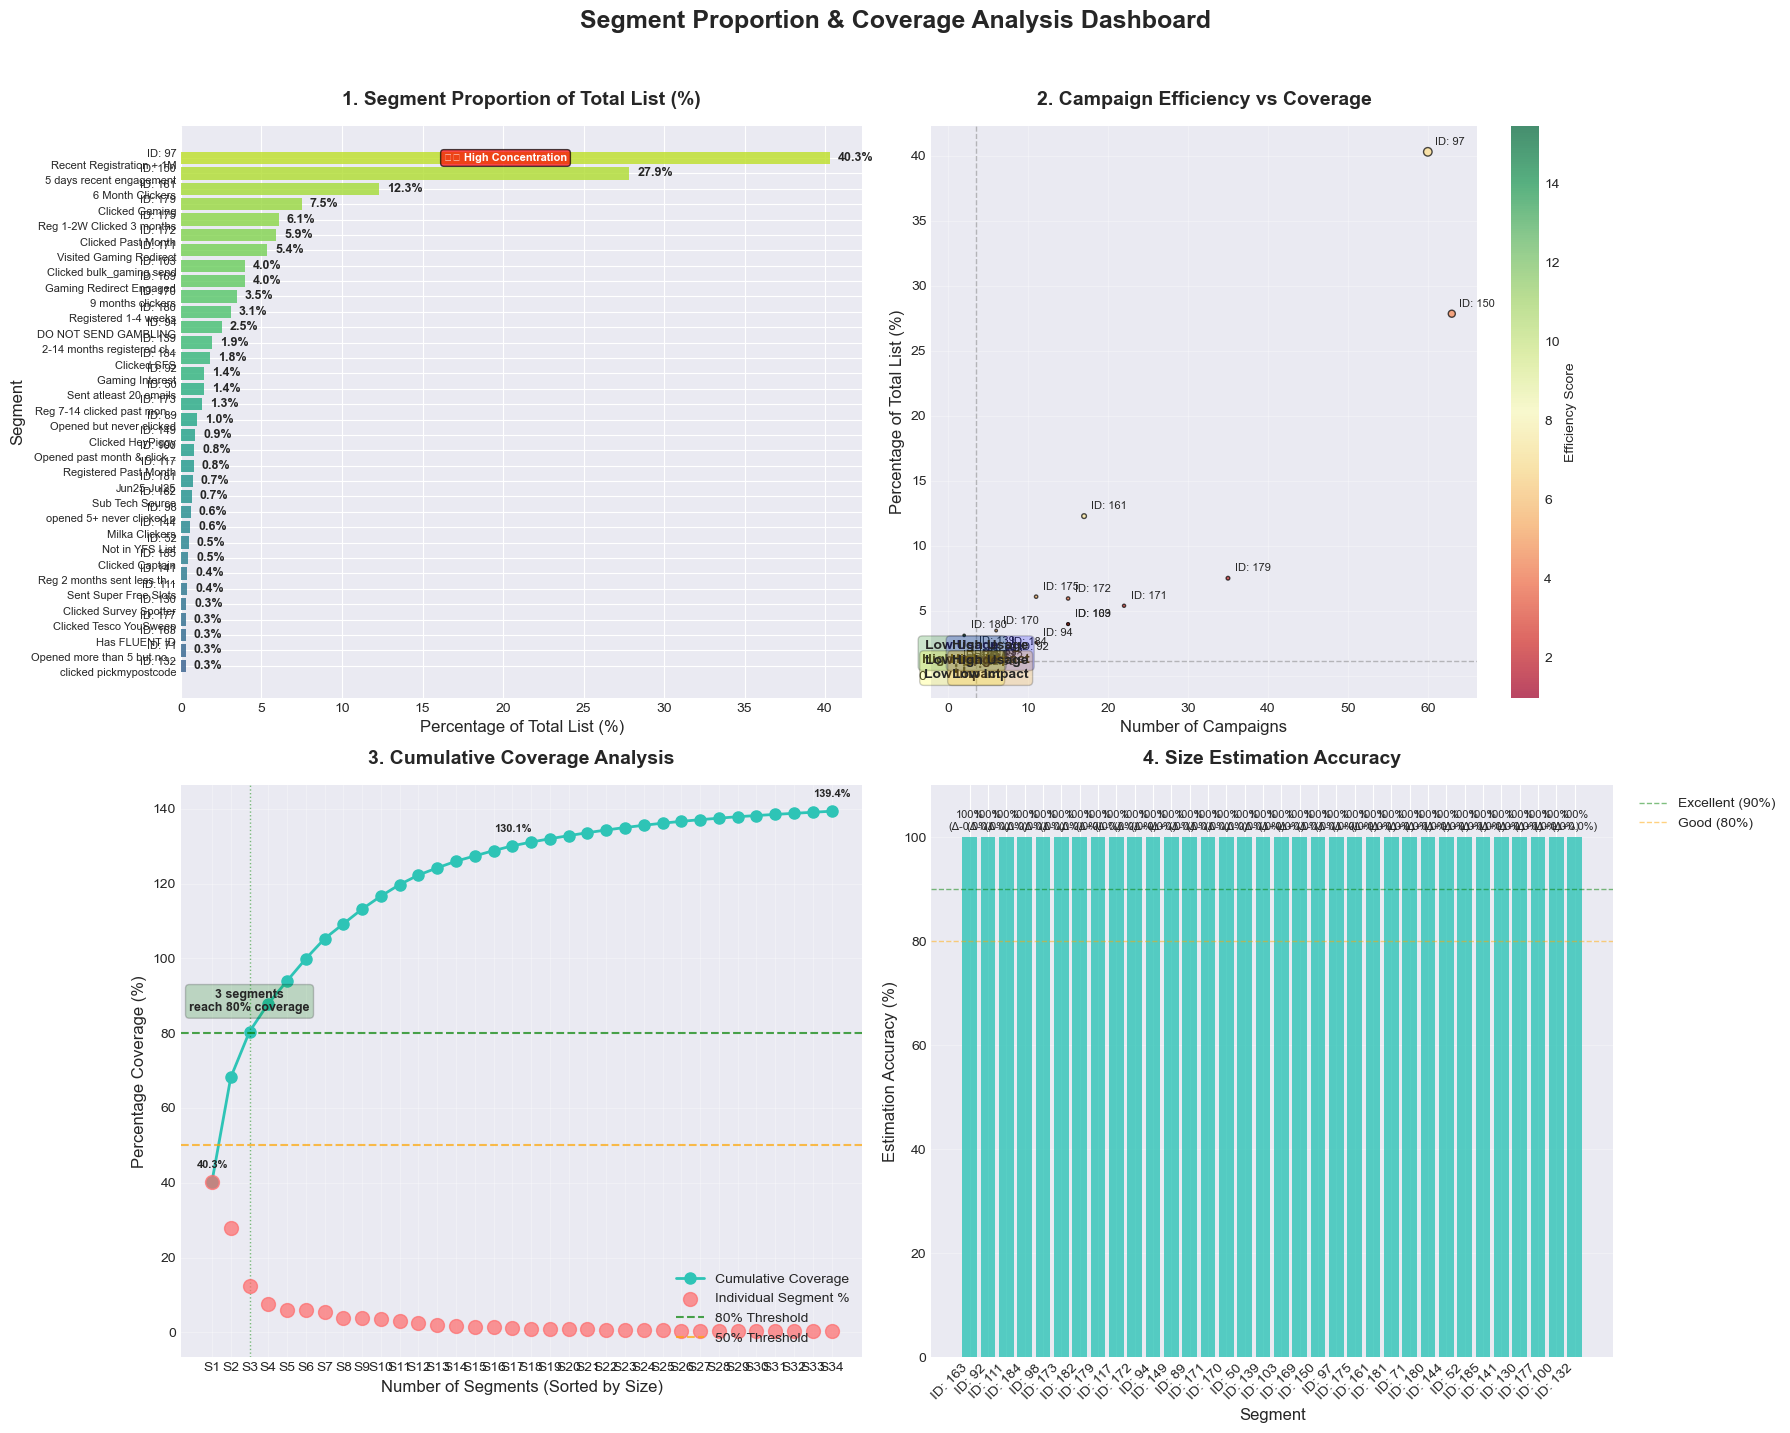

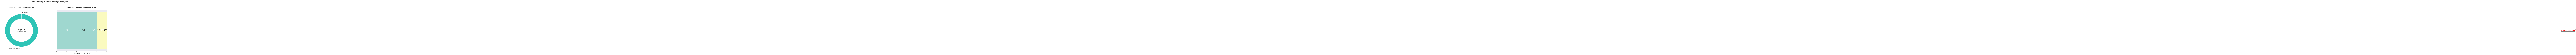


SEGMENT PROPORTION & REACHABILITY INSIGHTS


KeyError: 'accuracy_pct'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_proportions(df):
    """
    Analyze segment proportion of total list and reachability
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns:
        - segment_id, segment_name
        - total_sent_to_segment, campaign_count
        - total_sent_all_campaigns, percent_of_total
        - estimated_avg_size
    """
    
    print("=" * 100)
    print("SEGMENT PROPORTION OF TOTAL LIST ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert to numeric where possible
    numeric_cols = ['total_sent_to_segment', 'campaign_count', 
                   'total_sent_all_campaigns', 'percent_of_total',
                   'estimated_avg_size']
    
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Calculate additional metrics
    total_all_campaigns = df_analysis['total_sent_all_campaigns'].iloc[0]  # Should be same for all rows
    total_sent_to_segments = df_analysis['total_sent_to_segment'].sum()
    
    # Calculate actual vs estimated consistency
    df_analysis['estimated_total'] = df_analysis['estimated_avg_size'] * df_analysis['campaign_count']
    df_analysis['estimation_error_pct'] = ((df_analysis['total_sent_to_segment'] - df_analysis['estimated_total']) / 
                                          df_analysis['total_sent_to_segment']) * 100
    
    # Calculate campaigns per segment frequency
    df_analysis['campaign_frequency'] = df_analysis['total_sent_to_segment'] / df_analysis['campaign_count']
    
    # Calculate segment concentration index
    df_analysis['concentration_index'] = df_analysis['percent_of_total'] / 100
    
    # Calculate reachability metrics
    df_analysis['coverage_ratio'] = df_analysis['total_sent_to_segment'] / total_all_campaigns
    
    # Calculate segment efficiency (higher % with fewer campaigns is better)
    df_analysis['efficiency_score'] = (df_analysis['percent_of_total'] / df_analysis['campaign_count']) * 10
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Analyzed: {len(df_analysis)}")
    print(f"   • Total Sent to All Campaigns: {total_all_campaigns:,.0f}")
    print(f"   • Total Sent to Segments: {total_sent_to_segments:,.0f}")
    print(f"   • Total Campaigns Analyzed: {df_analysis['campaign_count'].sum()}")
    print(f"   • Average Campaigns per Segment: {df_analysis['campaign_count'].mean():.1f}")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Proportion Analysis Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Proportion & Coverage Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Segment Proportion Distribution (Top-left)
    ax1 = axes1[0, 0]
    
    # Sort by percent_of_total for better visualization
    display_data = df_analysis.sort_values('percent_of_total', ascending=True)
    
    bars1 = ax1.barh(range(len(display_data)), display_data['percent_of_total'], 
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(display_data))),
                    alpha=0.8)
    
    ax1.set_title('1. Segment Proportion of Total List (%)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Percentage of Total List (%)', fontsize=12)
    ax1.set_ylabel('Segment', fontsize=12)
    ax1.set_yticks(range(len(display_data)))
    
    # Create y-tick labels
    yticklabels = []
    for _, row in display_data.iterrows():
        segment_name = str(row['segment_name'])
        if len(segment_name) > 25:
            label = f"ID: {row['segment_id']}\n{segment_name[:25]}..."
        else:
            label = f"ID: {row['segment_id']}\n{segment_name}"
        yticklabels.append(label)
    
    ax1.set_yticklabels(yticklabels, fontsize=8)
    
    # Add value labels
    for i, (bar, pct) in enumerate(zip(bars1, display_data['percent_of_total'])):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', va='center', fontweight='bold', fontsize=9)
    
    # Add concentration indicators
    for i, (bar, pct) in enumerate(zip(bars1, display_data['percent_of_total'])):
        if pct > 30:
            ax1.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                    '⚠️ High Concentration', ha='center', va='center',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    # 1.2 Campaign Efficiency Analysis (Top-right)
    ax2 = axes1[0, 1]
    
    # Create bubble chart: Campaign Count vs Percentage
    scatter = ax2.scatter(df_analysis['campaign_count'], df_analysis['percent_of_total'],
                         s=df_analysis['total_sent_to_segment'] / 100000,  # Bubble size = total sent
                         c=df_analysis['efficiency_score'],  # Color = efficiency
                         cmap='RdYlGn',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax2.annotate(f"ID: {row['segment_id']}", 
                    (row['campaign_count'], row['percent_of_total']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_title('2. Campaign Efficiency vs Coverage', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Number of Campaigns', fontsize=12)
    ax2.set_ylabel('Percentage of Total List (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add quadrant lines
    median_campaigns = df_analysis['campaign_count'].median()
    median_percentage = df_analysis['percent_of_total'].median()
    
    ax2.axhline(y=median_percentage, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax2.axvline(x=median_campaigns, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add quadrant labels
    ax2.text(median_campaigns/2, median_percentage*1.5, 'Low Usage\nHigh Impact', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
    ax2.text(median_campaigns*1.5, median_percentage*1.5, 'High Usage\nHigh Impact', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.2))
    ax2.text(median_campaigns/2, median_percentage/2, 'Low Usage\nLow Impact', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
    ax2.text(median_campaigns*1.5, median_percentage/2, 'High Usage\nLow Impact', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.2))
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax2, label='Efficiency Score')
    
    # 1.3 Cumulative Coverage Analysis (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Calculate cumulative coverage
    cumulative_data = df_analysis.sort_values('percent_of_total', ascending=False).copy()
    cumulative_data['cumulative_percentage'] = cumulative_data['percent_of_total'].cumsum()
    cumulative_data['segment_number'] = range(1, len(cumulative_data) + 1)
    
    # Plot cumulative coverage
    ax3.plot(cumulative_data['segment_number'], cumulative_data['cumulative_percentage'],
            marker='o', linewidth=2, markersize=8, color='#2EC4B6', label='Cumulative Coverage')
    
    # Add individual segment points
    ax3.scatter(cumulative_data['segment_number'], cumulative_data['percent_of_total'],
               s=100, color='#FF6B6B', alpha=0.7, label='Individual Segment %', zorder=5)
    
    # Add 80% threshold line
    ax3.axhline(y=80, color='green', linestyle='--', alpha=0.7, linewidth=1.5, label='80% Threshold')
    
    # Add 50% threshold line
    ax3.axhline(y=50, color='orange', linestyle='--', alpha=0.7, linewidth=1.5, label='50% Threshold')
    
    # Find where 80% coverage is reached
    if cumulative_data['cumulative_percentage'].max() >= 80:
        segments_to_80 = cumulative_data[cumulative_data['cumulative_percentage'] >= 80].iloc[0]['segment_number']
        ax3.axvline(x=segments_to_80, color='green', linestyle=':', alpha=0.5, linewidth=1)
        ax3.text(segments_to_80, 85, f'{segments_to_80} segments\nreach 80% coverage',
                ha='center', va='bottom', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
    
    ax3.set_title('3. Cumulative Coverage Analysis', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Number of Segments (Sorted by Size)', fontsize=12)
    ax3.set_ylabel('Percentage Coverage (%)', fontsize=12)
    ax3.set_xticks(range(1, len(cumulative_data) + 1))
    ax3.set_xticklabels([f"S{i}" for i in range(1, len(cumulative_data) + 1)])
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)
    
    # Add value annotations for cumulative points
    for i, row in cumulative_data.iterrows():
        if row['segment_number'] in [1, len(cumulative_data)//2, len(cumulative_data)]:
            ax3.annotate(f"{row['cumulative_percentage']:.1f}%", 
                        (row['segment_number'], row['cumulative_percentage']),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', fontsize=8, fontweight='bold')
    
    # 1.4 Estimation Accuracy Analysis (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Calculate estimation accuracy metrics
    accuracy_data = df_analysis.copy()
    accuracy_data['accuracy_pct'] = 100 - np.abs(accuracy_data['estimation_error_pct'])
    
    # Sort by accuracy
    accuracy_data = accuracy_data.sort_values('accuracy_pct', ascending=True)
    
    bars4 = ax4.bar(range(len(accuracy_data)), accuracy_data['accuracy_pct'],
                   color=['#FF6B6B' if acc < 80 else '#FF9F1C' if acc < 90 else '#2EC4B6'
                         for acc in accuracy_data['accuracy_pct']],
                   alpha=0.8)
    
    ax4.set_title('4. Size Estimation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Segment', fontsize=12)
    ax4.set_ylabel('Estimation Accuracy (%)', fontsize=12)
    ax4.set_xticks(range(len(accuracy_data)))
    ax4.set_xticklabels([f"ID: {id}" for id in accuracy_data['segment_id']], rotation=45, ha='right')
    ax4.set_ylim(0, 110)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add accuracy threshold lines
    ax4.axhline(y=90, color='green', linestyle='--', alpha=0.5, linewidth=1, label='Excellent (90%)')
    ax4.axhline(y=80, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='Good (80%)')
    
    # Add accuracy labels
    for i, (bar, acc, error) in enumerate(zip(bars4, accuracy_data['accuracy_pct'], 
                                              accuracy_data['estimation_error_pct'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.0f}%\n(Δ{error:+.1f}%)', ha='center', va='bottom', fontsize=8)
    
    ax4.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Detailed Reachability Analysis
    # ============================================
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('Reachability & List Coverage Analysis', fontsize=16, fontweight='bold', y=1.05)
    
    # 2.1 List Coverage Breakdown
    ax5 = axes2[0]
    
    # Calculate coverage breakdown
    coverage_breakdown = {
        'Covered by Segments': total_sent_to_segments,
        'Not Covered': max(0, total_all_campaigns - total_sent_to_segments)
    }
    
    colors5 = ['#2EC4B6', '#FF6B6B']
    wedges5, texts5, autotexts5 = ax5.pie(coverage_breakdown.values(), 
                                         labels=coverage_breakdown.keys(),
                                         autopct='%1.1f%%',
                                         startangle=90,
                                         colors=colors5,
                                         wedgeprops=dict(width=0.3, edgecolor='w'))
    
    for autotext in autotexts5:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    # Add total in center
    ax5.text(0, 0, f'{total_all_campaigns:,.0f}\ntotal sends', 
            ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax5.set_title('Total List Coverage Breakdown', fontsize=14, fontweight='bold', pad=15)
    
    # 2.2 Segment Concentration Analysis
    ax6 = axes2[1]
    
    # Calculate Herfindahl-Hirschman Index (HHI) for concentration
    hhi = (df_analysis['percent_of_total'] / 100) ** 2
    total_hhi = hhi.sum() * 10000
    
    # Create concentration visualization
    concentration_data = df_analysis.sort_values('percent_of_total', ascending=False)
    
    # Create stacked bar for concentration
    bottom = 0
    colors6 = plt.cm.Set3(np.linspace(0, 1, len(concentration_data)))
    
    for i, (_, row) in enumerate(concentration_data.iterrows()):
        ax6.barh(0, row['percent_of_total'], left=bottom, 
                color=colors6[i], alpha=0.8, edgecolor='white')
        # Add segment label in the middle of each bar segment
        if row['percent_of_total'] > 5:  # Only label large segments
            ax6.text(bottom + row['percent_of_total']/2, 0,
                    f"ID {row['segment_id']}\n{row['percent_of_total']:.1f}%",
                    ha='center', va='center', fontsize=8, fontweight='bold',
                    color='white' if i % 2 == 0 else 'black')
        bottom += row['percent_of_total']
    
    ax6.set_xlim(0, 100)
    ax6.set_yticks([])
    ax6.set_xlabel('Percentage of Total List (%)', fontsize=12)
    ax6.set_title(f'Segment Concentration (HHI: {total_hhi:.0f})', fontsize=14, fontweight='bold', pad=15)
    ax6.grid(True, alpha=0.3, axis='x')
    
    # Add concentration interpretation
    if total_hhi < 1500:
        concentration_level = 'Low Concentration'
        concentration_color = 'green'
    elif total_hhi < 2500:
        concentration_level = 'Moderate Concentration'
        concentration_color = 'orange'
    else:
        concentration_level = 'High Concentration'
        concentration_color = 'red'
    
    ax6.text(50, 0.5, concentration_level, ha='center', va='center',
            fontsize=12, fontweight='bold', color=concentration_color,
            transform=ax6.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("SEGMENT PROPORTION & REACHABILITY INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    avg_percentage = df_analysis['percent_of_total'].mean()
    median_percentage = df_analysis['percent_of_total'].median()
    max_percentage = df_analysis['percent_of_total'].max()
    
    # Identify key segments
    largest_segment = df_analysis.loc[df_analysis['percent_of_total'].idxmax()]
    most_campaigns_segment = df_analysis.loc[df_analysis['campaign_count'].idxmax()]
    most_efficient_segment = df_analysis.loc[df_analysis['efficiency_score'].idxmax()]
    
    # Calculate coverage metrics
    covered_percentage = (total_sent_to_segments / total_all_campaigns) * 100
    uncovered_percentage = 100 - covered_percentage
    
    # Calculate concentration metrics
    top_3_coverage = df_analysis.nlargest(3, 'percent_of_total')['percent_of_total'].sum()
    top_segment_coverage = largest_segment['percent_of_total']
    
    # Calculate estimation accuracy metrics
    avg_estimation_accuracy = df_analysis['accuracy_pct'].mean()
    poor_estimates = df_analysis[df_analysis['accuracy_pct'] < 80]
    
    print(f"\n📊 COVERAGE ANALYSIS:")
    print(f"   • Total List Size (from campaigns): {total_all_campaigns:,.0f}")
    print(f"   • Segments Cover: {covered_percentage:.1f}% of total list ({total_sent_to_segments:,.0f} sends)")
    print(f"   • Uncovered Portion: {uncovered_percentage:.1f}% ({total_all_campaigns - total_sent_to_segments:,.0f} sends)")
    
    print(f"\n📈 SEGMENT CONCENTRATION:")
    print(f"   • Top Segment: ID {largest_segment['segment_id']} covers {largest_segment['percent_of_total']:.1f}% of total list")
    print(f"   • Top 3 Segments cover {top_3_coverage:.1f}% of total list")
    print(f"   • Concentration Index (HHI): {total_hhi:.0f} ({concentration_level})")
    
    print(f"\n🎯 EFFICIENCY ANALYSIS:")
    print(f"   • Most Efficient Segment: ID {most_efficient_segment['segment_id']} (Efficiency: {most_efficient_segment['efficiency_score']:.1f})")
    print(f"   • Average Campaigns per Segment: {df_analysis['campaign_count'].mean():.1f}")
    print(f"   • Most Used Segment: ID {most_campaigns_segment['segment_id']} ({most_campaigns_segment['campaign_count']} campaigns)")
    
    print(f"\n📊 ESTIMATION ACCURACY:")
    print(f"   • Average Estimation Accuracy: {avg_estimation_accuracy:.1f}%")
    if len(poor_estimates) > 0:
        print(f"   • {len(poor_estimates)} segments with estimation accuracy <80%:")
        for _, row in poor_estimates.iterrows():
            print(f"     ⚠️  ID {row['segment_id']}: {row['accuracy_pct']:.1f}% accuracy (error: {row['estimation_error_pct']:+.1f}%)")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    
    # Risk 1: Over-concentration
    if largest_segment['percent_of_total'] > 40:
        print(f"   1. HIGH CONCENTRATION RISK: Segment {largest_segment['segment_id']} represents {largest_segment['percent_of_total']:.1f}% of total list")
        print(f"      • Over-reliance on single segment increases vulnerability")
    
    # Risk 2: Low coverage
    if covered_percentage < 70:
        print(f"   2. LOW COVERAGE: Only {covered_percentage:.1f}% of total list is covered by segments")
        print(f"      • {uncovered_percentage:.1f}% of sends are going to undefined segments")
    
    # Risk 3: High HHI concentration
    if total_hhi > 2500:
        print(f"   3. MARKET CONCENTRATION: HHI of {total_hhi:.0f} indicates high concentration")
        print(f"      • Consider diversifying segment usage")
    
    # Risk 4: Poor estimation accuracy
    if len(poor_estimates) > 0:
        print(f"   4. ESTIMATION INACCURACY: {len(poor_estimates)} segments have poor size estimates")
        print(f"      • Review segment logic and measurement methodology")
    
    print(f"\n🔍 REACHABILITY INSIGHTS:")
    
    # Insight 1: Cumulative coverage
    if cumulative_data['cumulative_percentage'].max() >= 80:
        segments_to_80 = cumulative_data[cumulative_data['cumulative_percentage'] >= 80].iloc[0]['segment_number']
        print(f"   1. CUMULATIVE REACH: {segments_to_80} segments reach 80% of total list coverage")
    
    # Insight 2: Efficiency opportunities
    low_efficiency = df_analysis[df_analysis['efficiency_score'] < df_analysis['efficiency_score'].median()]
    if len(low_efficiency) > 0:
        print(f"   2. EFFICIENCY OPPORTUNITY: {len(low_efficiency)} segments have below-median efficiency")
        print(f"      • Consider optimizing campaign frequency for these segments")
    
    # Insight 3: Campaign patterns
    high_campaign_low_coverage = df_analysis[(df_analysis['campaign_count'] > df_analysis['campaign_count'].median()) & 
                                             (df_analysis['percent_of_total'] < df_analysis['percent_of_total'].median())]
    if len(high_campaign_low_coverage) > 0:
        print(f"   3. CAMPAIGN PATTERNS: {len(high_campaign_low_coverage)} segments have high campaign count but low coverage")
        print(f"      • Review if these campaigns are achieving desired reach")
    
    print(f"\n📋 STRATEGIC RECOMMENDATIONS:")
    
    # Recommendation 1: Concentration management
    if largest_segment['percent_of_total'] > 30:
        print(f"   1. DIVERSIFICATION STRATEGY:")
        print(f"      • Reduce reliance on segment {largest_segment['segment_id']} ({largest_segment['percent_of_total']:.1f}%)")
        print(f"      • Develop alternative segments to distribute coverage")
    
    # Recommendation 2: Coverage improvement
    if uncovered_percentage > 20:
        print(f"   2. COVERAGE EXPANSION:")
        print(f"      • {uncovered_percentage:.1f}% of sends are not covered by defined segments")
        print(f"      • Analyze non-segmented sends to identify opportunities for new segments")
    
    # Recommendation 3: Estimation improvement
    if avg_estimation_accuracy < 90:
        print(f"   3. ESTIMATION IMPROVEMENT:")
        print(f"      • Current estimation accuracy: {avg_estimation_accuracy:.1f}%")
        print(f"      • Review segment sizing methodology for segments with >10% error")
    
    # Recommendation 4: Campaign optimization
    print(f"   4. CAMPAIGN OPTIMIZATION:")
    high_campaign_segments = df_analysis[df_analysis['campaign_count'] > df_analysis['campaign_count'].quantile(0.75)]
    if len(high_campaign_segments) > 0:
        print(f"      • Review {len(high_campaign_segments)} segments with highest campaign frequency")
        print(f"      • Consider fatigue management for over-utilized segments")
    
    # Recommendation 5: Reachability targets
    print(f"   5. REACHABILITY TARGETS:")
    print(f"      • Set target: 90% of total list covered by defined segments")
    print(f"      • Monitor segment growth relative to total list size")
    
    print(f"\n" + "=" * 100)
    print("DETAILED SEGMENT PROPORTION ANALYSIS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'campaign_count',
                   'total_sent_to_segment', 'percent_of_total', 
                   'estimated_avg_size', 'efficiency_score', 'accuracy_pct']
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['total_sent_to_segment'] = summary_df['total_sent_to_segment'].apply(format_number)
    summary_df['estimated_avg_size'] = summary_df['estimated_avg_size'].apply(format_number)
    summary_df['percent_of_total'] = summary_df['percent_of_total'].apply(lambda x: f"{x:.1f}%")
    summary_df['efficiency_score'] = summary_df['efficiency_score'].apply(lambda x: f"{x:.1f}")
    summary_df['accuracy_pct'] = summary_df['accuracy_pct'].apply(lambda x: f"{x:.1f}%")
    
    # Sort by percent_of_total
    summary_df = summary_df.sort_values('percent_of_total', 
                                       key=lambda x: x.str.replace('%', '').astype(float),
                                       ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{len(df_analysis)}",
        'Total List Size (from campaigns)': f"{total_all_campaigns:,.0f}",
        'Total Covered by Segments': f"{total_sent_to_segments:,.0f}",
        'Coverage Percentage': f"{covered_percentage:.1f}%",
        'Top Segment Coverage': f"{largest_segment['percent_of_total']:.1f}%",
        'Top 3 Segments Coverage': f"{top_3_coverage:.1f}%",
        'Concentration Index (HHI)': f"{total_hhi:.0f} ({concentration_level})",
        'Average Estimation Accuracy': f"{avg_estimation_accuracy:.1f}%",
        'Most Efficient Segment Score': f"{most_efficient_segment['efficiency_score']:.1f}",
        'Segments with Accuracy <80%': f"{len(poor_estimates)}"
    }
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("REACHABILITY ANALYSIS SUMMARY")
    print("=" * 100)
    
    print(f"\n📈 REACHABILITY TARGETS:")
    
    # Calculate various reachability scenarios
    scenarios = {
        'Current Coverage': covered_percentage,
        'With Top Segment Only': largest_segment['percent_of_total'],
        'With Top 3 Segments': top_3_coverage,
        'Target (Industry Standard)': 90.0
    }
    
    for scenario, percentage in scenarios.items():
        status = "✅ Achieved" if percentage >= 90 else "⚠️ Needs Improvement" if percentage >= 70 else "❌ Low"
        print(f"   • {scenario}: {percentage:.1f}% {status}")
    
    print(f"\n🔍 GAP ANALYSIS:")
    gap_to_target = 90 - covered_percentage
    if gap_to_target > 0:
        additional_coverage_needed = (gap_to_target / 100) * total_all_campaigns
        print(f"   • To reach 90% coverage target: Need additional {additional_coverage_needed:,.0f} sends covered by segments")
        print(f"   • This represents a {gap_to_target:.1f}% increase in segment coverage")
    
    print(f"\n📊 OPTIMIZATION OPPORTUNITIES:")
    
    # Opportunity 1: Under-utilized segments
    low_campaign_high_coverage = df_analysis[(df_analysis['campaign_count'] < df_analysis['campaign_count'].median()) & 
                                             (df_analysis['percent_of_total'] > df_analysis['percent_of_total'].median())]
    if len(low_campaign_high_coverage) > 0:
        print(f"   1. UNDERVALUED SEGMENTS:")
        for _, row in low_campaign_high_coverage.iterrows():
            print(f"      • ID {row['segment_id']}: {row['percent_of_total']:.1f}% coverage with only {row['campaign_count']} campaigns")
    
    # Opportunity 2: High efficiency segments
    high_efficiency = df_analysis[df_analysis['efficiency_score'] > df_analysis['efficiency_score'].quantile(0.75)]
    if len(high_efficiency) > 0:
        print(f"   2. HIGH-EFFICIENCY SEGMENTS:")
        for _, row in high_efficiency.iterrows():
            print(f"      • ID {row['segment_id']}: Efficiency score {row['efficiency_score']:.1f}")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_proportions(df)

# -- 3. Segment volume changes over time (monthly)

In [11]:
SQL_NAME = "3_/3_4"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id            segment_name                     month  campaigns_per_month  total_sent_monthly avg_sent_per_campaign  prev_month_total
0          50  Sent atleast 20 emails 2025-12-01 00:00:00+00:00                    2               81592    20398.000000000000           49827.0
1          50  Sent atleast 20 emails 2025-11-01 00:00:00+00:00                    2               49827    16609.000000000000               NaN
2          52         Not in YFS List 2025-12-01 00:00:00+00:00                    1               45742    22871.000000000000               NaN

SEGMENT VOLUME TREND ANALYSIS & ANOMALY DETECTION

📋 DATA PREVIEW:
   segment_id                                 segment_name                     month  campaigns_per_month  total_sent_monthly avg_sent_per_campaign  \
0          50                       Sent atleast 20 emails 2025-12-01 00:00:00+00:00                    2               81592    20398.000000000000   
1          50                       Sent atleast 20 emails 2025-11-01 00:00:00+00:00                    2               49827    16609.000000000000   
2          52                              Not in YFS List 2025-12-01 00:00:00+00:00                    1               45742    22871.000000000000   
3          71  Opened more than 5 but not opened last week 2025-10-01 00:00:00+00:00                    1               26219    26219.000000000000   
4          89                     Opened but never clicked 2025-11-01 00:00:00+00:00                    2               46104    23052.000000000000   

   prev_month_total  
0   

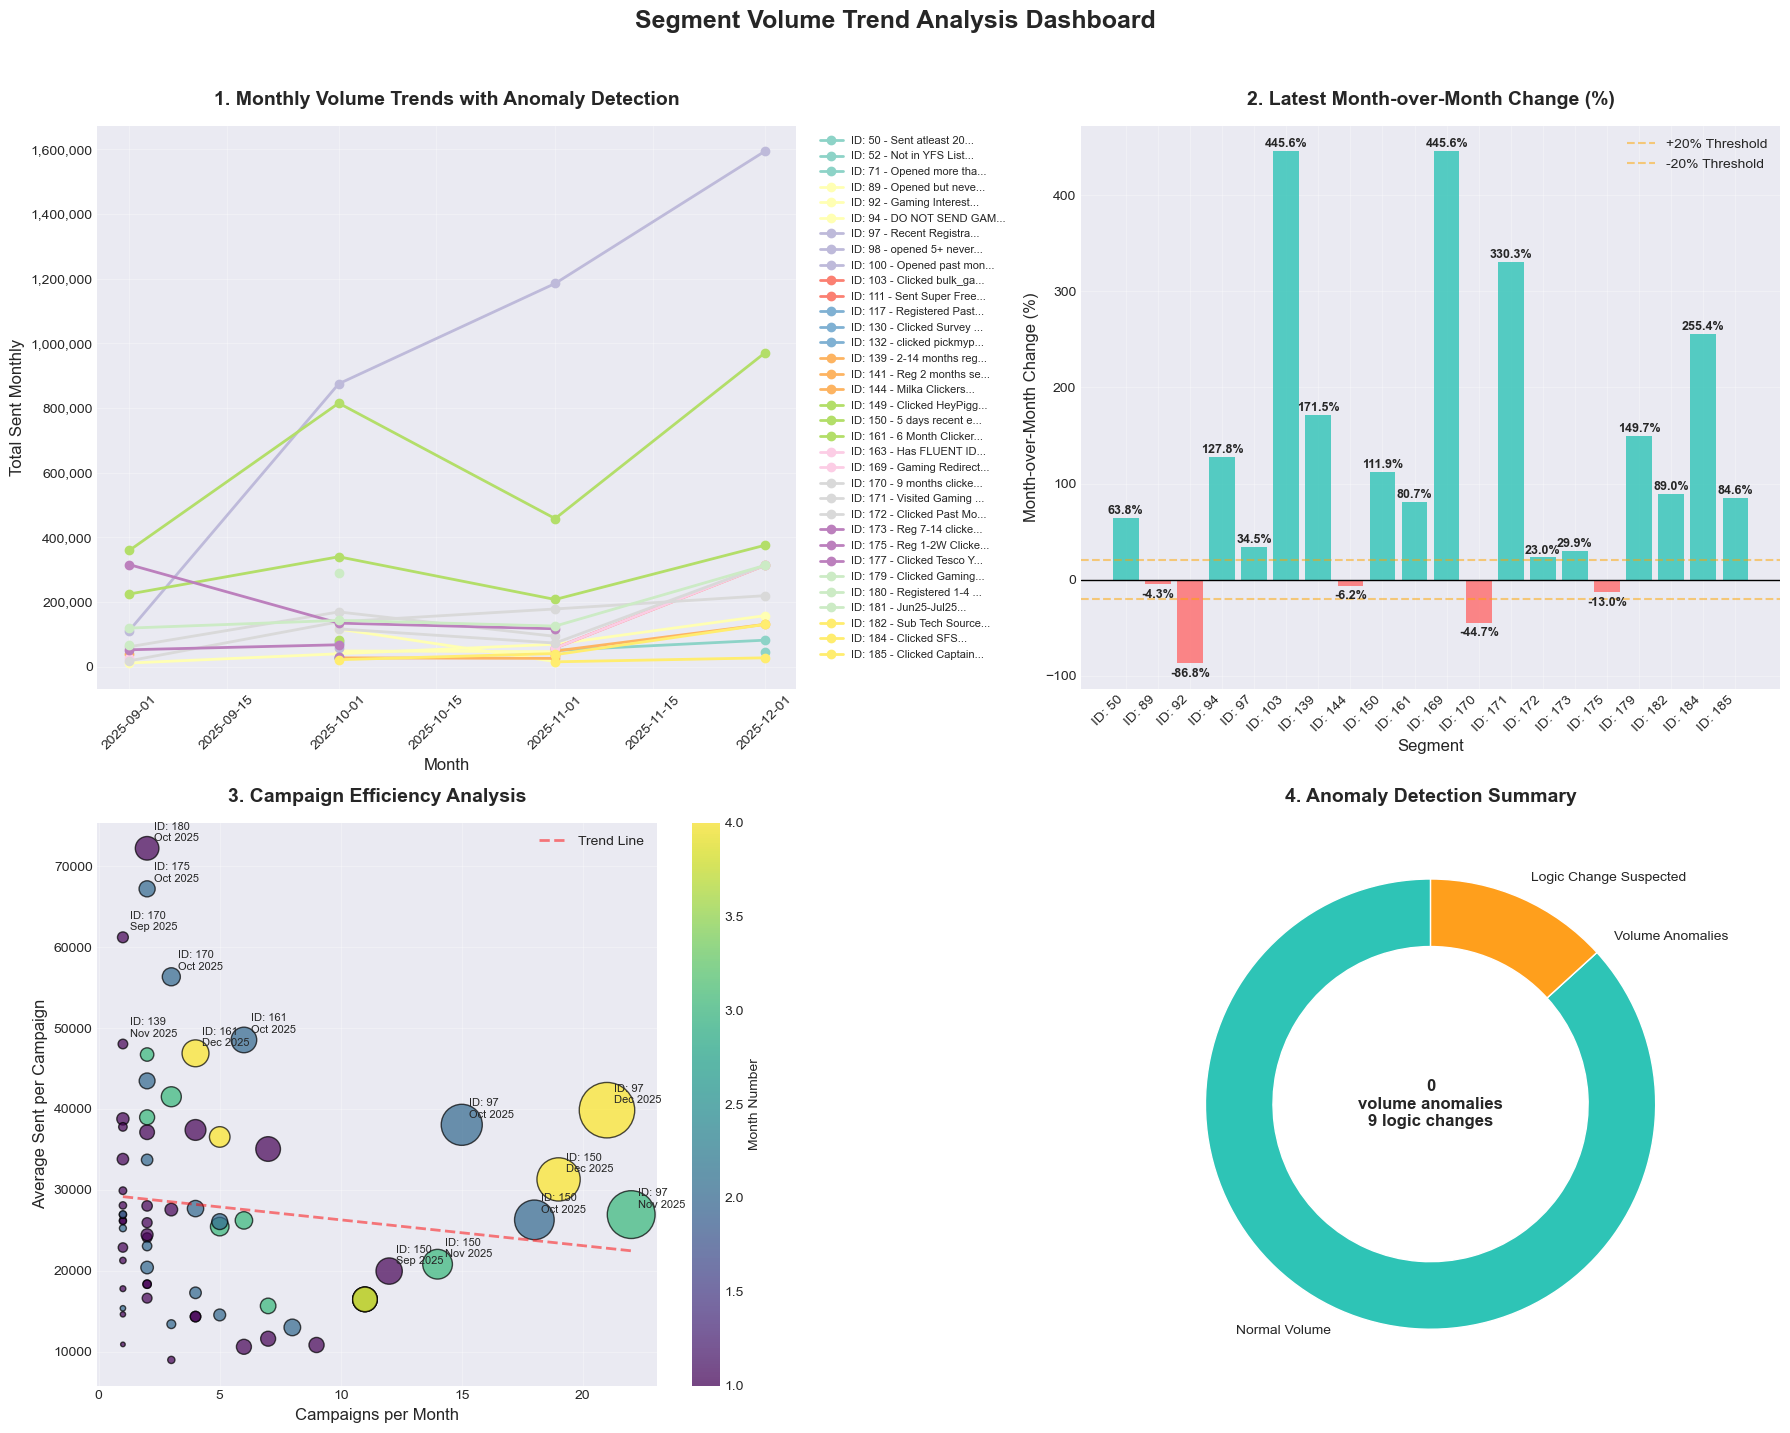


INDIVIDUAL SEGMENT TREND ANALYSIS


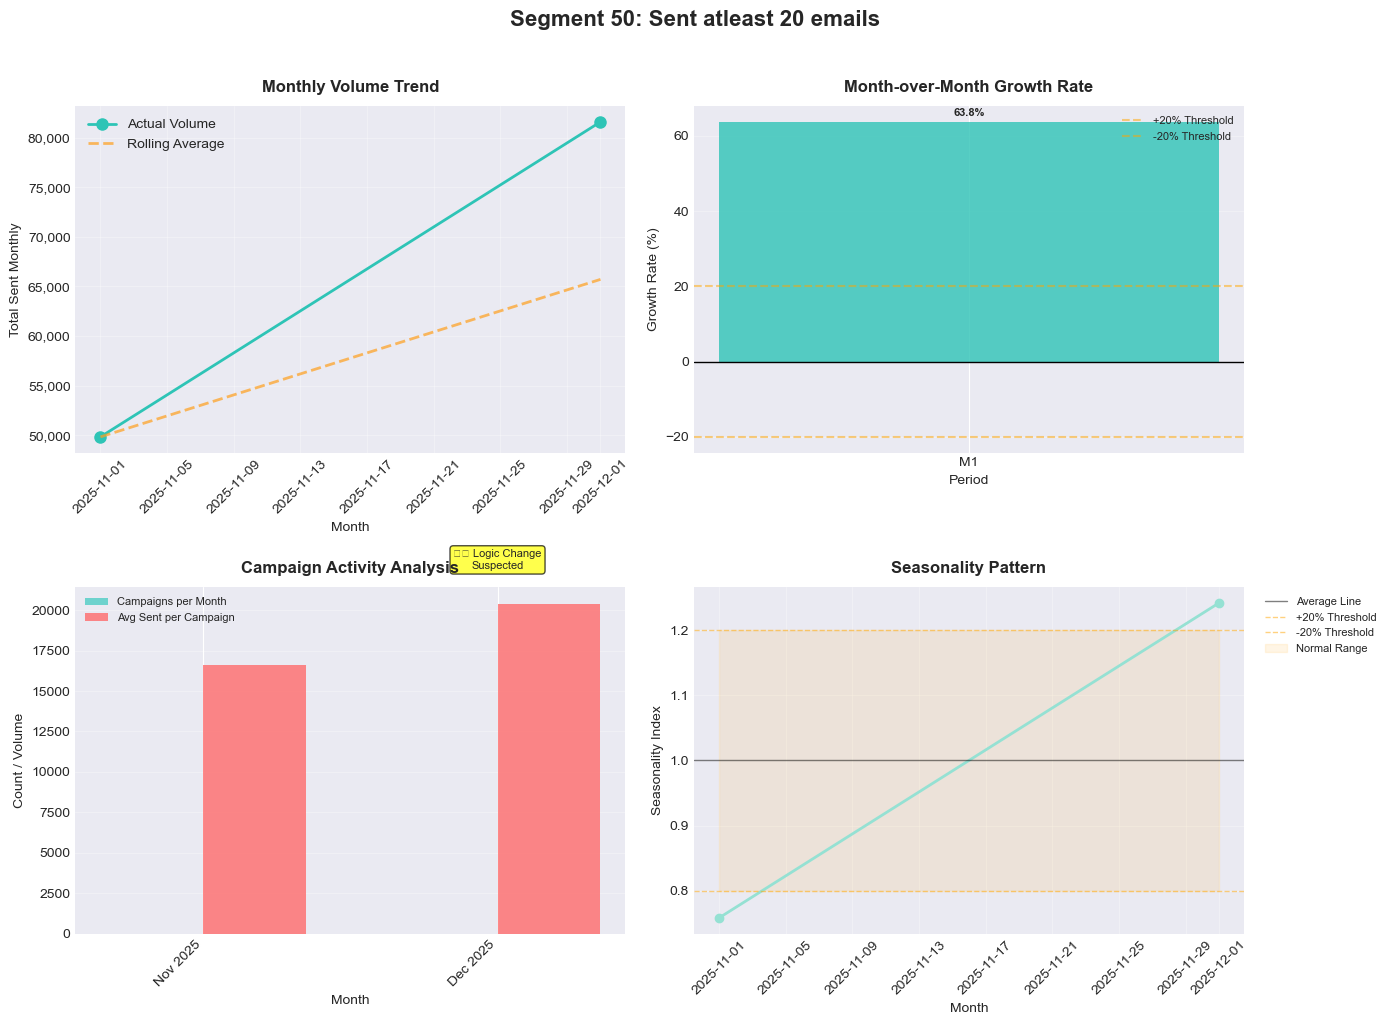


📊 SEGMENT 50: Sent atleast 20 emails
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 81,592
   • Campaigns: 2
   • Avg per Campaign: 20,398
   • MoM Change: 63.8%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by 22.8%
   • Overall Growth: 63.8%



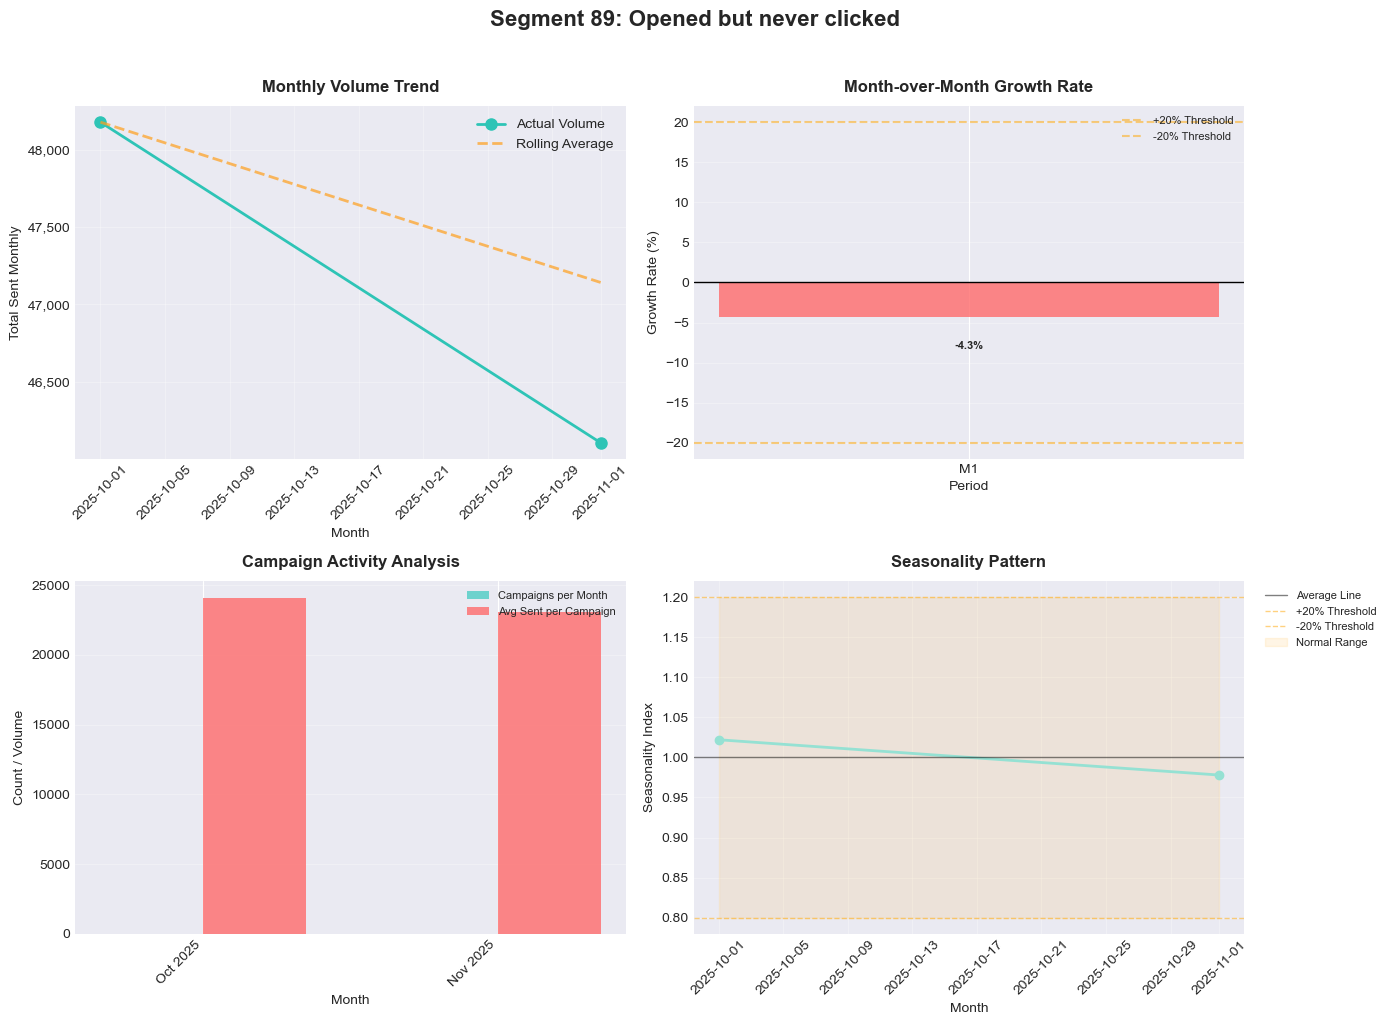


📊 SEGMENT 89: Opened but never clicked
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 46,104
   • Campaigns: 2
   • Avg per Campaign: 23,052
   • MoM Change: -4.3%
   • Overall Growth: -4.3%



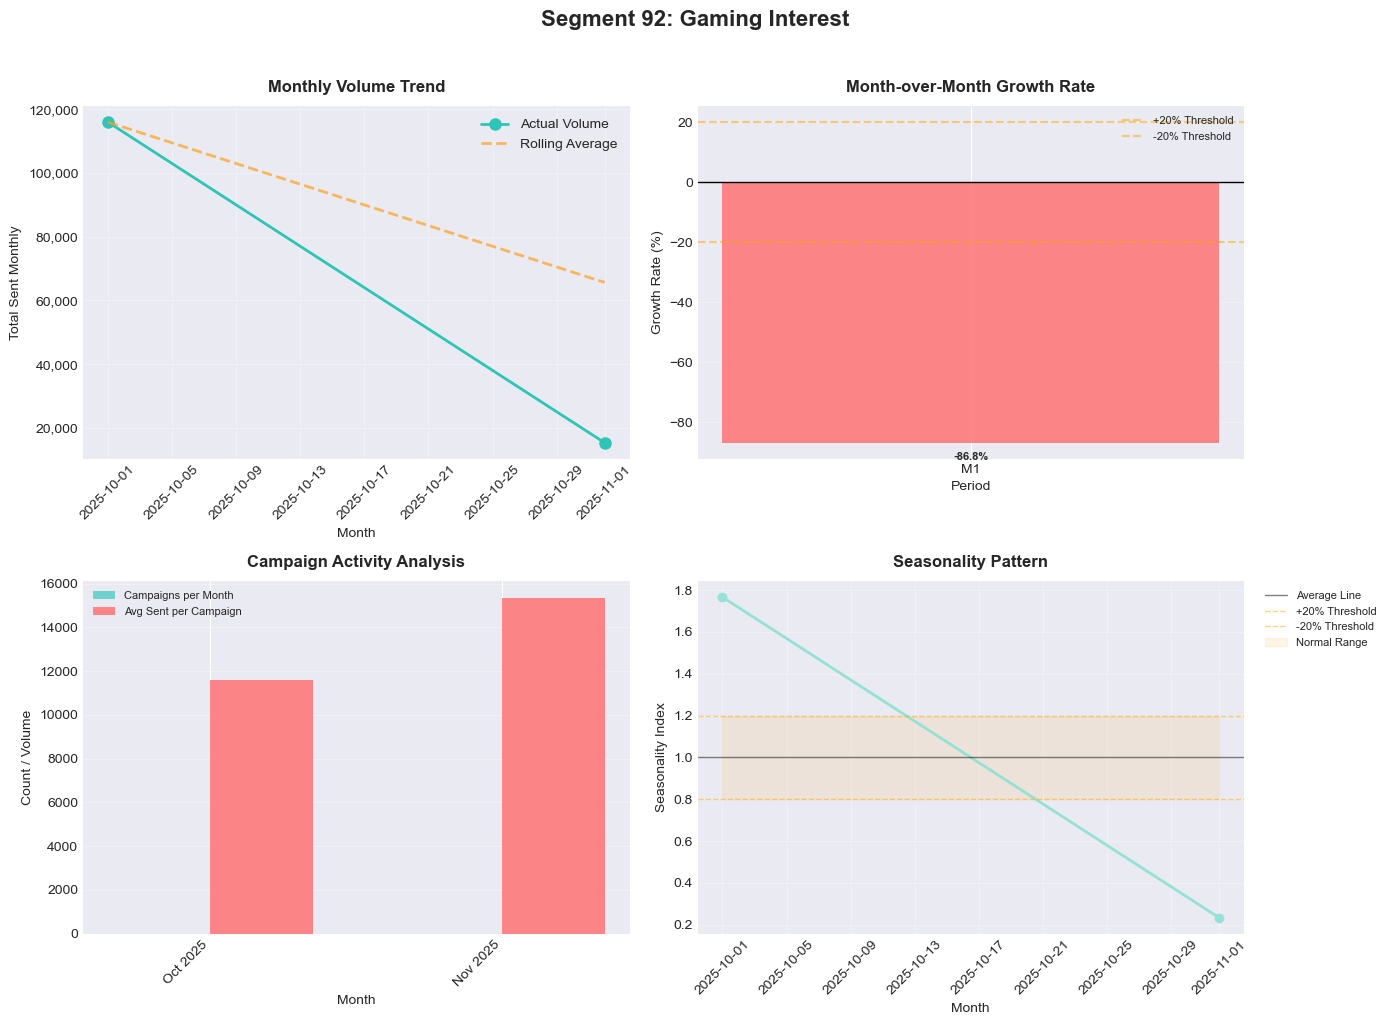


📊 SEGMENT 92: Gaming Interest
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 15,355
   • Campaigns: 1
   • Avg per Campaign: 15,355
   • MoM Change: -86.8%
   • Overall Growth: -86.8%



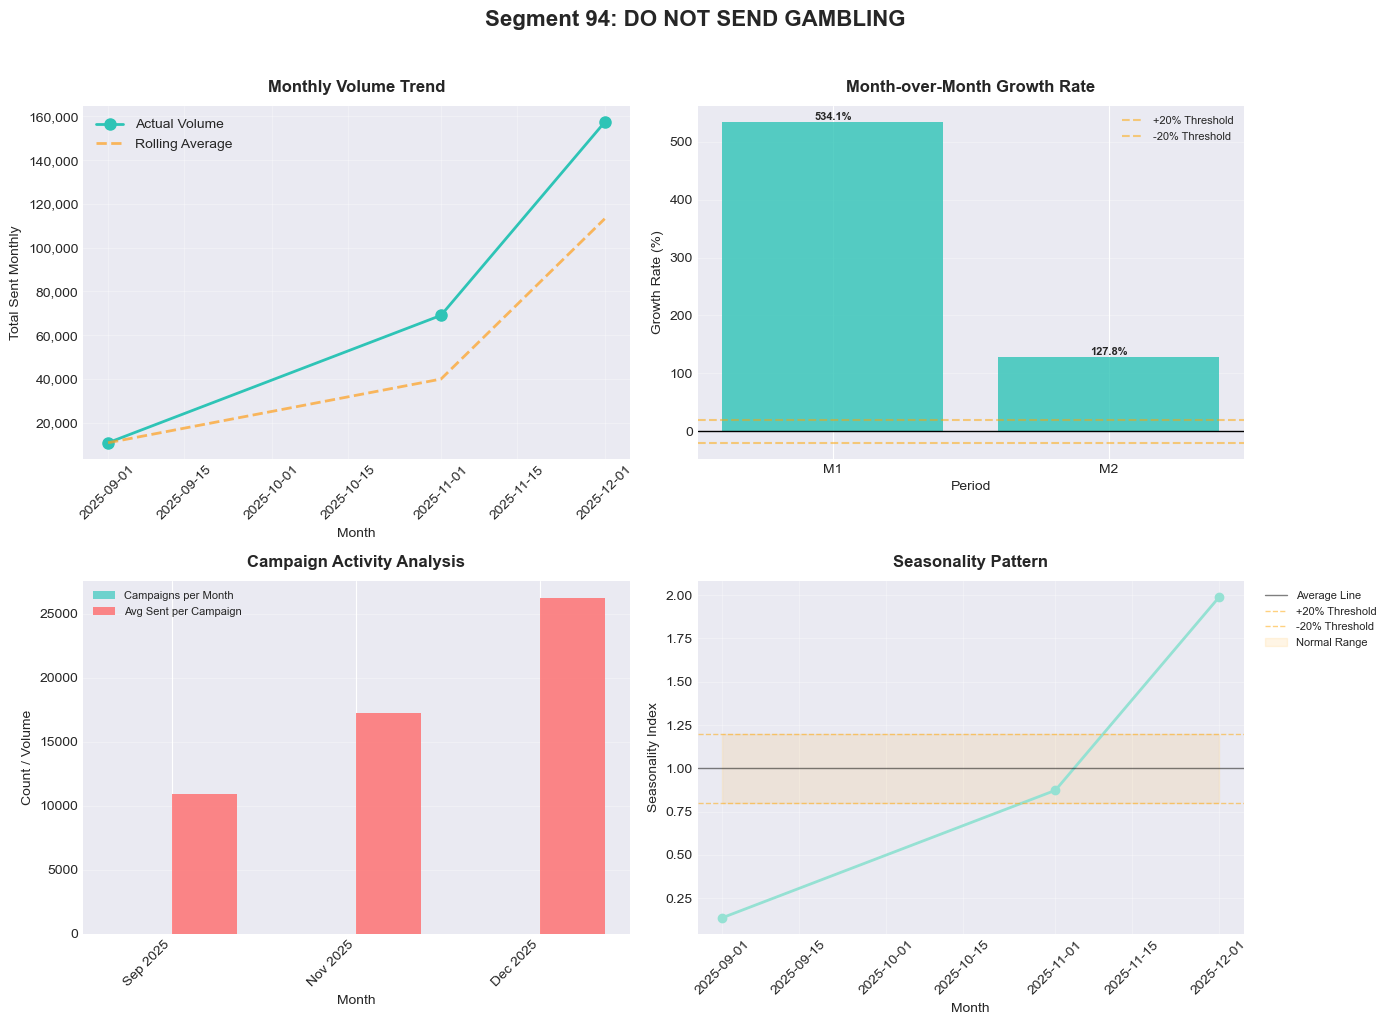


📊 SEGMENT 94: DO NOT SEND GAMBLING
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 157,339
   • Campaigns: 6
   • Avg per Campaign: 26,223
   • MoM Change: 127.8%
   • Overall Growth: 1344.3%



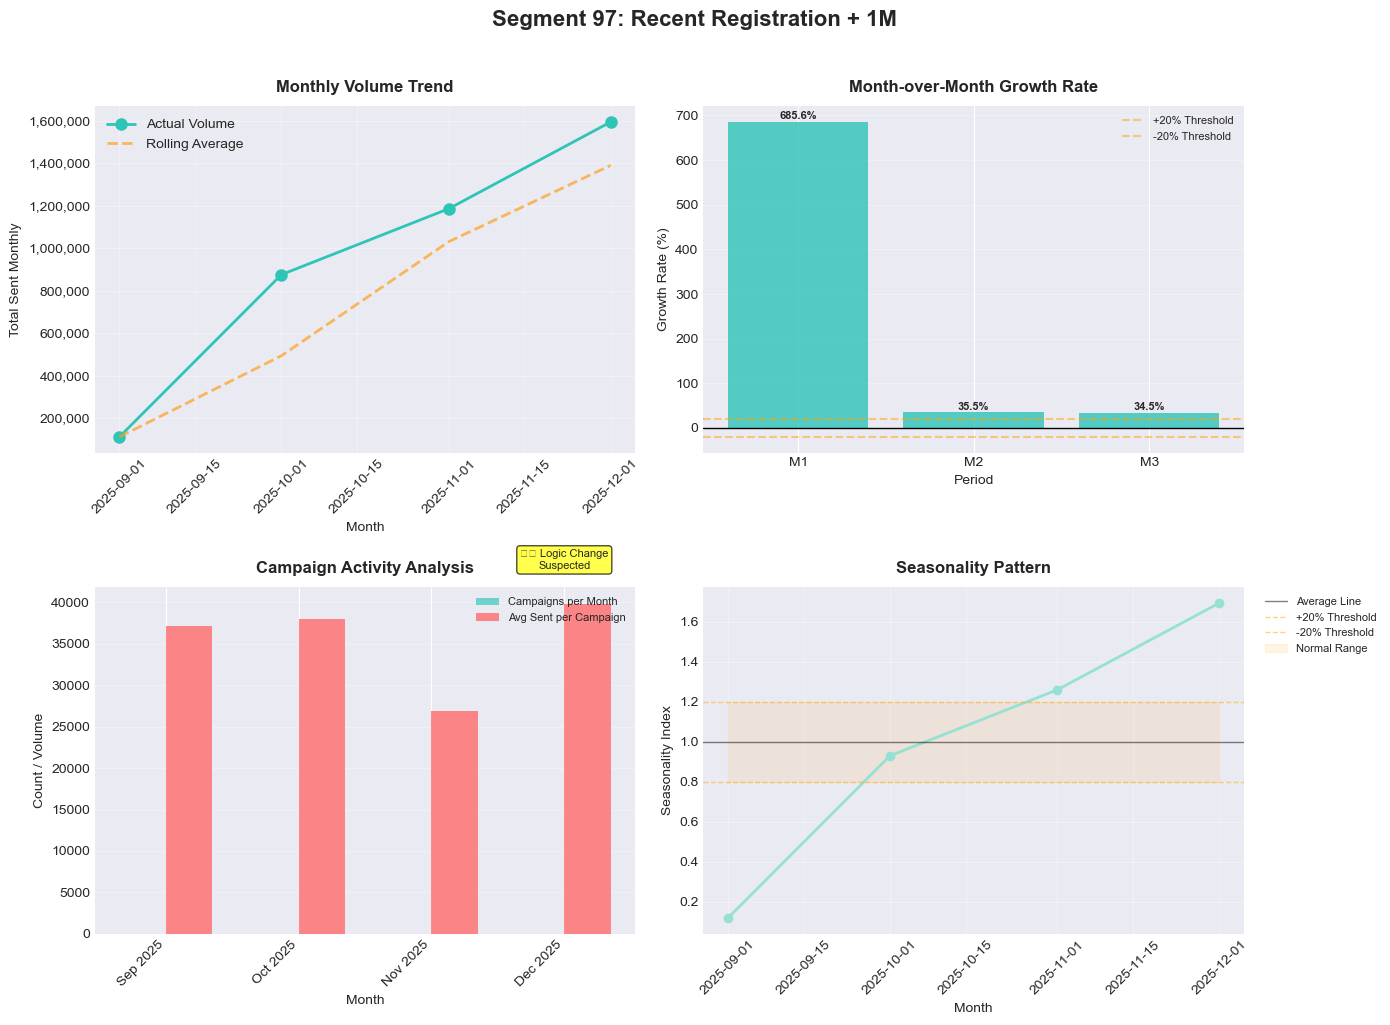


📊 SEGMENT 97: Recent Registration + 1M
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 1,593,938
   • Campaigns: 21
   • Avg per Campaign: 39,848
   • MoM Change: 34.5%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by 47.9%
   • Overall Growth: 1331.2%



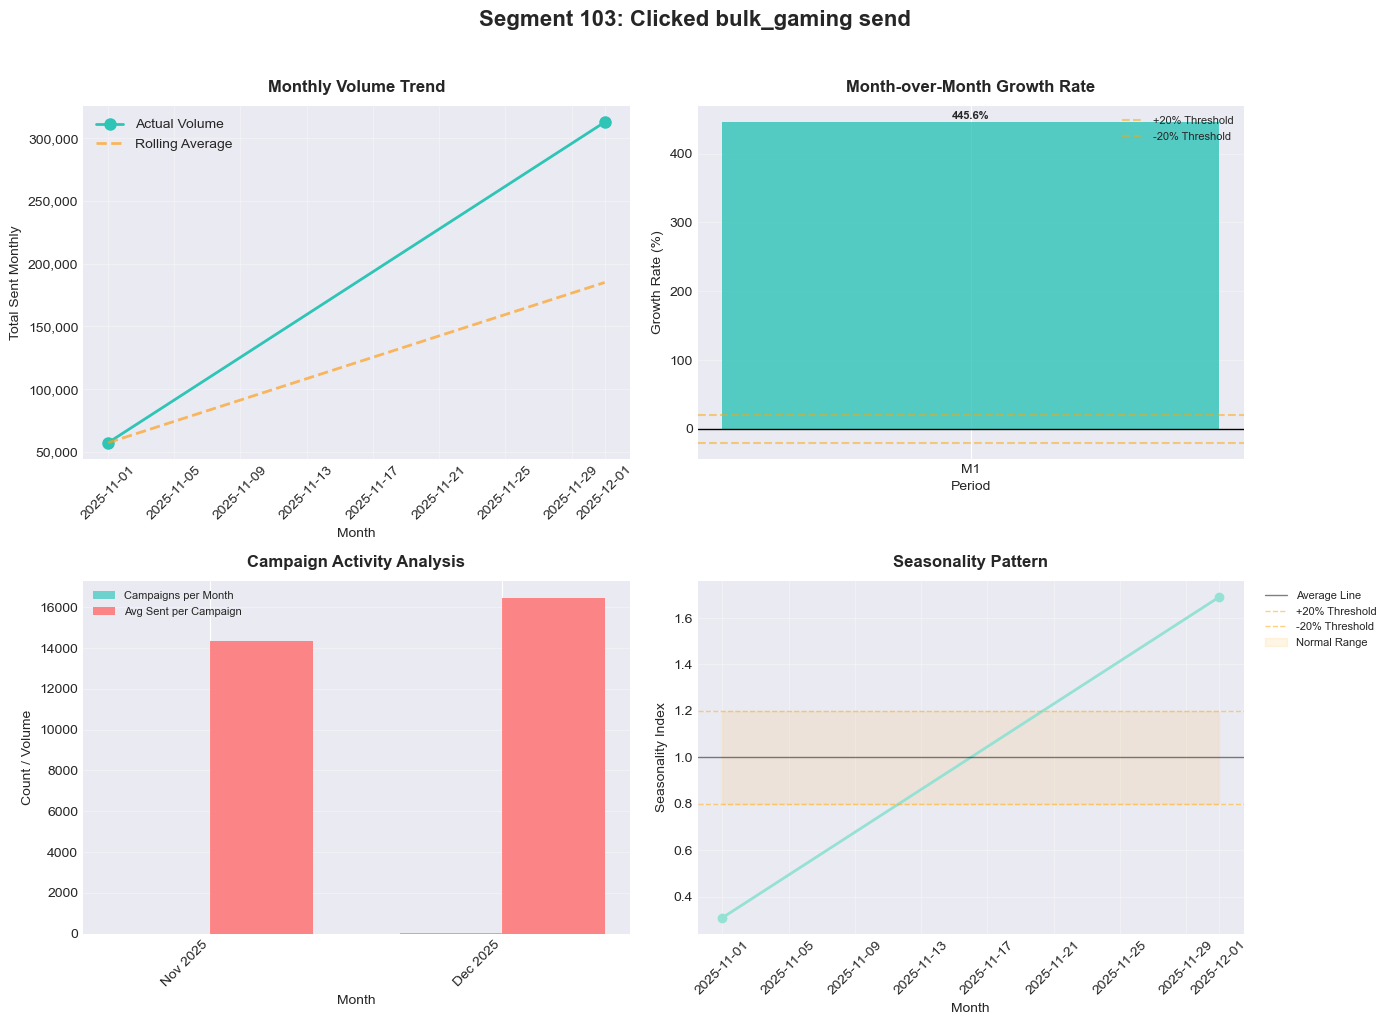


📊 SEGMENT 103: Clicked bulk_gaming send
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 312,716
   • Campaigns: 11
   • Avg per Campaign: 16,459
   • MoM Change: 445.6%
   • Overall Growth: 445.6%



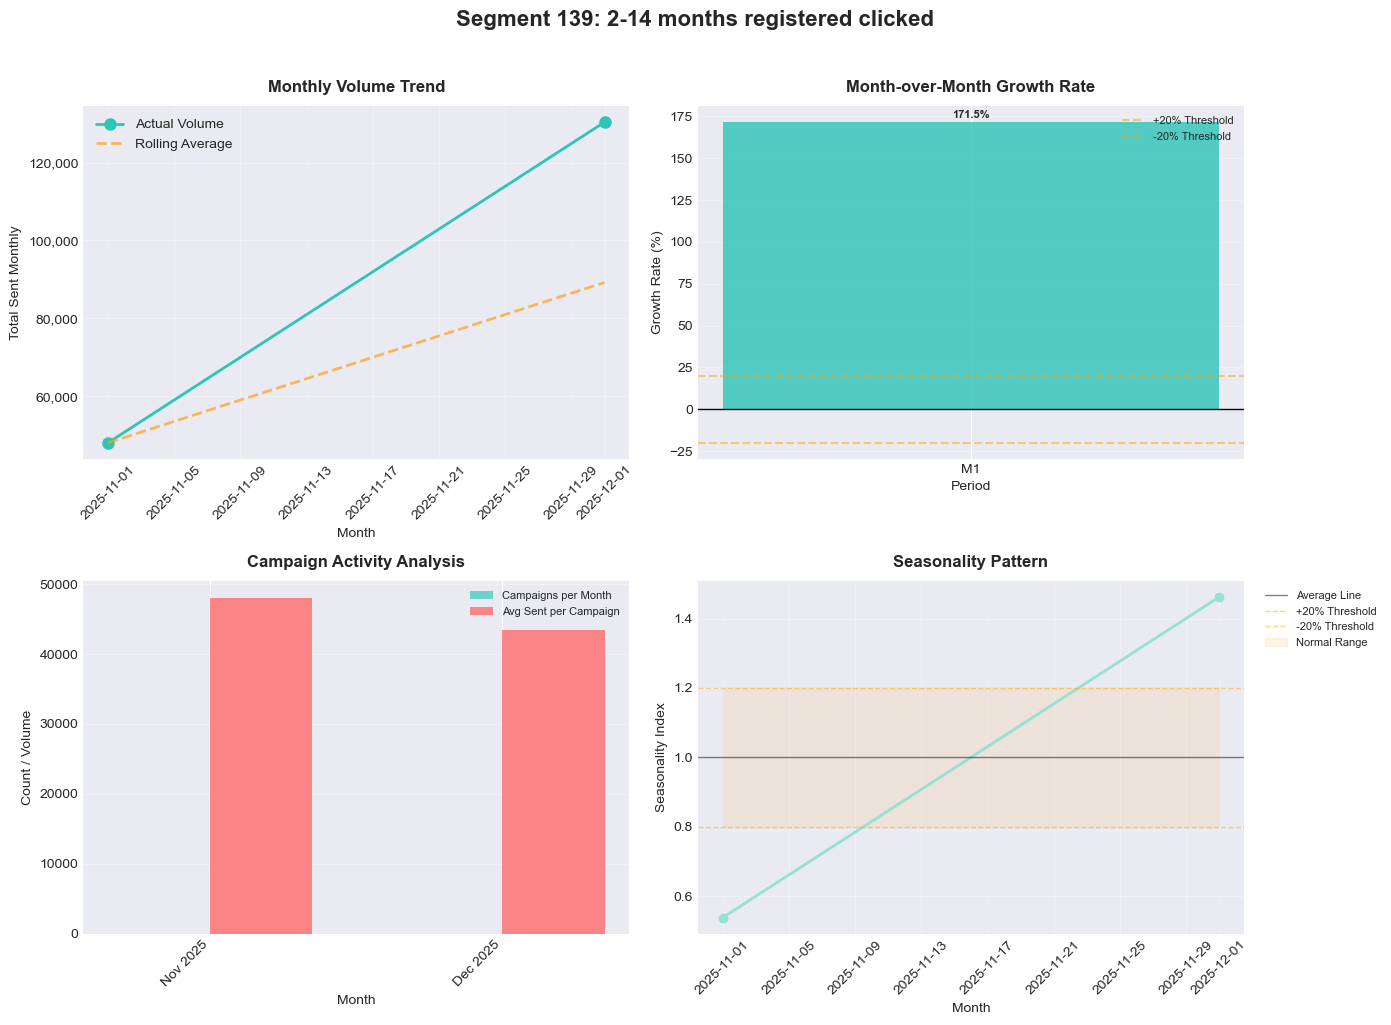


📊 SEGMENT 139: 2-14 months registered clicked
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 130,403
   • Campaigns: 2
   • Avg per Campaign: 43,468
   • MoM Change: 171.5%
   • Overall Growth: 171.5%



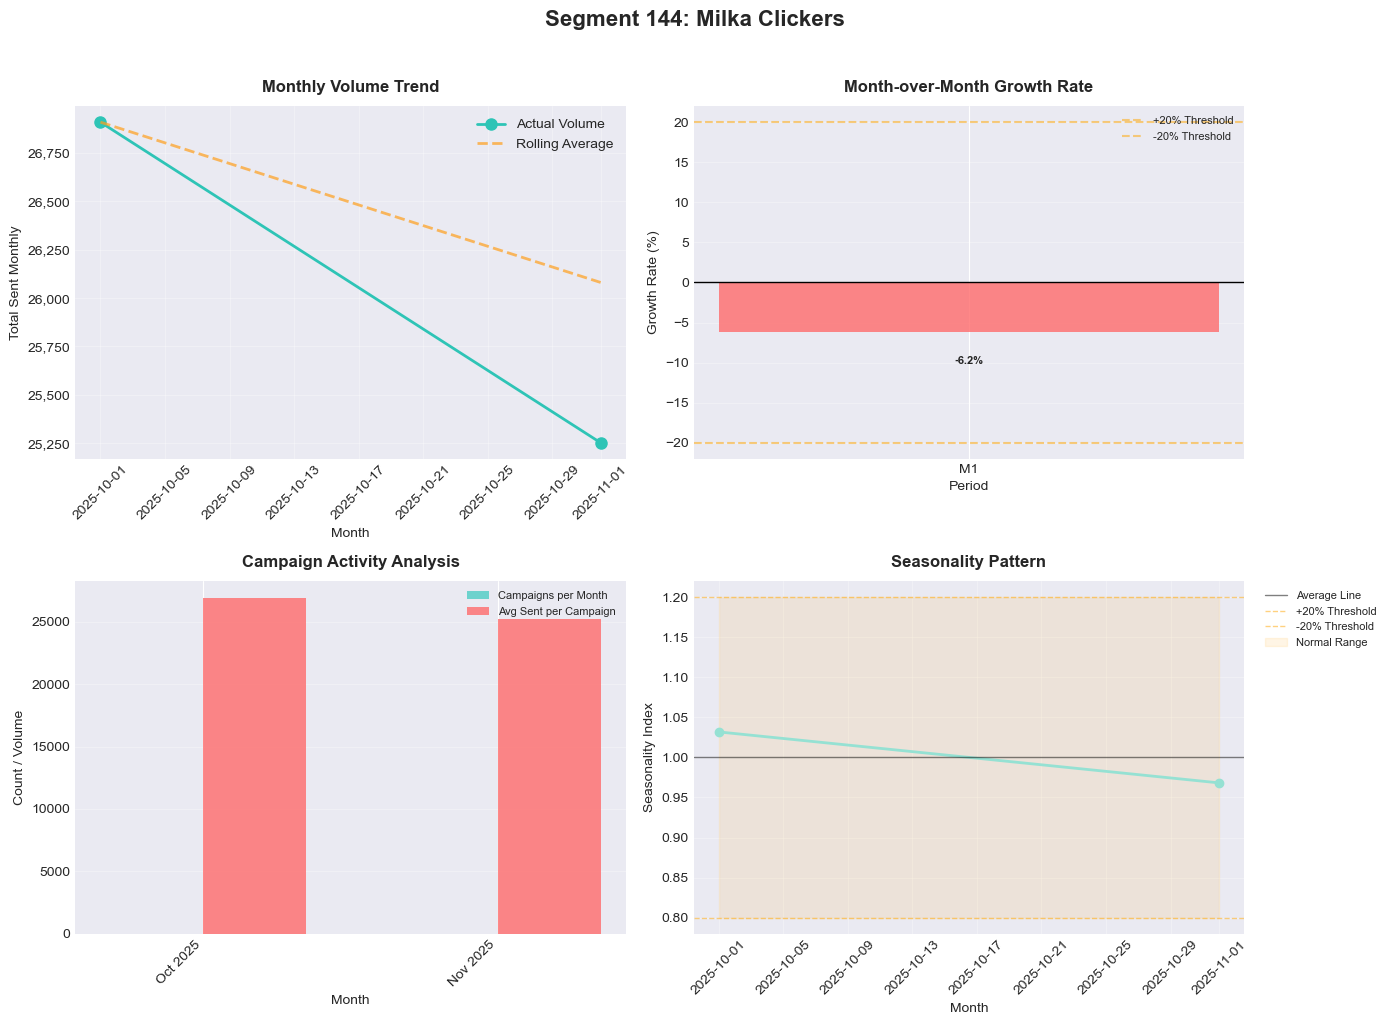


📊 SEGMENT 144: Milka Clickers
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 25,252
   • Campaigns: 1
   • Avg per Campaign: 25,252
   • MoM Change: -6.2%
   • Overall Growth: -6.2%



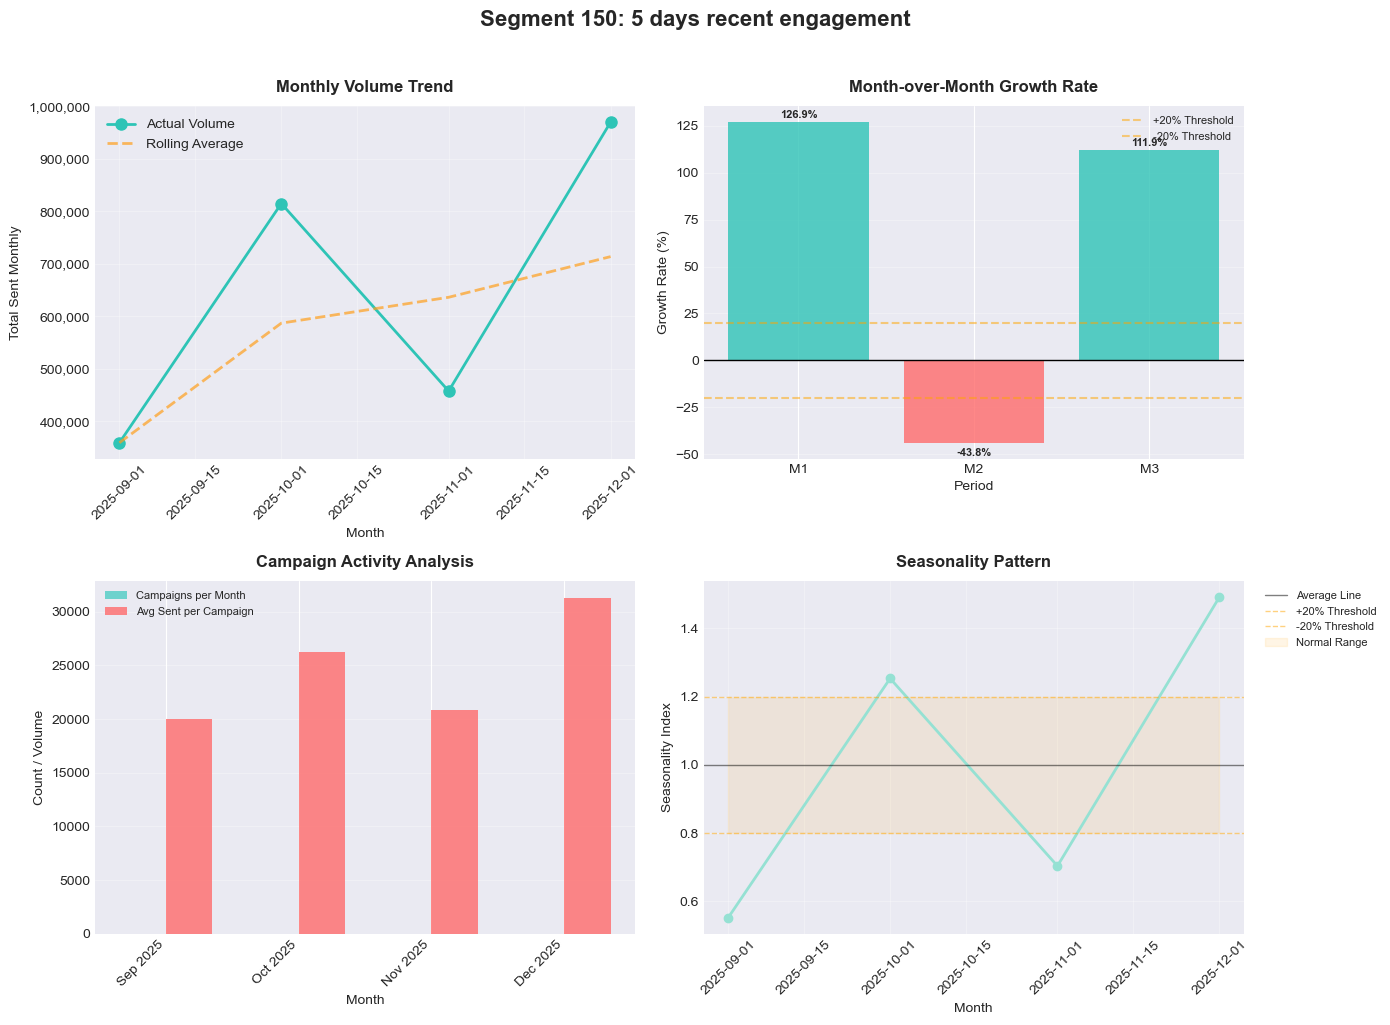


📊 SEGMENT 150: 5 days recent engagement
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 969,988
   • Campaigns: 19
   • Avg per Campaign: 31,290
   • MoM Change: 111.9%
   • Overall Growth: 170.0%



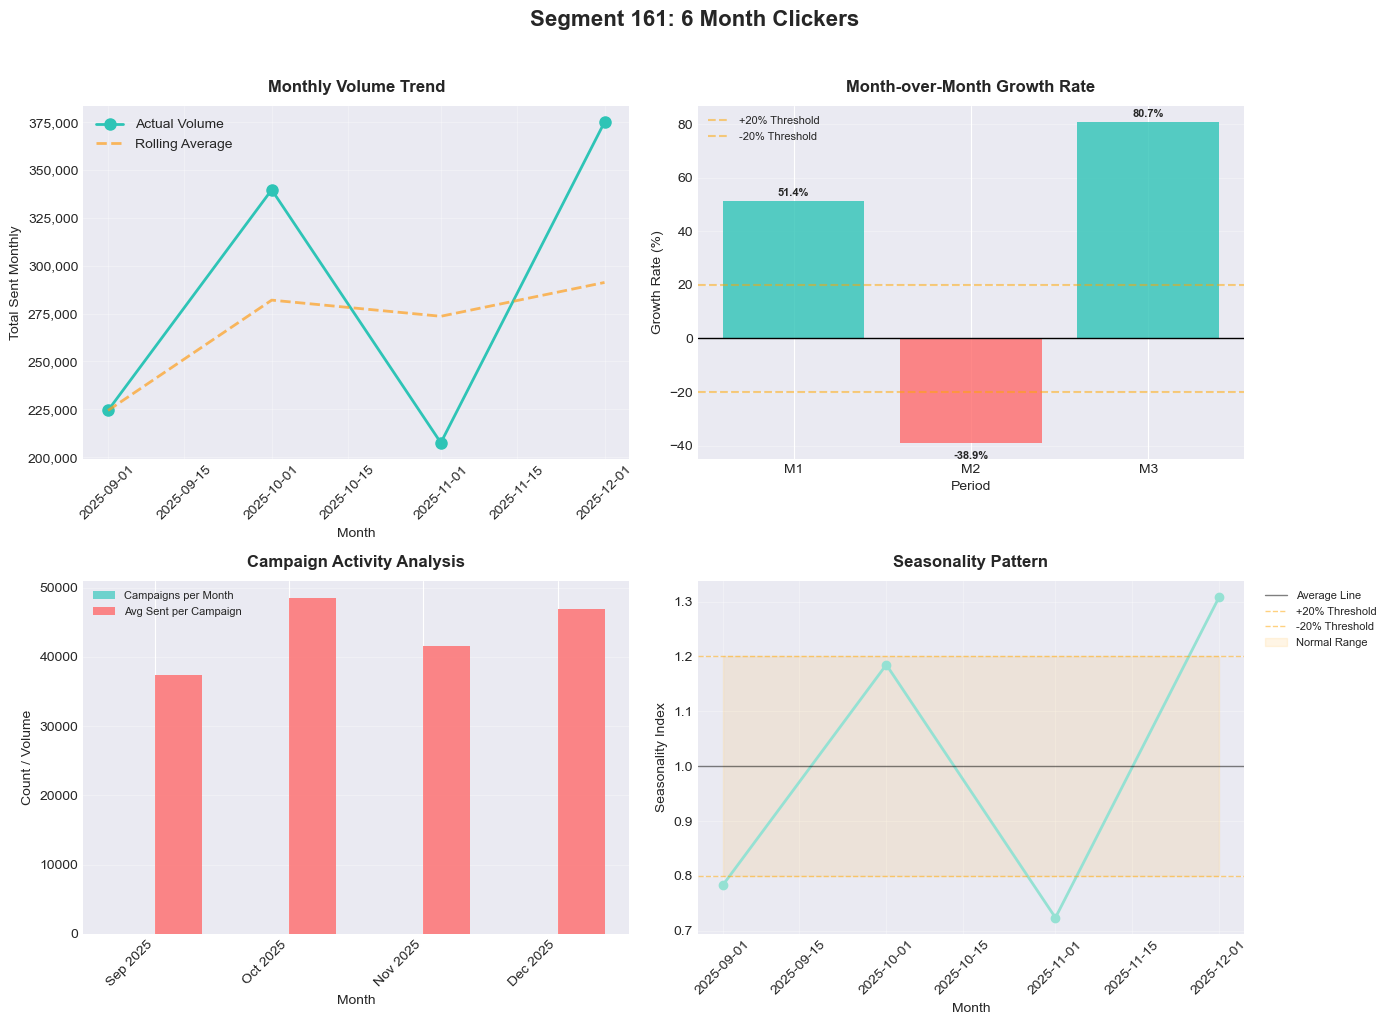


📊 SEGMENT 161: 6 Month Clickers
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 375,032
   • Campaigns: 4
   • Avg per Campaign: 46,879
   • MoM Change: 80.7%
   • Overall Growth: 67.1%



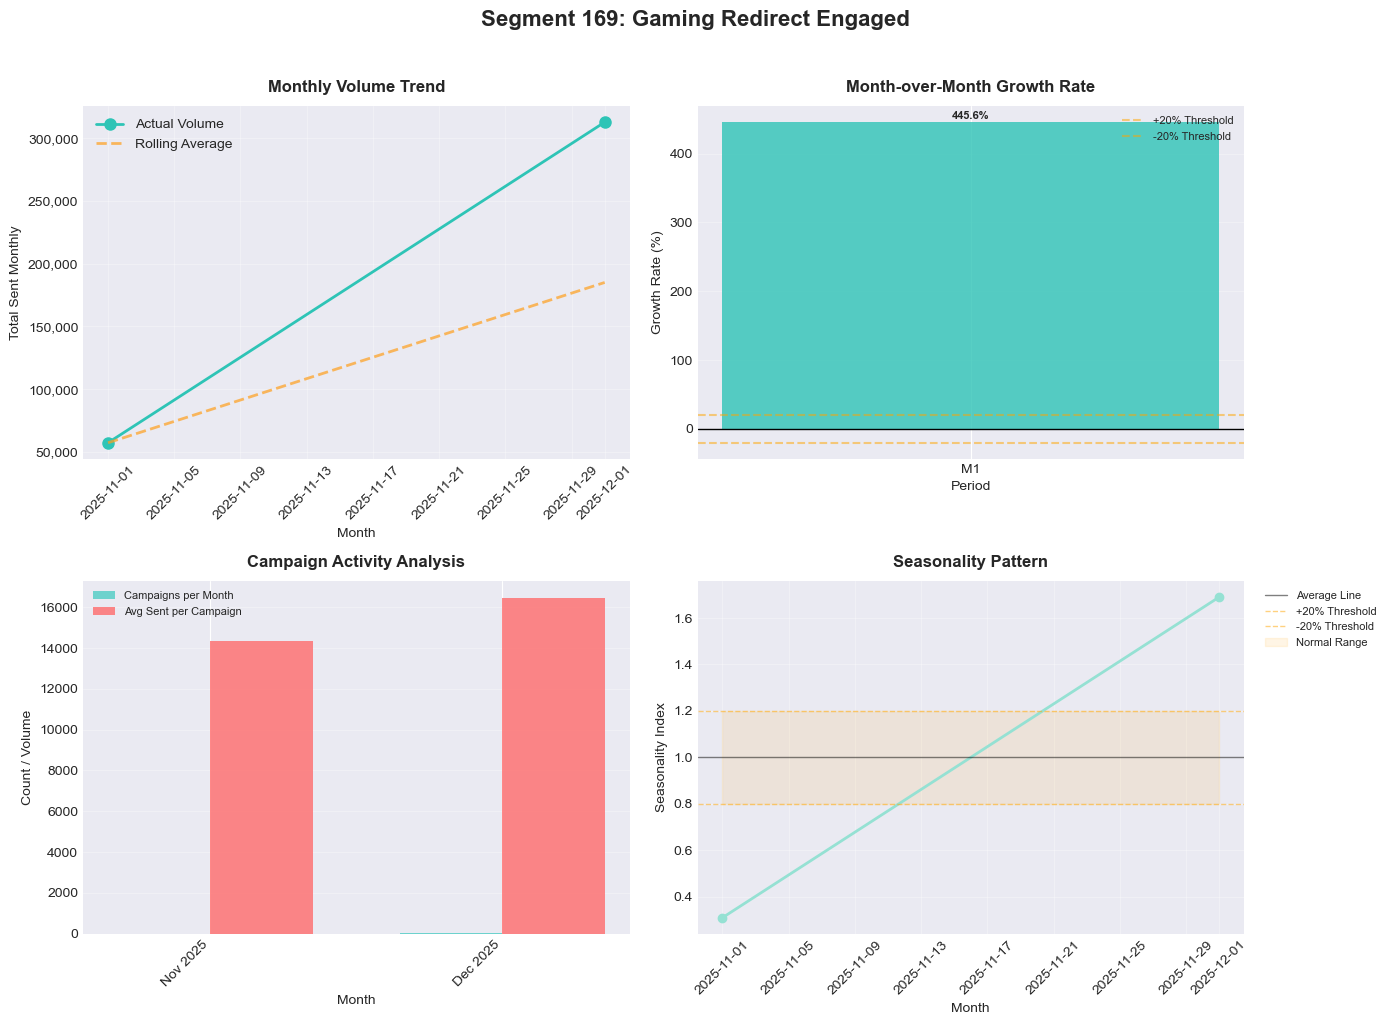


📊 SEGMENT 169: Gaming Redirect Engaged
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 312,716
   • Campaigns: 11
   • Avg per Campaign: 16,459
   • MoM Change: 445.6%
   • Overall Growth: 445.6%



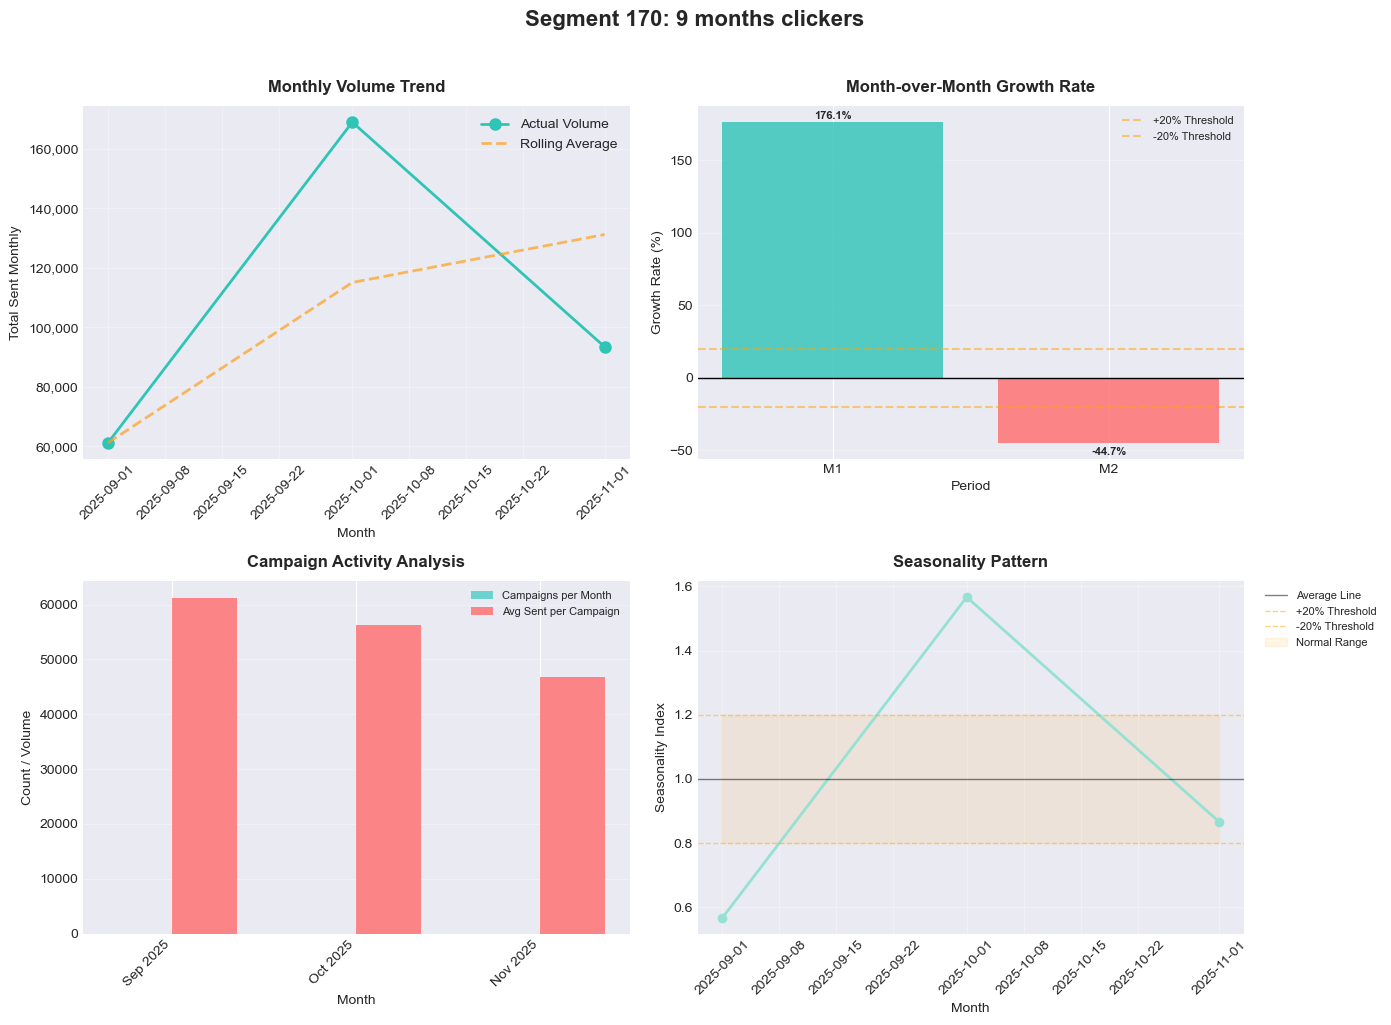


📊 SEGMENT 170: 9 months clickers
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 93,456
   • Campaigns: 2
   • Avg per Campaign: 46,728
   • MoM Change: -44.7%
   • Overall Growth: 52.7%



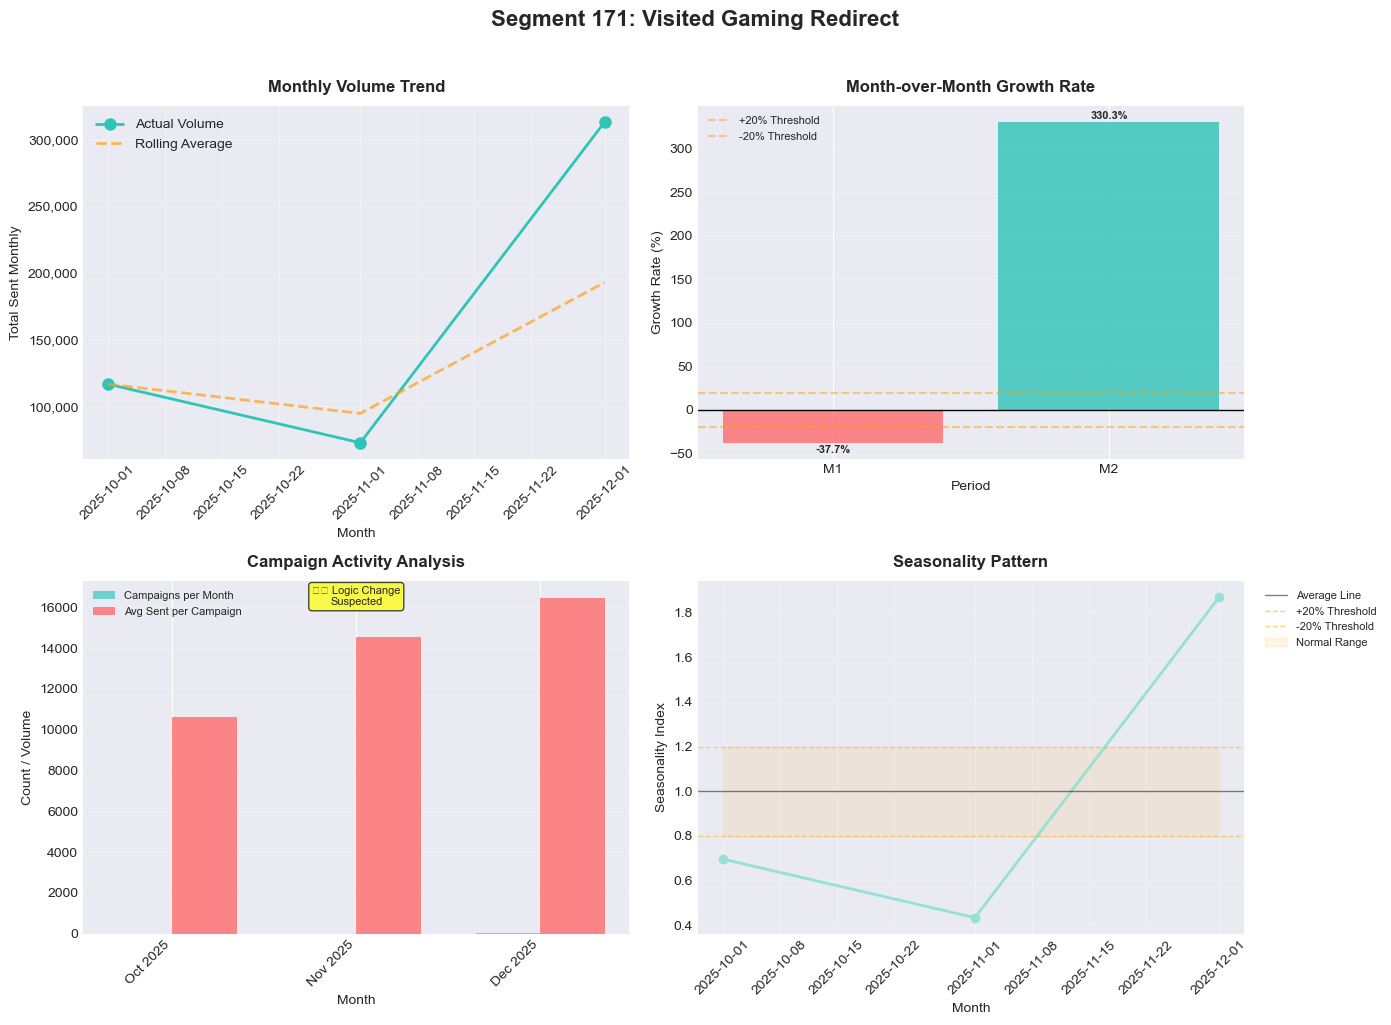


📊 SEGMENT 171: Visited Gaming Redirect
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 312,716
   • Campaigns: 11
   • Avg per Campaign: 16,459
   • MoM Change: 330.3%
   • Overall Growth: 168.2%



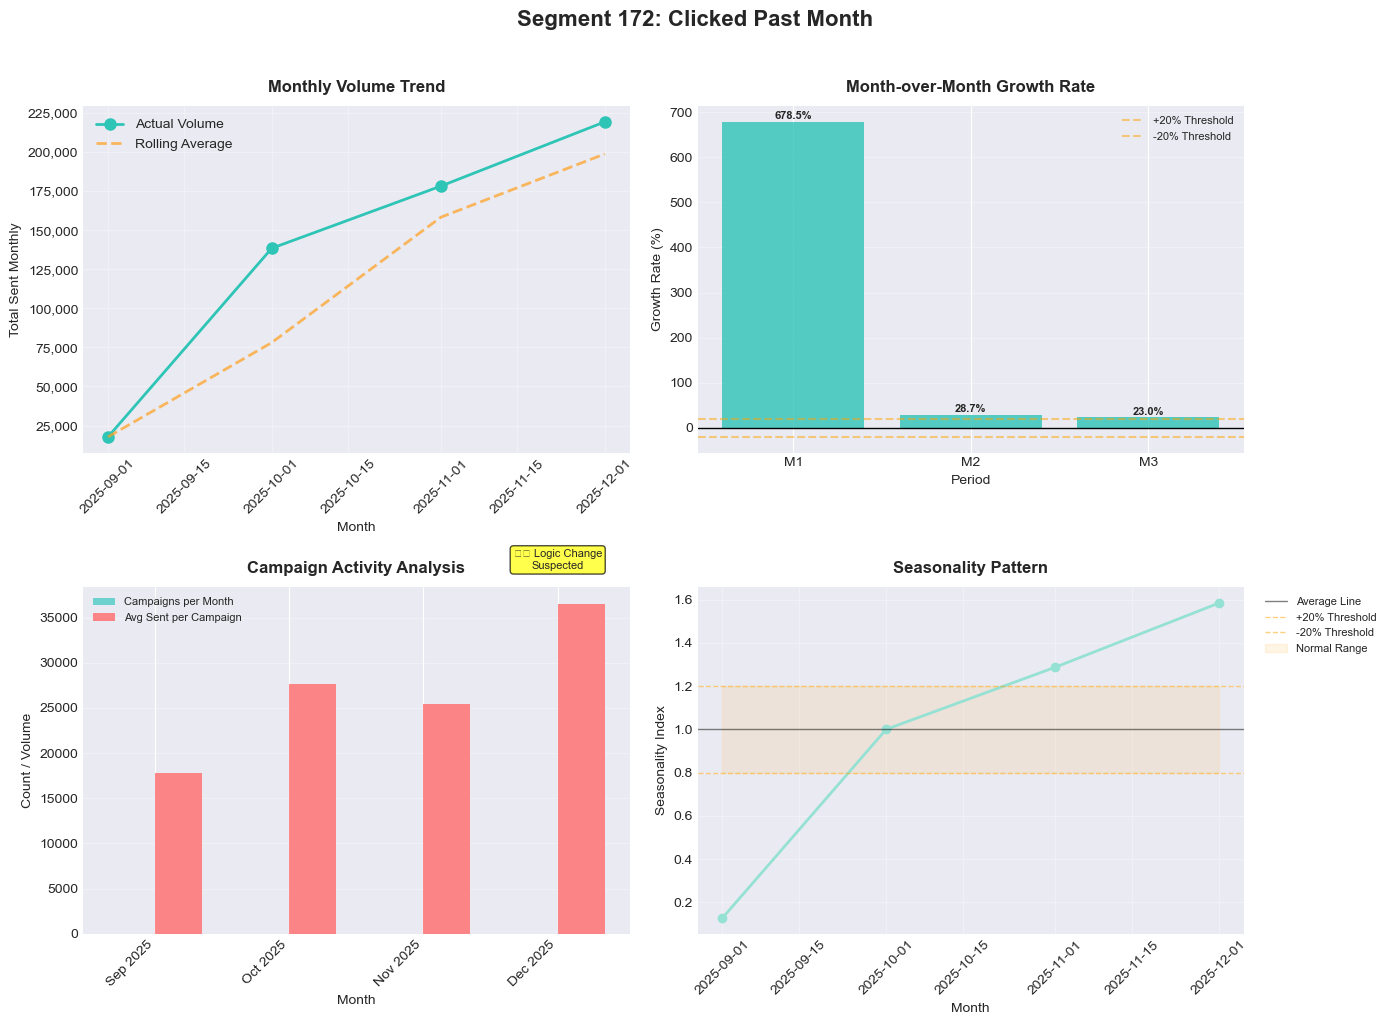


📊 SEGMENT 172: Clicked Past Month
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 219,236
   • Campaigns: 5
   • Avg per Campaign: 36,539
   • MoM Change: 23.0%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by 43.5%
   • Overall Growth: 1133.1%



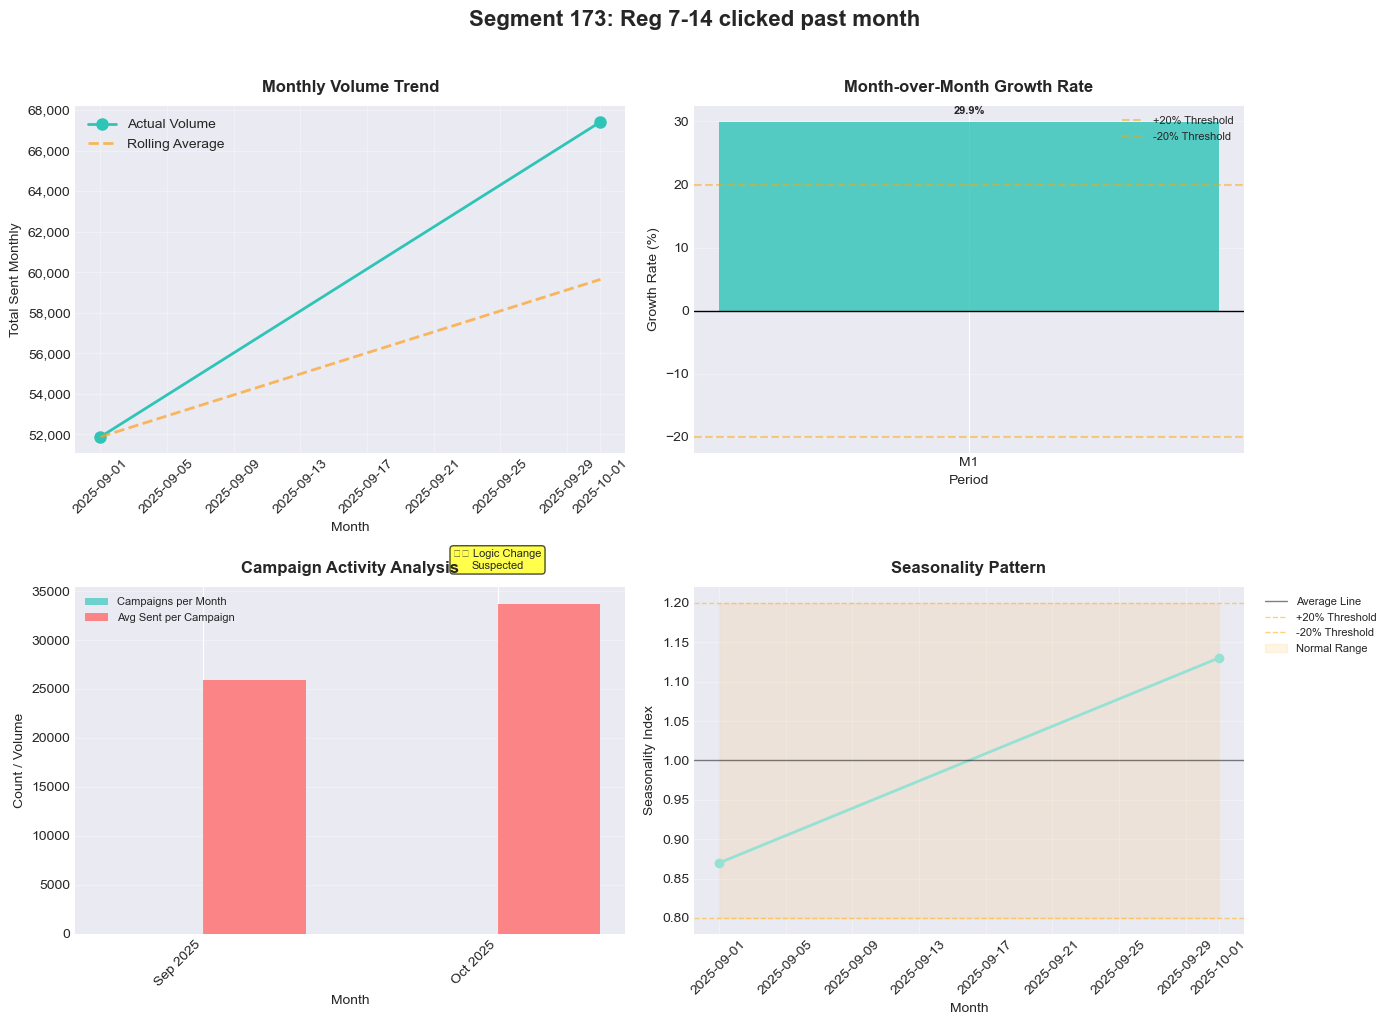


📊 SEGMENT 173: Reg 7-14 clicked past month
------------------------------------------------------------
   • Latest Month: Oct 2025
   • Total Sent: 67,413
   • Campaigns: 2
   • Avg per Campaign: 33,706
   • MoM Change: 29.9%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by 29.9%
   • Overall Growth: 29.9%



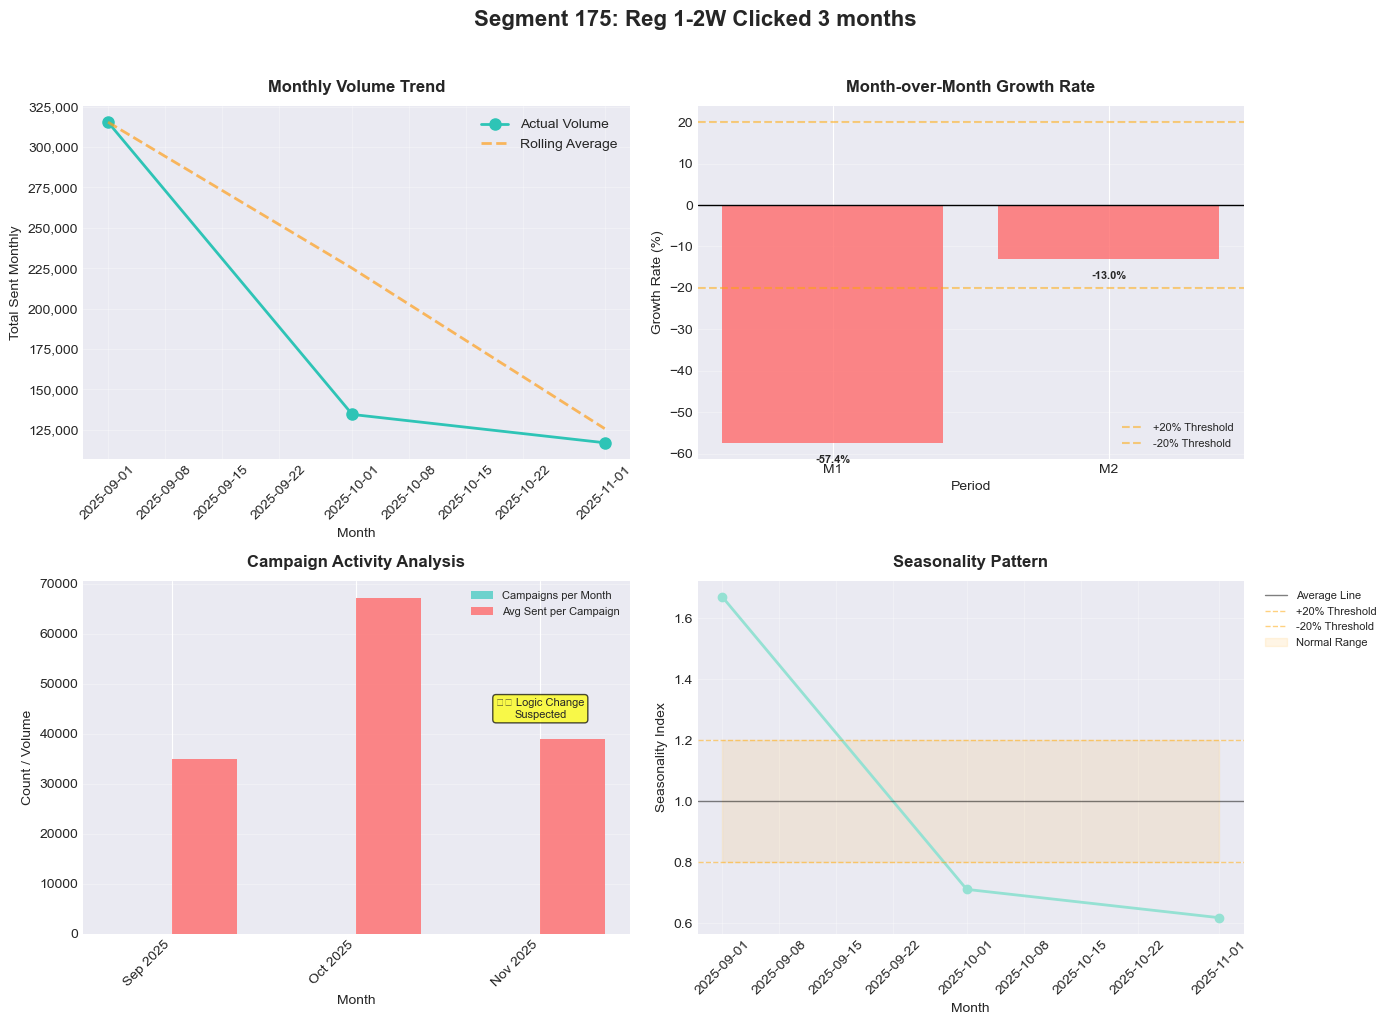


📊 SEGMENT 175: Reg 1-2W Clicked 3 months
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 116,897
   • Campaigns: 2
   • Avg per Campaign: 38,966
   • MoM Change: -13.0%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by -42.0%
   • Overall Growth: -62.9%



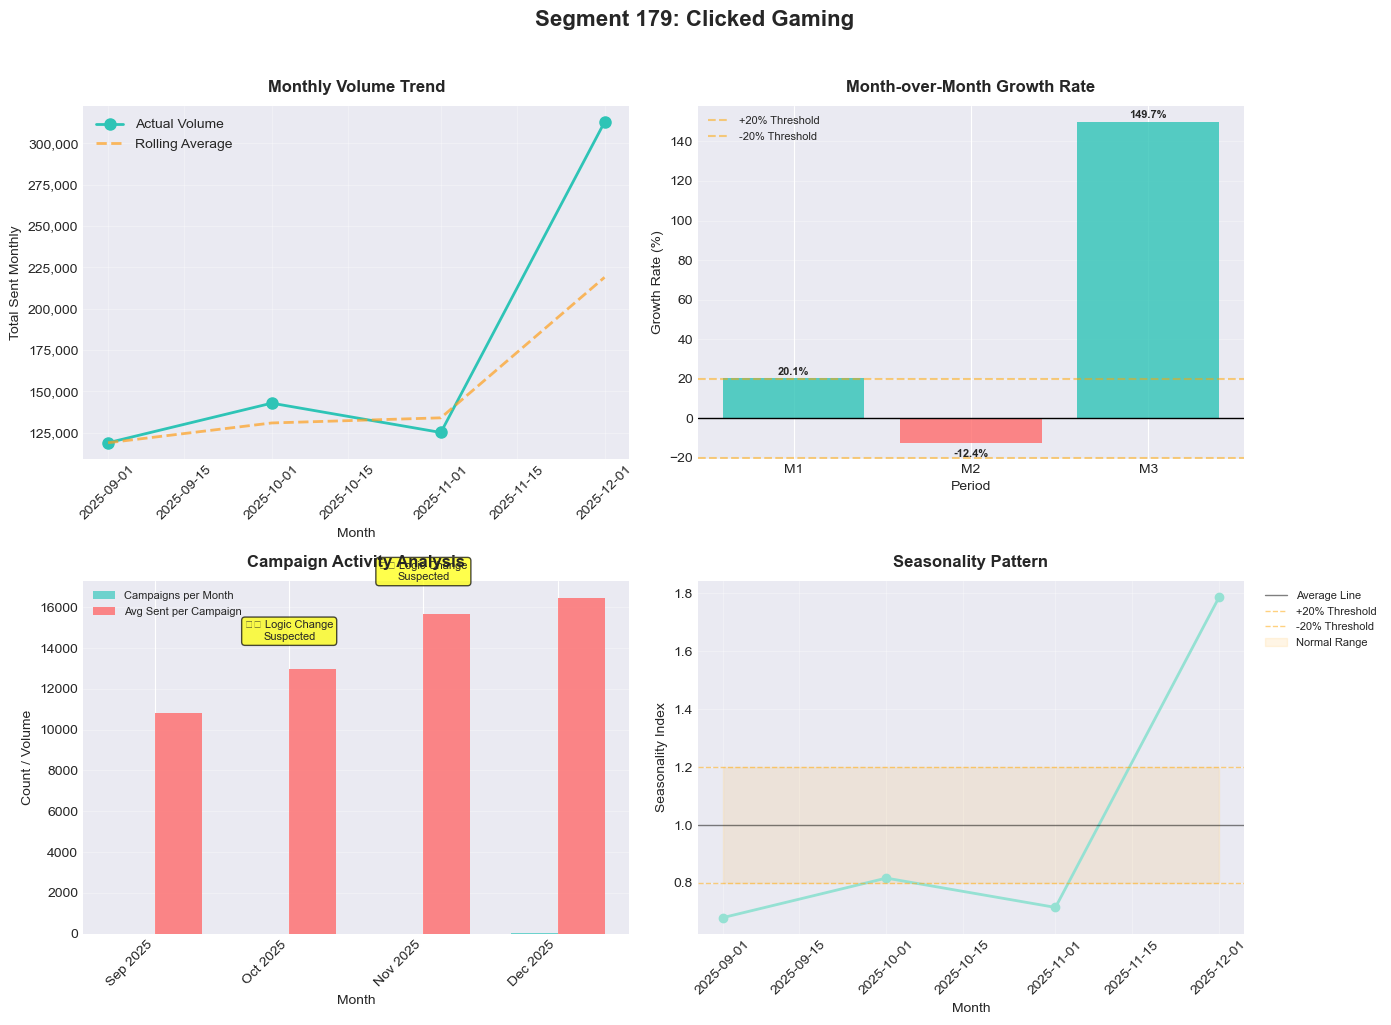


📊 SEGMENT 179: Clicked Gaming
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 312,716
   • Campaigns: 11
   • Avg per Campaign: 16,459
   • MoM Change: 149.7%
   • Overall Growth: 162.8%



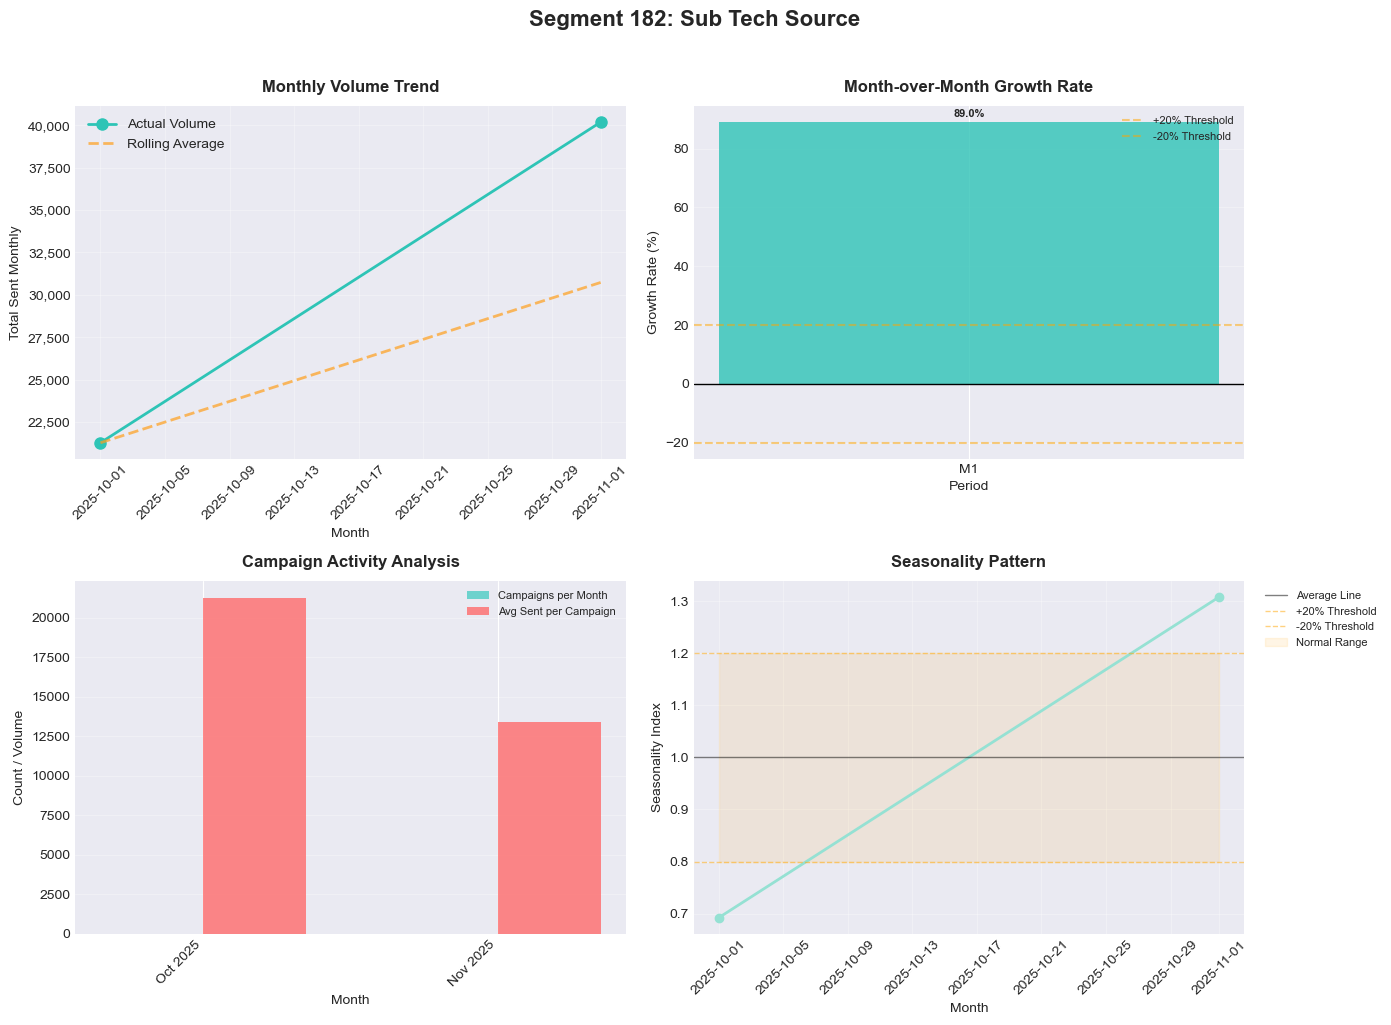


📊 SEGMENT 182: Sub Tech Source
------------------------------------------------------------
   • Latest Month: Nov 2025
   • Total Sent: 40,190
   • Campaigns: 3
   • Avg per Campaign: 13,397
   • MoM Change: 89.0%
   • Overall Growth: 89.0%



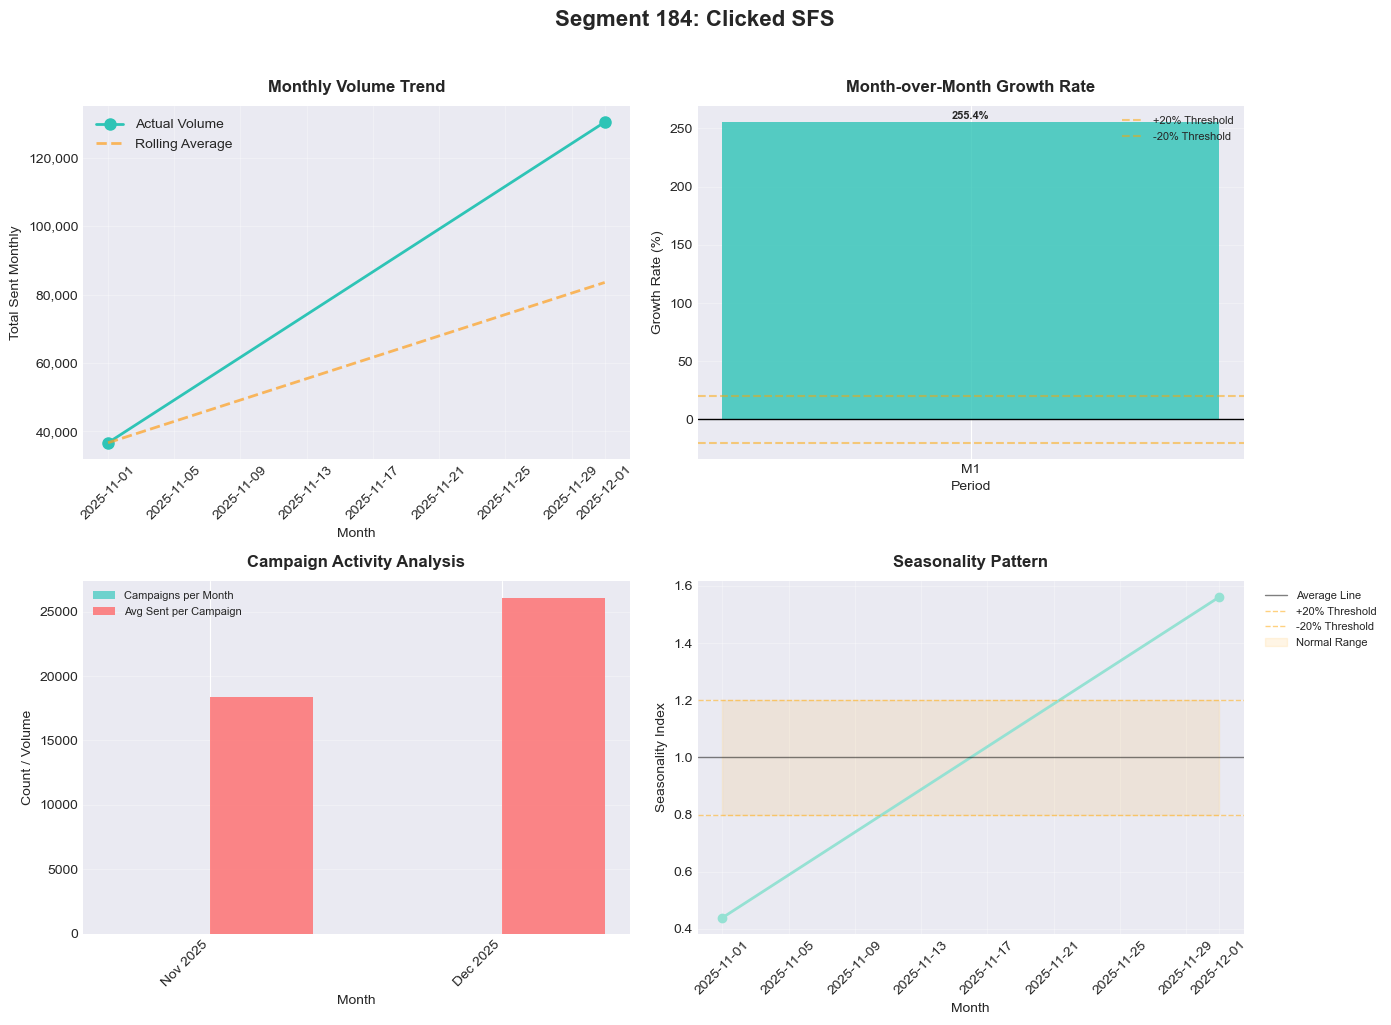


📊 SEGMENT 184: Clicked SFS
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 130,364
   • Campaigns: 5
   • Avg per Campaign: 26,073
   • MoM Change: 255.4%
   • Overall Growth: 255.4%



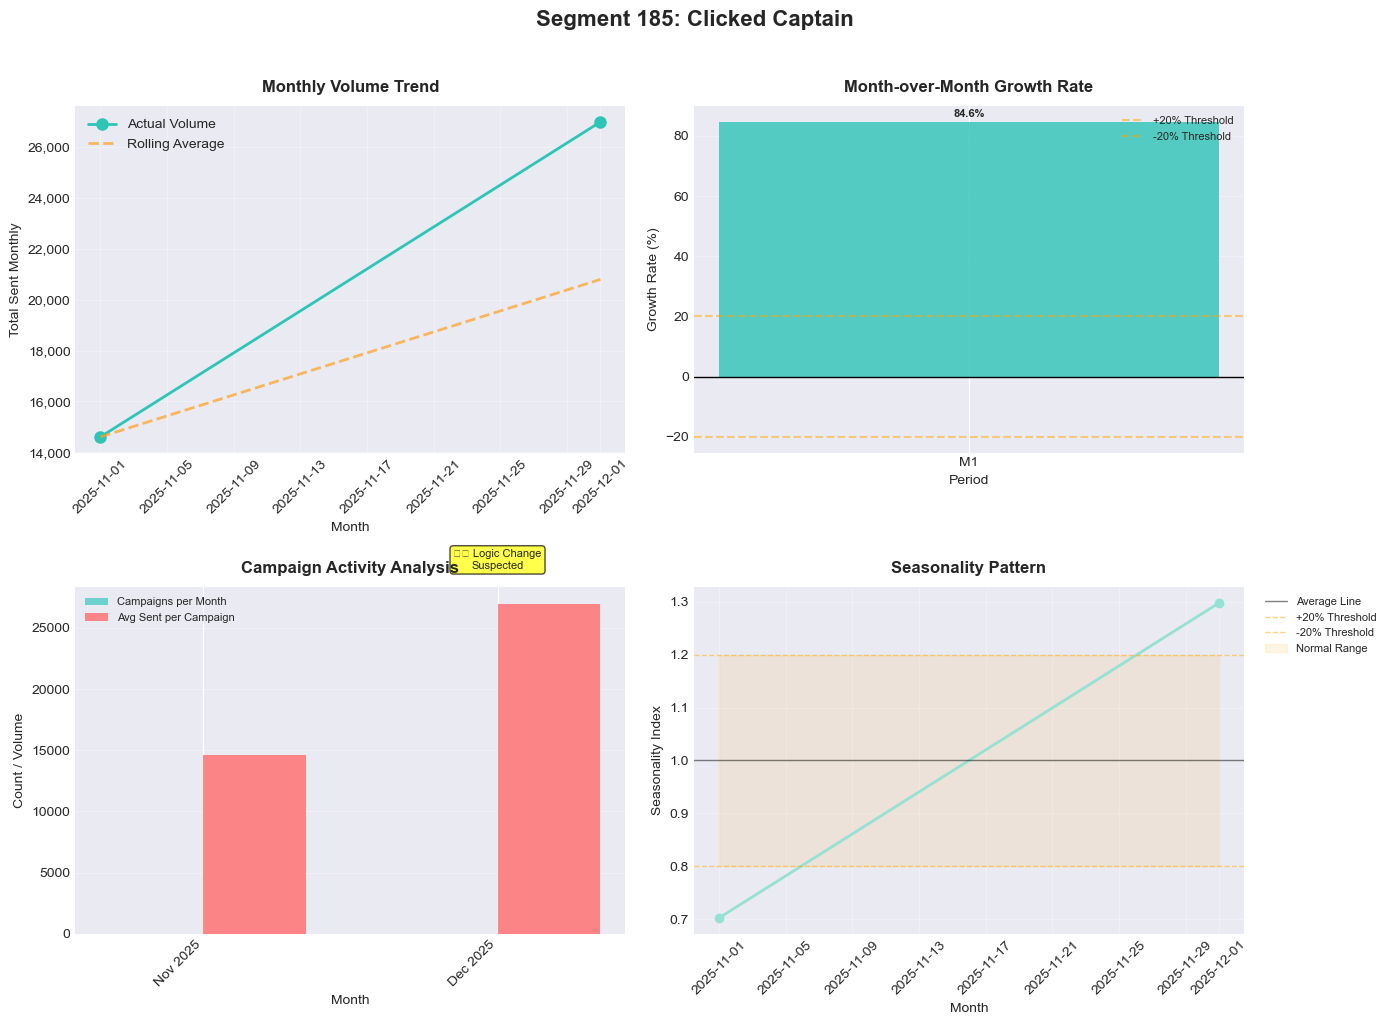


📊 SEGMENT 185: Clicked Captain
------------------------------------------------------------
   • Latest Month: Dec 2025
   • Total Sent: 26,975
   • Campaigns: 1
   • Avg per Campaign: 26,975
   • MoM Change: 84.6%
   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by 84.6%
   • Overall Growth: 84.6%


VOLUME TREND ANALYSIS & ANOMALY INSIGHTS

📊 TREND ANALYSIS SUMMARY:
   • Total Time Periods Analyzed: 68
   • Segments with Volume Anomalies: 0
   • Segments with Suspected Logic Changes: 8
   • Average Campaign Efficiency Change: 29.7%

⚠️  ANOMALY DETECTION RESULTS:
   • No significant volume anomalies detected

   • 9 suspected logic changes detected:
     🔄 ID 50 - Dec 2025: Avg sent changed by 22.8% with similar campaign count
     🔄 ID 97 - Dec 2025: Avg sent changed by 47.9% with similar campaign count
     🔄 ID 171 - Nov 2025: Avg sent changed by 37.2% with similar campaign count
     🔄 ID 172 - Dec 2025: Avg sent changed by 43.5% with similar campaign count
     🔄 ID 173 - Oct 20

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_volume_trends(df):
    """
    Analyze segment volume trends for anomaly detection and validation
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns:
        - segment_id, segment_name
        - month (datetime)
        - campaigns_per_month, total_sent_monthly
        - avg_sent_per_campaign, prev_month_total
    """
    
    print("=" * 100)
    print("SEGMENT VOLUME TREND ANALYSIS & ANOMALY DETECTION")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert month to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df_analysis['month']):
        df_analysis['month'] = pd.to_datetime(df_analysis['month'])
    
    # Ensure numeric columns
    numeric_cols = ['campaigns_per_month', 'total_sent_monthly', 
                   'avg_sent_per_campaign', 'prev_month_total']
    
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Sort by segment and month
    df_analysis = df_analysis.sort_values(['segment_id', 'month'])
    
    # Calculate month-over-month changes
    df_analysis['month_num'] = df_analysis.groupby('segment_id').cumcount() + 1
    df_analysis['month_over_month_change'] = df_analysis.groupby('segment_id')['total_sent_monthly'].pct_change() * 100
    
    # Calculate rolling statistics for anomaly detection
    df_analysis['rolling_avg_3m'] = df_analysis.groupby('segment_id')['total_sent_monthly'].transform(
        lambda x: x.rolling(window=2, min_periods=1).mean()
    )
    df_analysis['rolling_std_3m'] = df_analysis.groupby('segment_id')['total_sent_monthly'].transform(
        lambda x: x.rolling(window=2, min_periods=1).std()
    )
    
    # Detect anomalies using Z-score
    df_analysis['z_score'] = (df_analysis['total_sent_monthly'] - df_analysis['rolling_avg_3m']) / df_analysis['rolling_std_3m'].replace(0, 1)
    df_analysis['is_anomaly'] = np.abs(df_analysis['z_score']) > 2
    
    # Calculate seasonality index (simple version)
    df_analysis['seasonality_index'] = df_analysis['total_sent_monthly'] / df_analysis.groupby('segment_id')['total_sent_monthly'].transform('mean')
    
    # Detect potential logic changes
    df_analysis['campaign_avg_change'] = df_analysis.groupby('segment_id')['avg_sent_per_campaign'].pct_change() * 100
    df_analysis['logic_change_suspected'] = (
        (np.abs(df_analysis['campaign_avg_change']) > 20) &  # Avg sent per campaign changed >20%
        (df_analysis['campaigns_per_month'].diff().abs() <= 1)  # Campaign count similar
    )
    
    # Calculate growth metrics
    df_analysis['growth_rate'] = df_analysis.groupby('segment_id')['total_sent_monthly'].pct_change() * 100
    df_analysis['compound_growth'] = df_analysis.groupby('segment_id').apply(
        lambda x: (x['total_sent_monthly'].iloc[-1] / x['total_sent_monthly'].iloc[0]) ** (1/len(x)) - 1
    ).reset_index(level=0, drop=True) * 100
    
    # Identify segments with data
    segments = df_analysis['segment_id'].unique()
    total_segments = len(segments)
    total_months = df_analysis['month'].nunique()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Time Period: {df_analysis['month'].min().strftime('%b %Y')} to {df_analysis['month'].max().strftime('%b %Y')}")
    print(f"   • Total Observations: {len(df_analysis)}")
    print(f"   • Average Months per Segment: {len(df_analysis)/total_segments:.1f}")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Trend Analysis Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Volume Trend Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Time Series Trends (Top-left)
    ax1 = axes1[0, 0]
    
    # Plot each segment's time series
    colors = plt.cm.Set3(np.linspace(0, 1, len(segments)))
    
    for i, segment_id in enumerate(segments):
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
        segment_name = segment_data['segment_name'].iloc[0]
        
        # Plot line with markers
        line = ax1.plot(segment_data['month'], segment_data['total_sent_monthly'],
                       marker='o', linewidth=2, markersize=6,
                       color=colors[i], label=f"ID: {segment_id} - {segment_name[:15]}...")
        
        # Highlight anomalies
        anomaly_data = segment_data[segment_data['is_anomaly']]
        if len(anomaly_data) > 0:
            ax1.scatter(anomaly_data['month'], anomaly_data['total_sent_monthly'],
                       color='red', s=100, zorder=5, edgecolors='black', linewidth=2,
                       label=f"Anomaly - ID {segment_id}" if i == 0 else "")
    
    ax1.set_title('1. Monthly Volume Trends with Anomaly Detection', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Total Sent Monthly', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax1.grid(True, alpha=0.3)
    
    # Format y-axis with thousands separator
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # 1.2 Month-over-Month Change Analysis (Top-right)
    ax2 = axes1[0, 1]
    
    # Calculate MoM changes for all segments
    mom_changes = []
    segment_labels = []
    
    for segment_id in segments:
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id].sort_values('month')
        if len(segment_data) > 1:
            # Calculate latest MoM change
            latest_change = segment_data.iloc[-1]['month_over_month_change']
            if not np.isnan(latest_change):
                mom_changes.append(latest_change)
                segment_labels.append(f"ID: {segment_id}")
    
    if len(mom_changes) > 0:
        bars2 = ax2.bar(range(len(mom_changes)), mom_changes,
                       color=['#2EC4B6' if x > 0 else '#FF6B6B' for x in mom_changes],
                       alpha=0.8)
        
        ax2.axhline(y=0, color='black', linewidth=1)
        ax2.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='+20% Threshold')
        ax2.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='-20% Threshold')
        
        ax2.set_title('2. Latest Month-over-Month Change (%)', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Segment', fontsize=12)
        ax2.set_ylabel('Month-over-Month Change (%)', fontsize=12)
        ax2.set_xticks(range(len(mom_changes)))
        ax2.set_xticklabels(segment_labels, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, change) in enumerate(zip(bars2, mom_changes)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if change > 0 else -5),
                    f'{change:.1f}%', ha='center', va='bottom' if change > 0 else 'top',
                    fontweight='bold', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'No month-over-month change data available',
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('2. Month-over-Month Change Analysis', fontsize=14, fontweight='bold', pad=15)
    
    # 1.3 Campaign Efficiency Trends (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Plot campaign count vs volume efficiency
    scatter = ax3.scatter(df_analysis['campaigns_per_month'], df_analysis['avg_sent_per_campaign'],
                         s=df_analysis['total_sent_monthly'] / 1000,
                         c=df_analysis['month_num'],
                         cmap='viridis',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=1)
    
    # Add segment labels for outliers
    for _, row in df_analysis.iterrows():
        # Label only extreme points
        if (row['avg_sent_per_campaign'] > df_analysis['avg_sent_per_campaign'].quantile(0.9) or
            row['campaigns_per_month'] > df_analysis['campaigns_per_month'].quantile(0.9)):
            ax3.annotate(f"ID: {row['segment_id']}\n{row['month'].strftime('%b %Y')}", 
                        (row['campaigns_per_month'], row['avg_sent_per_campaign']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_title('3. Campaign Efficiency Analysis', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Campaigns per Month', fontsize=12)
    ax3.set_ylabel('Average Sent per Campaign', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    if len(df_analysis) > 1:
        z = np.polyfit(df_analysis['campaigns_per_month'], df_analysis['avg_sent_per_campaign'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df_analysis['campaigns_per_month'].min(), 
                             df_analysis['campaigns_per_month'].max(), 100)
        ax3.plot(x_range, p(x_range), "r--", alpha=0.5, linewidth=2, label='Trend Line')
        ax3.legend()
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax3, label='Month Number')
    
    # 1.4 Anomaly Detection Summary (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Calculate anomaly statistics
    total_anomalies = df_analysis['is_anomaly'].sum()
    logic_change_suspected = df_analysis['logic_change_suspected'].sum()
    
    # Create summary pie chart
    anomaly_categories = {
        'Normal Volume': len(df_analysis) - total_anomalies - logic_change_suspected,
        'Volume Anomalies': total_anomalies,
        'Logic Change Suspected': logic_change_suspected
    }
    
    colors4 = ['#2EC4B6', '#FF6B6B', '#FF9F1C']
    wedges, texts, autotexts = ax4.pie(anomaly_categories.values(), 
                                      labels=anomaly_categories.keys(),
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=colors4,
                                      wedgeprops=dict(width=0.3, edgecolor='w'))
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    
    ax4.set_title('4. Anomaly Detection Summary', fontsize=14, fontweight='bold', pad=15)
    
    # Add count in center
    ax4.text(0, 0, f'{total_anomalies}\nvolume anomalies\n{logic_change_suspected} logic changes', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Individual Segment Analysis
    # ============================================
    
    print("\n" + "=" * 100)
    print("INDIVIDUAL SEGMENT TREND ANALYSIS")
    print("=" * 100)
    
    # Create individual plots for each segment with multiple months of data
    segments_with_multiple_months = df_analysis.groupby('segment_id').filter(lambda x: len(x) > 1)
    
    if len(segments_with_multiple_months['segment_id'].unique()) > 0:
        for segment_id in segments_with_multiple_months['segment_id'].unique():
            segment_data = df_analysis[df_analysis['segment_id'] == segment_id].sort_values('month')
            segment_name = segment_data['segment_name'].iloc[0]
            
            fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
            fig2.suptitle(f'Segment {segment_id}: {segment_name}', fontsize=16, fontweight='bold', y=1.02)
            
            # 2.1 Volume Trend with Forecast
            ax5 = axes2[0, 0]
            
            # Plot actual data
            ax5.plot(segment_data['month'], segment_data['total_sent_monthly'], 
                    marker='o', linewidth=2, markersize=8, color='#2EC4B6', label='Actual Volume')
            
            # Plot rolling average
            ax5.plot(segment_data['month'], segment_data['rolling_avg_3m'], 
                    linestyle='--', linewidth=2, color='#FF9F1C', alpha=0.7, label='Rolling Average')
            
            # Highlight anomalies
            anomaly_data = segment_data[segment_data['is_anomaly']]
            if len(anomaly_data) > 0:
                ax5.scatter(anomaly_data['month'], anomaly_data['total_sent_monthly'],
                           color='red', s=150, zorder=5, edgecolors='black', linewidth=2,
                           label='Anomaly')
            
            ax5.set_title('Monthly Volume Trend', fontsize=12, fontweight='bold', pad=10)
            ax5.set_xlabel('Month', fontsize=10)
            ax5.set_ylabel('Total Sent Monthly', fontsize=10)
            ax5.tick_params(axis='x', rotation=45)
            ax5.legend()
            ax5.grid(True, alpha=0.3)
            ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            
            # 2.2 Growth Rate Analysis
            ax6 = axes2[0, 1]
            
            # Calculate and plot growth rates
            growth_rates = segment_data['growth_rate'].dropna()
            if len(growth_rates) > 0:
                colors_growth = ['#2EC4B6' if x > 0 else '#FF6B6B' for x in growth_rates]
                bars_growth = ax6.bar(range(len(growth_rates)), growth_rates, color=colors_growth, alpha=0.8)
                
                ax6.axhline(y=0, color='black', linewidth=1)
                ax6.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='+20% Threshold')
                ax6.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='-20% Threshold')
                
                ax6.set_title('Month-over-Month Growth Rate', fontsize=12, fontweight='bold', pad=10)
                ax6.set_xlabel('Period', fontsize=10)
                ax6.set_ylabel('Growth Rate (%)', fontsize=10)
                ax6.set_xticks(range(len(growth_rates)))
                ax6.set_xticklabels([f'M{i+1}' for i in range(len(growth_rates))])
                ax6.legend(fontsize=8)
                ax6.grid(True, alpha=0.3, axis='y')
                
                # Add value labels
                for i, (bar, rate) in enumerate(zip(bars_growth, growth_rates)):
                    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if rate > 0 else -3),
                            f'{rate:.1f}%', ha='center', va='bottom' if rate > 0 else 'top',
                            fontweight='bold', fontsize=8)
            
            # 2.3 Campaign Analysis
            ax7 = axes2[1, 0]
            
            # Plot campaigns and average sent
            x_pos = np.arange(len(segment_data))
            width = 0.35
            
            bars_campaigns = ax7.bar(x_pos - width/2, segment_data['campaigns_per_month'], width,
                                    label='Campaigns per Month', color='#4ECDC4', alpha=0.8)
            bars_avg_sent = ax7.bar(x_pos + width/2, segment_data['avg_sent_per_campaign'], width,
                                   label='Avg Sent per Campaign', color='#FF6B6B', alpha=0.8)
            
            # Highlight potential logic changes
            logic_changes = segment_data[segment_data['logic_change_suspected']]
            if len(logic_changes) > 0:
                for _, row in logic_changes.iterrows():
                    idx = list(segment_data['month']).index(row['month'])
                    ax7.text(idx, max(row['campaigns_per_month'], row['avg_sent_per_campaign']) * 1.1,
                            '⚠️ Logic Change\nSuspected', ha='center', va='bottom', fontsize=8,
                            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
            
            ax7.set_title('Campaign Activity Analysis', fontsize=12, fontweight='bold', pad=10)
            ax7.set_xlabel('Month', fontsize=10)
            ax7.set_ylabel('Count / Volume', fontsize=10)
            ax7.set_xticks(x_pos)
            ax7.set_xticklabels([m.strftime('%b %Y') for m in segment_data['month']], rotation=45, ha='right')
            ax7.legend(fontsize=8)
            ax7.grid(True, alpha=0.3, axis='y')
            
            # 2.4 Seasonality and Pattern
            ax8 = axes2[1, 1]
            
            # Plot seasonality index
            if len(segment_data) > 1:
                ax8.plot(segment_data['month'], segment_data['seasonality_index'],
                        marker='o', linewidth=2, markersize=6, color='#95E1D3')
                
                ax8.axhline(y=1, color='black', linestyle='-', alpha=0.5, linewidth=1, label='Average Line')
                ax8.axhline(y=1.2, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='+20% Threshold')
                ax8.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='-20% Threshold')
                
                ax8.fill_between(segment_data['month'], 0.8, 1.2, alpha=0.1, color='orange', label='Normal Range')
                
                ax8.set_title('Seasonality Pattern', fontsize=12, fontweight='bold', pad=10)
                ax8.set_xlabel('Month', fontsize=10)
                ax8.set_ylabel('Seasonality Index', fontsize=10)
                ax8.tick_params(axis='x', rotation=45)
                ax8.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
                ax8.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Print segment-specific insights
            print(f"\n📊 SEGMENT {segment_id}: {segment_name}")
            print("-" * 60)
            
            # Calculate segment-specific metrics
            latest_month = segment_data.iloc[-1]
            if len(segment_data) > 1:
                prev_month = segment_data.iloc[-2]
                
                print(f"   • Latest Month: {latest_month['month'].strftime('%b %Y')}")
                print(f"   • Total Sent: {latest_month['total_sent_monthly']:,.0f}")
                print(f"   • Campaigns: {latest_month['campaigns_per_month']}")
                print(f"   • Avg per Campaign: {latest_month['avg_sent_per_campaign']:,.0f}")
                
                if not pd.isna(latest_month['month_over_month_change']):
                    print(f"   • MoM Change: {latest_month['month_over_month_change']:.1f}%")
                
                # Anomaly status
                if latest_month['is_anomaly']:
                    print(f"   • ⚠️ VOLUME ANOMALY DETECTED: Z-score = {latest_month['z_score']:.2f}")
                
                if latest_month['logic_change_suspected']:
                    print(f"   • ⚠️ LOGIC CHANGE SUSPECTED: Avg sent changed by {latest_month['campaign_avg_change']:.1f}%")
                
                # Trend analysis
                if len(segment_data) >= 2:
                    overall_growth = ((latest_month['total_sent_monthly'] / segment_data.iloc[0]['total_sent_monthly']) - 1) * 100
                    print(f"   • Overall Growth: {overall_growth:.1f}%")
            
            print()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("VOLUME TREND ANALYSIS & ANOMALY INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    total_observations = len(df_analysis)
    segments_with_anomalies = df_analysis[df_analysis['is_anomaly']]['segment_id'].nunique()
    segments_with_logic_changes = df_analysis[df_analysis['logic_change_suspected']]['segment_id'].nunique()
    
    # Calculate volatility metrics
    df_analysis['volatility'] = df_analysis.groupby('segment_id')['total_sent_monthly'].transform('std') / \
                                df_analysis.groupby('segment_id')['total_sent_monthly'].transform('mean') * 100
    
    # Identify most volatile segments
    most_volatile = df_analysis.drop_duplicates('segment_id').nlargest(3, 'volatility')
    
    # Identify segments with consistent growth
    segments_with_growth = []
    for segment_id in segments:
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id].sort_values('month')
        if len(segment_data) > 1:
            growth_trend = segment_data['total_sent_monthly'].iloc[-1] > segment_data['total_sent_monthly'].iloc[0]
            if growth_trend:
                segments_with_growth.append(segment_id)
    
    # Calculate average campaign efficiency changes
    avg_campaign_efficiency_change = df_analysis['campaign_avg_change'].abs().mean()
    
    print(f"\n📊 TREND ANALYSIS SUMMARY:")
    print(f"   • Total Time Periods Analyzed: {total_observations}")
    print(f"   • Segments with Volume Anomalies: {segments_with_anomalies}")
    print(f"   • Segments with Suspected Logic Changes: {segments_with_logic_changes}")
    print(f"   • Average Campaign Efficiency Change: {avg_campaign_efficiency_change:.1f}%")
    
    print(f"\n⚠️  ANOMALY DETECTION RESULTS:")
    
    # List all anomalies
    anomalies = df_analysis[df_analysis['is_anomaly']]
    if len(anomalies) > 0:
        print(f"   • {len(anomalies)} anomalous data points detected:")
        for _, row in anomalies.iterrows():
            print(f"     ⚠️  ID {row['segment_id']} - {row['month'].strftime('%b %Y')}: "
                  f"{row['total_sent_monthly']:,.0f} sends (Z-score: {row['z_score']:.2f})")
    else:
        print(f"   • No significant volume anomalies detected")
    
    # List suspected logic changes
    logic_changes = df_analysis[df_analysis['logic_change_suspected']]
    if len(logic_changes) > 0:
        print(f"\n   • {len(logic_changes)} suspected logic changes detected:")
        for _, row in logic_changes.iterrows():
            print(f"     🔄 ID {row['segment_id']} - {row['month'].strftime('%b %Y')}: "
                  f"Avg sent changed by {row['campaign_avg_change']:.1f}% with similar campaign count")
    
    print(f"\n📈 VOLATILITY ANALYSIS:")
    if len(most_volatile) > 0:
        print(f"   • Most Volatile Segments:")
        for _, row in most_volatile.iterrows():
            print(f"     📊 ID {row['segment_id']}: {row['volatility']:.1f}% volatility")
    
    print(f"\n🚀 GROWTH TRENDS:")
    if len(segments_with_growth) > 0:
        print(f"   • {len(segments_with_growth)} segments showing growth trend")
        for segment_id in segments_with_growth[:3]:  # Show top 3
            segment_data = df_analysis[df_analysis['segment_id'] == segment_id].sort_values('month')
            growth_rate = ((segment_data['total_sent_monthly'].iloc[-1] / segment_data['total_sent_monthly'].iloc[0]) - 1) * 100
            print(f"     📈 ID {segment_id}: {growth_rate:.1f}% overall growth")
    
    print(f"\n🔍 INVESTIGATION PRIORITIES:")
    
    # Priority 1: Recent anomalies
    recent_anomalies = anomalies[anomalies['month'] == df_analysis['month'].max()]
    if len(recent_anomalies) > 0:
        print(f"   1. RECENT ANOMALIES (Require Immediate Attention):")
        for _, row in recent_anomalies.iterrows():
            print(f"      • ID {row['segment_id']}: {row['total_sent_monthly']:,.0f} sends in latest month")
    
    # Priority 2: Logic changes
    if len(logic_changes) > 0:
        print(f"   2. SUSPECTED LOGIC CHANGES:")
        for _, row in logic_changes.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Check segment definition for {row['month'].strftime('%b %Y')}")
    
    # Priority 3: High volatility
    if len(most_volatile) > 0:
        print(f"   3. HIGH VOLATILITY SEGMENTS:")
        for _, row in most_volatile.iterrows():
            print(f"      • ID {row['segment_id']}: Review for consistency issues")
    
    # Priority 4: Declining segments
    declining_segments = []
    for segment_id in segments:
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id].sort_values('month')
        if len(segment_data) > 1:
            latest_change = segment_data.iloc[-1]['month_over_month_change']
            if not pd.isna(latest_change) and latest_change < -10:
                declining_segments.append((segment_id, latest_change))
    
    if len(declining_segments) > 0:
        print(f"   4. DECLINING SEGMENTS:")
        for segment_id, change in declining_segments[:3]:
            print(f"      • ID {segment_id}: {change:.1f}% MoM decline")
    
    print(f"\n📋 VALIDATION & MONITORING RECOMMENDATIONS:")
    
    # Recommendation 1: Anomaly response
    if len(anomalies) > 0:
        print(f"   1. ANOMALY RESPONSE PLAN:")
        print(f"      • Investigate {len(anomalies)} detected anomalies within 48 hours")
        print(f"      • Document root causes for recurring anomalies")
    
    # Recommendation 2: Logic validation
    if len(logic_changes) > 0:
        print(f"   2. LOGIC VALIDATION:")
        print(f"      • Audit segment definitions for {len(logic_changes)} suspected changes")
        print(f"      • Implement change tracking for segment logic")
    
    # Recommendation 3: Monitoring setup
    print(f"   3. MONITORING SETUP:")
    print(f"      • Set alerts for volume changes >20% month-over-month")
    print(f"      • Monitor campaign efficiency changes >15% with stable campaign count")
    print(f"      • Establish baseline volumes for trend comparison")
    
    # Recommendation 4: Data quality
    missing_prev_data = df_analysis['prev_month_total'].isna().sum()
    if missing_prev_data > 0:
        print(f"   4. DATA QUALITY IMPROVEMENT:")
        print(f"      • {missing_prev_data} observations missing previous month data")
        print(f"      • Ensure complete historical tracking for all segments")
    
    # Recommendation 5: Forecasting
    print(f"   5. FORECASTING & PLANNING:")
    print(f"      • Develop 3-month rolling forecasts for key segments")
    print(f"      • Establish growth targets based on historical trends")
    
    print(f"\n" + "=" * 100)
    print("DETAILED TREND ANALYSIS TABLE")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'month', 'campaigns_per_month',
                   'total_sent_monthly', 'avg_sent_per_campaign', 'month_over_month_change',
                   'is_anomaly', 'logic_change_suspected']
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['month'] = summary_df['month'].dt.strftime('%b %Y')
    summary_df['total_sent_monthly'] = summary_df['total_sent_monthly'].apply(format_number)
    summary_df['avg_sent_per_campaign'] = summary_df['avg_sent_per_campaign'].apply(format_number)
    summary_df['month_over_month_change'] = summary_df['month_over_month_change'].apply(
        lambda x: f"{x:+.1f}%" if pd.notnull(x) else "N/A"
    )
    summary_df['is_anomaly'] = summary_df['is_anomaly'].apply(lambda x: '⚠️' if x else '✓')
    summary_df['logic_change_suspected'] = summary_df['logic_change_suspected'].apply(lambda x: '🔍' if x else '✓')
    
    # Sort by segment and month
    summary_df = summary_df.sort_values(['segment_id', 'month'])
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics_summary = {
        'Total Segments Analyzed': f"{total_segments}",
        'Total Months Analyzed': f"{total_months}",
        'Total Observations': f"{total_observations}",
        'Volume Anomalies Detected': f"{total_anomalies}",
        'Suspected Logic Changes': f"{logic_change_suspected}",
        'Segments with Growth': f"{len(segments_with_growth)}",
        'Average Volatility': f"{df_analysis['volatility'].mean():.1f}%",
        'Average MoM Change': f"{df_analysis['month_over_month_change'].abs().mean():.1f}%",
        'Data Completeness': f"{(1 - df_analysis['prev_month_total'].isna().sum()/len(df_analysis))*100:.1f}%"
    }
    
    for metric_name, metric_value in metrics_summary.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("DETECTION THRESHOLDS USED")
    print("=" * 100)
    
    print(f"\n📊 ANOMALY DETECTION PARAMETERS:")
    print(f"   1. Volume Anomaly: |Z-score| > 2 (statistical outlier)")
    print(f"   2. Logic Change: >20% change in avg_sent_per_campaign with stable campaign count")
    print(f"   3. Significant Change: >20% month-over-month volume change")
    print(f"   4. High Volatility: >30% coefficient of variation")
    
    print(f"\n📈 TREND CATEGORIES:")
    print(f"   • Strong Growth: >10% MoM increase for 2+ consecutive months")
    print(f"   • Decline: >10% MoM decrease for 2+ consecutive months")
    print(f"   • Stable: MoM changes within ±10%")
    print(f"   • Volatile: MoM changes frequently exceed ±20%")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_volume_trends(df)

# -- 5. Segment reachability analysis

In [13]:
SQL_NAME = "3_/3_5"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name  total_campaigns   avg_delivery_rate_pct       avg_open_rate_pct          avg_click_rate_pct reachability  \
0          50    Sent atleast 20 emails                4  0.99975714285714285700  0.17500000000000000000  0.009114285714285714285700    Low Reach   
1          52           Not in YFS List                1  0.99970000000000000000  0.15680000000000000000  0.009000000000000000000000    Low Reach   
2         150  5 days recent engagement               63  0.99966176470588235300  0.31355588235294117600      0.02668921568627451000    Low Reach   

       segment_health  
0  Requires Attention  
1  Requires Attention  
2  Requires Attention

SEGMENT PERFORMANCE & HEALTH ANALYSIS

📋 DATA PREVIEW:
   segment_id              segment_name  total_campaigns   avg_delivery_rate_pct       avg_open_rate_pct          avg_click_rate_pct reachability  \
0          50    Sent atleast 20 emails                4  0.99975714285714285700  0.17500000000000000000  0.009114285714285714285700    Low Reach   
1          52           Not in YFS List                1  0.99970000000000000000  0.15680000000000000000  0.009000000000000000000000    Low Reach   
2         150  5 days recent engagement               63  0.99966176470588235300  0.31355588235294117600      0.02668921568627451000    Low Reach   
3          92           Gaming Interest                8  0.99963636363636363600  0.27041818181818181800  0.009154545454545454545500    Low Reach   
4         179            Clicked Gaming               35  0.99961428571428571400  0.20390408163265306100      0.01095102040816326500    Low Reach   

       segment_health  
0  Requires Attention  
1 

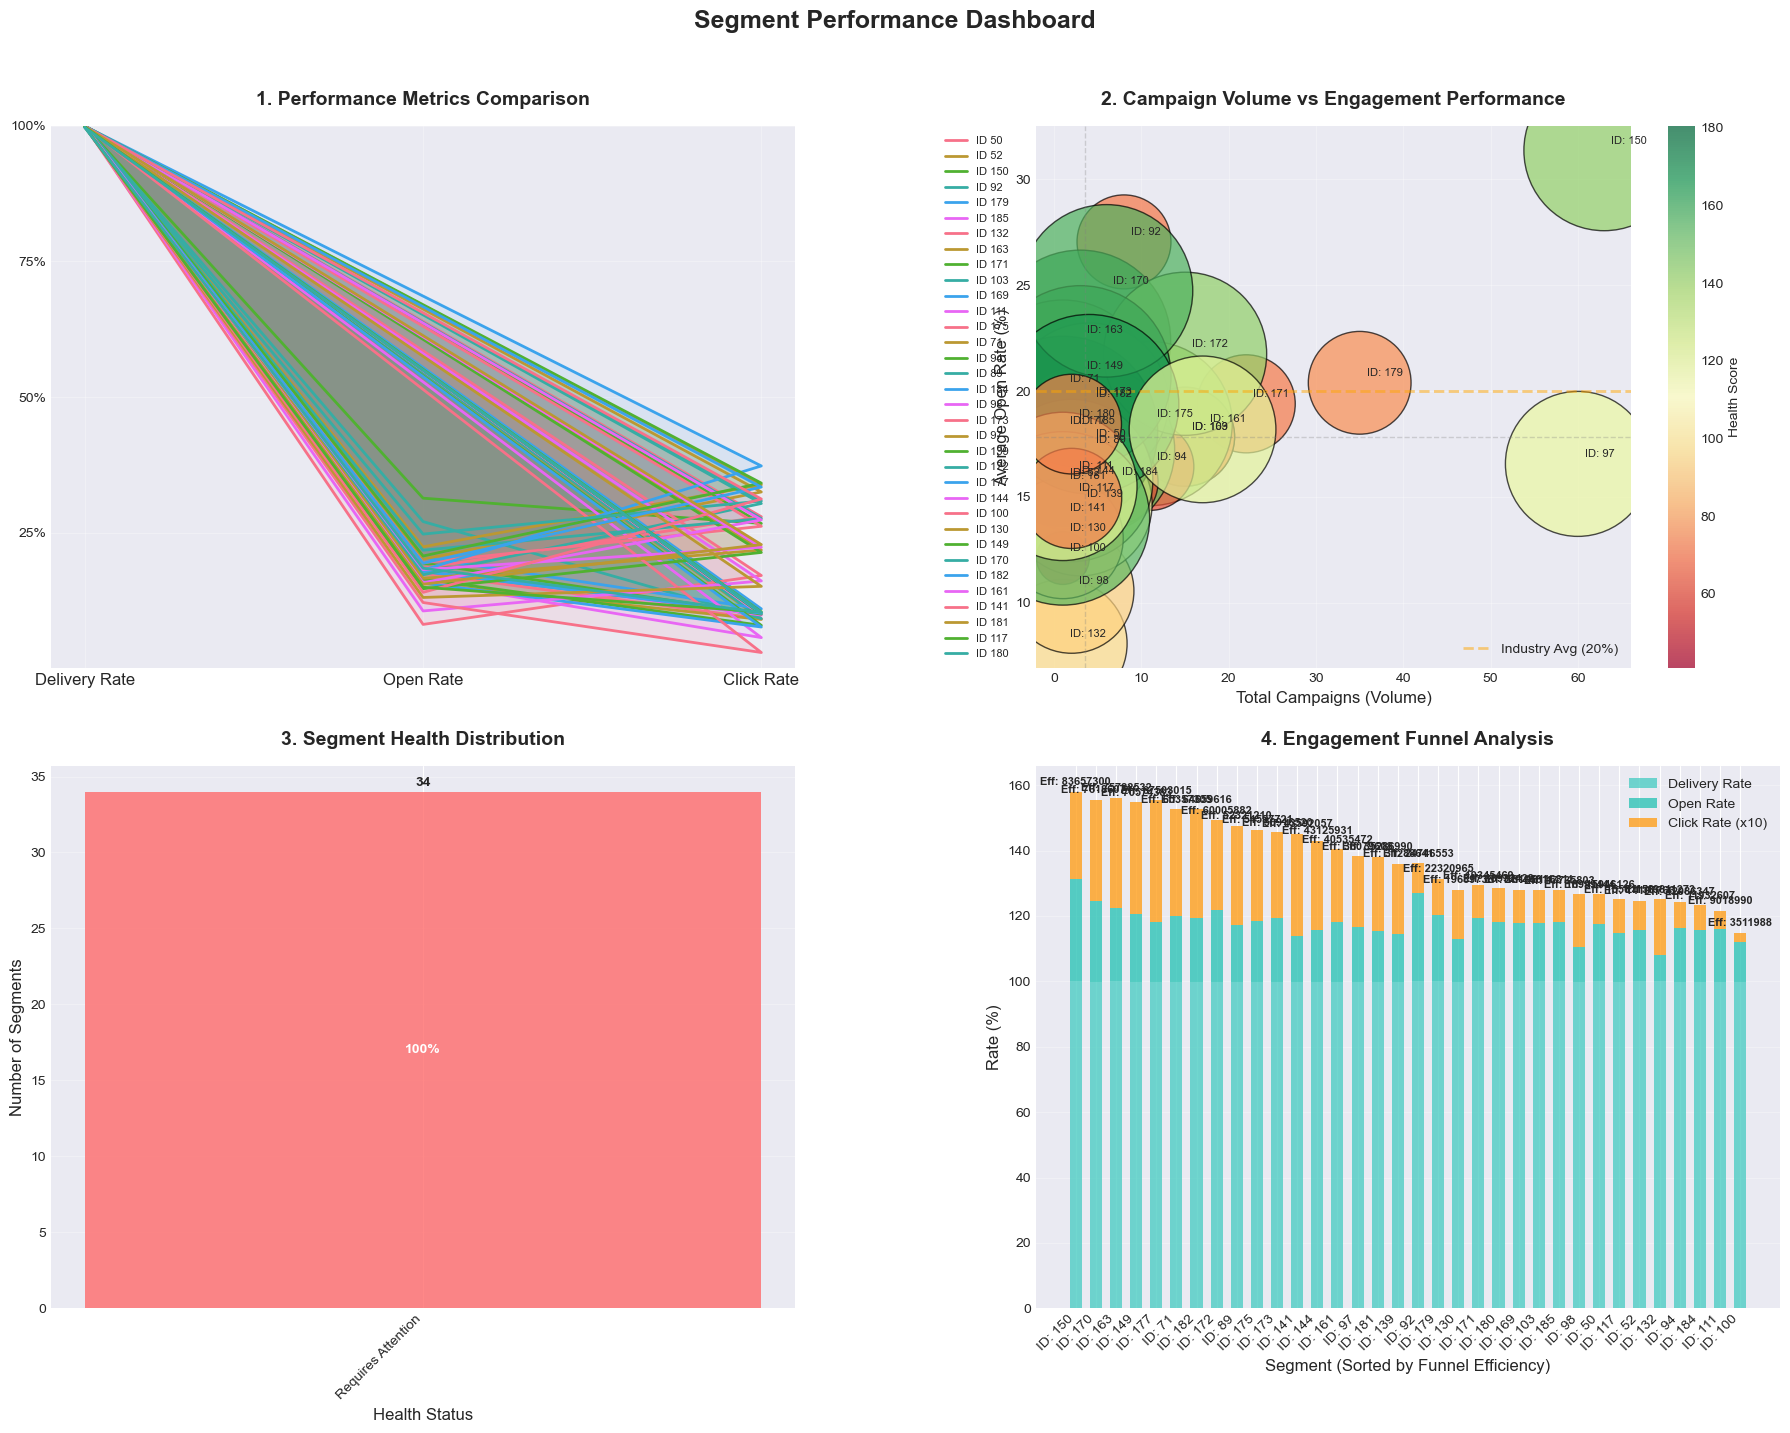

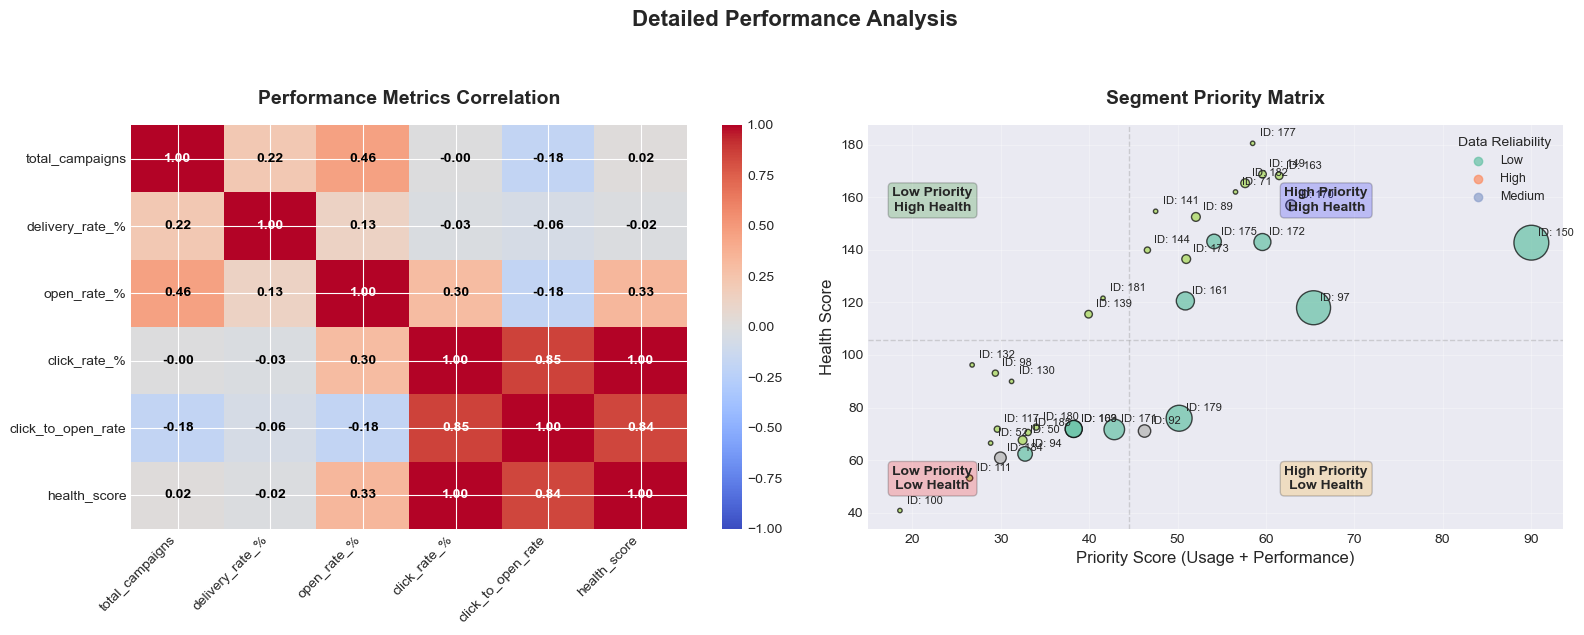


PERFORMANCE & HEALTH INSIGHTS

📊 PERFORMANCE SUMMARY:
   • Delivery Excellence: 34/34 segments with ≥99% delivery
   • Open Rate Performance: 8/34 segments meet industry average (20%)
   • Click Rate Performance: 33/34 segments with ≥0.5% click rate

🏆 TOP PERFORMERS:
   • Highest Open Rate: ID 150 (5 days recent engagement) - 31.36%
   • Highest Click Rate: ID 177 (Clicked Tesco YouSweep) - 3.73%
   • Most Campaigns: ID 150 (5 days recent engagement) - 63 campaigns

⚠️  HEALTH ASSESSMENT:
   • 34 segments require immediate attention:
     ⚠️  ID 50: Sent atleast 20 emails... - Health: Requires Attention
     ⚠️  ID 52: Not in YFS List... - Health: Requires Attention
     ⚠️  ID 150: 5 days recent engagement... - Health: Requires Attention
     ⚠️  ID 92: Gaming Interest... - Health: Requires Attention
     ⚠️  ID 179: Clicked Gaming... - Health: Requires Attention
     ⚠️  ID 185: Clicked Captain... - Health: Requires Attention
     ⚠️  ID 132: clicked pickmypostcode... - Health: Req

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_performance_health(df):
    """
    Analyze segment performance metrics and health status
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns:
        - segment_id, segment_name
        - total_campaigns, avg_delivery_rate_pct, avg_open_rate_pct, avg_click_rate_pct
        - reachability, segment_health
    """
    
    print("=" * 100)
    print("SEGMENT PERFORMANCE & HEALTH ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert to numeric where possible
    numeric_cols = ['total_campaigns', 'avg_delivery_rate_pct', 
                   'avg_open_rate_pct', 'avg_click_rate_pct']
    
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Convert percentages to actual percentages (assuming they're already in decimal form)
    df_analysis['delivery_rate_%'] = df_analysis['avg_delivery_rate_pct'] * 100
    df_analysis['open_rate_%'] = df_analysis['avg_open_rate_pct'] * 100
    df_analysis['click_rate_%'] = df_analysis['avg_click_rate_pct'] * 100
    
    # Calculate additional metrics
    df_analysis['click_to_open_rate'] = (df_analysis['avg_click_rate_pct'] / df_analysis['avg_open_rate_pct']) * 100
    df_analysis['performance_score'] = (
        df_analysis['delivery_rate_%'] * 0.3 +  # Delivery is critical
        df_analysis['open_rate_%'] * 0.4 +       # Open rate is important
        df_analysis['click_rate_%'] * 100 * 0.3  # Click rate (multiplied for scale)
    )
    
    # Calculate engagement funnel efficiency
    df_analysis['funnel_efficiency'] = df_analysis['delivery_rate_%'] * df_analysis['open_rate_%'] * df_analysis['click_rate_%'] * 10000
    
    # Calculate data reliability based on total campaigns
    df_analysis['data_reliability'] = np.where(
        df_analysis['total_campaigns'] >= 10,
        'High',
        np.where(
            df_analysis['total_campaigns'] >= 5,
            'Medium',
            'Low'
        )
    )
    
    # Calculate segment priority based on performance and campaigns
    df_analysis['priority_score'] = (
        (df_analysis['total_campaigns'] / df_analysis['total_campaigns'].max()) * 25 +
        (df_analysis['open_rate_%'] / df_analysis['open_rate_%'].max()) * 40 +
        (df_analysis['click_rate_%'] / df_analysis['click_rate_%'].max()) * 35
    )
    
    # Calculate overall health score
    df_analysis['health_score'] = (
        df_analysis['delivery_rate_%'] * 0.25 +
        df_analysis['open_rate_%'] * 0.35 +
        (df_analysis['click_rate_%'] * 100) * 0.4
    )
    
    # Classify health based on score
    df_analysis['health_category'] = pd.cut(
        df_analysis['health_score'],
        bins=[0, 50, 70, 85, 100],
        labels=['Critical', 'Poor', 'Good', 'Excellent']
    )
    
    # Basic statistics
    total_segments = len(df_analysis)
    avg_campaigns = df_analysis['total_campaigns'].mean()
    avg_delivery = df_analysis['delivery_rate_%'].mean()
    avg_open = df_analysis['open_rate_%'].mean()
    avg_click = df_analysis['click_rate_%'].mean()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Average Campaigns per Segment: {avg_campaigns:.1f}")
    print(f"   • Average Delivery Rate: {avg_delivery:.2f}%")
    print(f"   • Average Open Rate: {avg_open:.2f}%")
    print(f"   • Average Click Rate: {avg_click:.2f}%")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Performance Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Performance Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Performance Metrics Radar Chart (Top-left)
    ax1 = axes1[0, 0]
    
    # Prepare data for radar chart
    categories = ['Delivery Rate', 'Open Rate', 'Click Rate']
    num_vars = len(categories)
    
    # Calculate angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Plot each segment
    for idx, row in df_analysis.iterrows():
        values = [
            row['delivery_rate_%'] / 100,  # Normalize to 0-1 scale
            row['open_rate_%'] / 100,
            row['click_rate_%'] / 100 * 10  # Scale up click rate for visibility
        ]
        values += values[:1]  # Close the loop
        
        ax1.plot(angles, values, linewidth=2, linestyle='solid', 
                label=f"ID {row['segment_id']}")
        ax1.fill(angles, values, alpha=0.1)
    
    # Set category labels
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, fontsize=12)
    
    # Set y-ticks
    ax1.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax1.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=10)
    ax1.set_ylim(0, 1)
    
    ax1.set_title('1. Performance Metrics Comparison', fontsize=14, fontweight='bold', pad=15)
    ax1.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1.3, 1))
    ax1.grid(True, alpha=0.3)
    
    # 1.2 Campaign Volume vs Performance (Top-right)
    ax2 = axes1[0, 1]
    
    # Create bubble chart
    scatter = ax2.scatter(df_analysis['total_campaigns'], df_analysis['open_rate_%'],
                         s=df_analysis['click_rate_%'] * 5000,  # Bubble size = click rate
                         c=df_analysis['health_score'],        # Color = health score
                         cmap='RdYlGn',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax2.annotate(f"ID: {row['segment_id']}", 
                    (row['total_campaigns'], row['open_rate_%']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_title('2. Campaign Volume vs Engagement Performance', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Total Campaigns (Volume)', fontsize=12)
    ax2.set_ylabel('Average Open Rate (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add benchmark lines
    industry_avg_open = 20  # Industry average open rate
    ax2.axhline(y=industry_avg_open, color='orange', linestyle='--', alpha=0.5, 
               linewidth=2, label=f'Industry Avg ({industry_avg_open}%)')
    
    # Add quadrant lines
    median_campaigns = df_analysis['total_campaigns'].median()
    median_open = df_analysis['open_rate_%'].median()
    
    ax2.axhline(y=median_open, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax2.axvline(x=median_campaigns, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax2, label='Health Score')
    ax2.legend()
    
    # 1.3 Health Status Distribution (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Count health categories
    if 'segment_health' in df_analysis.columns:
        health_counts = df_analysis['segment_health'].value_counts()
    else:
        health_counts = df_analysis['health_category'].value_counts()
    
    colors3 = {'Critical': '#FF6B6B', 'Poor': '#FF9F1C', 
               'Good': '#2EC4B6', 'Excellent': '#4ECDC4',
               'Requires Attention': '#FF6B6B', 'Healthy': '#2EC4B6'}
    
    # Create bar chart
    bars3 = ax3.bar(range(len(health_counts)), health_counts.values,
                   color=[colors3.get(cat, '#95E1D3') for cat in health_counts.index],
                   alpha=0.8)
    
    ax3.set_title('3. Segment Health Distribution', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Health Status', fontsize=12)
    ax3.set_ylabel('Number of Segments', fontsize=12)
    ax3.set_xticks(range(len(health_counts)))
    ax3.set_xticklabels(health_counts.index, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, count in zip(bars3, health_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Add percentage labels
    total = len(df_analysis)
    for i, (bar, count) in enumerate(zip(bars3, health_counts.values)):
        percentage = (count / total) * 100
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'{percentage:.0f}%', ha='center', va='center', 
                fontweight='bold', color='white')
    
    # 1.4 Performance Funnel Analysis (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Calculate funnel metrics for each segment
    funnel_data = df_analysis.copy()
    funnel_data = funnel_data.sort_values('funnel_efficiency', ascending=False)
    
    # Create stacked funnel visualization
    x_pos = np.arange(len(funnel_data))
    width = 0.6
    
    bars_delivery = ax4.bar(x_pos, funnel_data['delivery_rate_%'], 
                           width=width, label='Delivery Rate', color='#4ECDC4', alpha=0.8)
    bars_open = ax4.bar(x_pos, funnel_data['open_rate_%'], 
                       width=width, bottom=funnel_data['delivery_rate_%'],
                       label='Open Rate', color='#2EC4B6', alpha=0.8)
    bars_click = ax4.bar(x_pos, funnel_data['click_rate_%'] * 10,  # Scale for visibility
                        width=width, 
                        bottom=funnel_data['delivery_rate_%'] + funnel_data['open_rate_%'],
                        label='Click Rate (x10)', color='#FF9F1C', alpha=0.8)
    
    ax4.set_title('4. Engagement Funnel Analysis', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Segment (Sorted by Funnel Efficiency)', fontsize=12)
    ax4.set_ylabel('Rate (%)', fontsize=12)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f"ID: {id}" for id in funnel_data['segment_id']], rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add efficiency score labels
    for i, (_, row) in enumerate(funnel_data.iterrows()):
        ax4.text(i, row['delivery_rate_%'] + row['open_rate_%'] + (row['click_rate_%'] * 10) + 2,
                f"Eff: {row['funnel_efficiency']:.0f}", ha='center', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Detailed Performance Analysis
    # ============================================
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('Detailed Performance Analysis', fontsize=16, fontweight='bold', y=1.05)
    
    # 2.1 Correlation Heatmap
    ax5 = axes2[0]
    
    # Calculate correlation matrix
    corr_matrix = df_analysis[['total_campaigns', 'delivery_rate_%', 
                              'open_rate_%', 'click_rate_%', 
                              'click_to_open_rate', 'health_score']].corr()
    
    # Create heatmap
    im = ax5.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    
    ax5.set_title('Performance Metrics Correlation', fontsize=14, fontweight='bold', pad=15)
    ax5.set_xticks(np.arange(len(corr_matrix.columns)))
    ax5.set_yticks(np.arange(len(corr_matrix.columns)))
    ax5.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax5.set_yticklabels(corr_matrix.columns)
    
    # Add correlation values
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            ax5.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha='center', va='center', 
                    color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                    fontsize=10, fontweight='bold')
    
    plt.colorbar(im, ax=ax5)
    
    # 2.2 Priority Matrix
    ax6 = axes2[1]
    
    # Create priority matrix: Performance vs Campaign Volume
    scatter2 = ax6.scatter(df_analysis['priority_score'], df_analysis['health_score'],
                          s=df_analysis['total_campaigns'] * 10,
                          c=pd.Categorical(df_analysis['data_reliability']).codes,
                          cmap='Set2',
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax6.annotate(f"ID: {row['segment_id']}", 
                    (row['priority_score'], row['health_score']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax6.set_title('Segment Priority Matrix', fontsize=14, fontweight='bold', pad=15)
    ax6.set_xlabel('Priority Score (Usage + Performance)', fontsize=12)
    ax6.set_ylabel('Health Score', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # Add quadrant lines
    median_priority = df_analysis['priority_score'].median()
    median_health = df_analysis['health_score'].median()
    
    ax6.axhline(y=median_health, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax6.axvline(x=median_priority, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Add quadrant labels
    ax6.text(median_priority/2, median_health*1.5, 'Low Priority\nHigh Health', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
    ax6.text(median_priority*1.5, median_health*1.5, 'High Priority\nHigh Health', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.2))
    ax6.text(median_priority/2, median_health/2, 'Low Priority\nLow Health', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    ax6.text(median_priority*1.5, median_health/2, 'High Priority\nLow Health', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.2))
    
    # Create custom legend for data reliability
    unique_reliability = df_analysis['data_reliability'].unique()
    for i, rel in enumerate(unique_reliability):
        ax6.scatter([], [], color=plt.cm.Set2(i), label=rel, alpha=0.7)
    ax6.legend(title='Data Reliability', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("PERFORMANCE & HEALTH INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    total_segments = len(df_analysis)
    segments_with_high_delivery = len(df_analysis[df_analysis['delivery_rate_%'] >= 99])
    segments_with_good_open = len(df_analysis[df_analysis['open_rate_%'] >= industry_avg_open])
    segments_with_good_click = len(df_analysis[df_analysis['click_rate_%'] >= 0.5])
    
    # Identify best and worst performers
    best_open_segment = df_analysis.loc[df_analysis['open_rate_%'].idxmax()]
    worst_open_segment = df_analysis.loc[df_analysis['open_rate_%'].idxmin()]
    best_click_segment = df_analysis.loc[df_analysis['click_rate_%'].idxmax()]
    most_campaigns_segment = df_analysis.loc[df_analysis['total_campaigns'].idxmax()]
    
    # Calculate health distribution
    if 'segment_health' in df_analysis.columns:
        critical_segments = df_analysis[df_analysis['segment_health'] == 'Requires Attention']
    else:
        critical_segments = df_analysis[df_analysis['health_category'] == 'Critical']
    
    # Calculate reachability distribution
    if 'reachability' in df_analysis.columns:
        low_reach_segments = df_analysis[df_analysis['reachability'] == 'Low Reach']
        reachability_summary = df_analysis['reachability'].value_counts()
    else:
        low_reach_segments = pd.DataFrame()
        reachability_summary = pd.Series()
    
    # Calculate data reliability
    low_reliability_segments = df_analysis[df_analysis['data_reliability'] == 'Low']
    
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print(f"   • Delivery Excellence: {segments_with_high_delivery}/{total_segments} segments with ≥99% delivery")
    print(f"   • Open Rate Performance: {segments_with_good_open}/{total_segments} segments meet industry average ({industry_avg_open}%)")
    print(f"   • Click Rate Performance: {segments_with_good_click}/{total_segments} segments with ≥0.5% click rate")
    
    print(f"\n🏆 TOP PERFORMERS:")
    print(f"   • Highest Open Rate: ID {best_open_segment['segment_id']} ({best_open_segment['segment_name']}) - {best_open_segment['open_rate_%']:.2f}%")
    print(f"   • Highest Click Rate: ID {best_click_segment['segment_id']} ({best_click_segment['segment_name']}) - {best_click_segment['click_rate_%']:.2f}%")
    print(f"   • Most Campaigns: ID {most_campaigns_segment['segment_id']} ({most_campaigns_segment['segment_name']}) - {most_campaigns_segment['total_campaigns']} campaigns")
    
    print(f"\n⚠️  HEALTH ASSESSMENT:")
    if len(critical_segments) > 0:
        print(f"   • {len(critical_segments)} segments require immediate attention:")
        for _, row in critical_segments.iterrows():
            print(f"     ⚠️  ID {row['segment_id']}: {row['segment_name'][:30]}... - Health: {row.get('segment_health', row.get('health_category', 'N/A'))}")
    else:
        print(f"   • No segments in critical health status")
    
    print(f"\n📡 REACHABILITY ANALYSIS:")
    if len(low_reach_segments) > 0:
        print(f"   • {len(low_reach_segments)} segments have low reachability:")
        for _, row in low_reach_segments.head(3).iterrows():
            print(f"     📉 ID {row['segment_id']}: Open rate {row['open_rate_%']:.2f}%, Click rate {row['click_rate_%']:.2f}%")
    
    print(f"\n📊 DATA RELIABILITY:")
    print(f"   • High Reliability: {len(df_analysis[df_analysis['data_reliability'] == 'High'])} segments (10+ campaigns)")
    print(f"   • Medium Reliability: {len(df_analysis[df_analysis['data_reliability'] == 'Medium'])} segments (5-9 campaigns)")
    print(f"   • Low Reliability: {len(low_reliability_segments)} segments (<5 campaigns)")
    
    if len(low_reliability_segments) > 0:
        print(f"   • ⚠️ Low reliability segments may need more campaigns for accurate assessment")
    
    print(f"\n🎯 FOCUS AREAS IDENTIFIED:")
    
    # Area 1: Low open rates
    low_open_segments = df_analysis[df_analysis['open_rate_%'] < industry_avg_open]
    if len(low_open_segments) > 0:
        print(f"   1. OPEN RATE OPTIMIZATION ({len(low_open_segments)} segments below industry average):")
        for _, row in low_open_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['open_rate_%']:.2f}% (need +{industry_avg_open - row['open_rate_%']:.2f}%)")
    
    # Area 2: Poor click-to-open conversion
    low_ctor_segments = df_analysis[df_analysis['click_to_open_rate'] < 5]  # Less than 5% CTR from opens
    if len(low_ctor_segments) > 0:
        print(f"   2. CLICK-THROUGH OPTIMIZATION ({len(low_ctor_segments)} segments with low CTOR):")
        for _, row in low_ctor_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Only {row['click_to_open_rate']:.1f}% of opens convert to clicks")
    
    # Area 3: High volume, low performance
    high_volume_low_perf = df_analysis[
        (df_analysis['total_campaigns'] > df_analysis['total_campaigns'].median()) &
        (df_analysis['open_rate_%'] < df_analysis['open_rate_%'].median())
    ]
    if len(high_volume_low_perf) > 0:
        print(f"   3. HIGH-VOLUME UNDERPERFORMERS ({len(high_volume_low_perf)} segments):")
        for _, row in high_volume_low_perf.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['total_campaigns']} campaigns, but only {row['open_rate_%']:.2f}% open rate")
    
    print(f"\n🔍 INVESTIGATION PRIORITIES:")
    
    # Priority 1: Critical health segments
    if len(critical_segments) > 0:
        print(f"   1. CRITICAL HEALTH SEGMENTS (Immediate Attention):")
        for _, row in critical_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['segment_name']}")
    
    # Priority 2: Low reliability segments
    if len(low_reliability_segments) > 0:
        print(f"   2. LOW DATA RELIABILITY (Need More Campaigns):")
        for _, row in low_reliability_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Only {row['total_campaigns']} campaign(s) - consider more testing")
    
    # Priority 3: Performance inconsistencies
    inconsistent_segments = df_analysis[
        (df_analysis['delivery_rate_%'] > 99) &  # Good delivery
        (df_analysis['open_rate_%'] < 10)        # But very low opens
    ]
    if len(inconsistent_segments) > 0:
        print(f"   3. PERFORMANCE INCONSISTENCIES (Delivery vs Engagement):")
        for _, row in inconsistent_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['delivery_rate_%']:.1f}% delivery but only {row['open_rate_%']:.1f}% opens")
    
    print(f"\n📋 OPTIMIZATION RECOMMENDATIONS:")
    
    # Recommendation 1: Performance improvement
    print(f"   1. PERFORMANCE OPTIMIZATION:")
    print(f"      • Focus on improving open rates for segments below {industry_avg_open}% industry average")
    print(f"      • Test different subject lines and send times for low-performing segments")
    
    # Recommendation 2: Campaign strategy
    print(f"   2. CAMPAIGN STRATEGY:")
    
    high_perf_low_volume = df_analysis[
        (df_analysis['open_rate_%'] > df_analysis['open_rate_%'].quantile(0.75)) &
        (df_analysis['total_campaigns'] < df_analysis['total_campaigns'].median())
    ]
    if len(high_perf_low_volume) > 0:
        print(f"      • Scale up high-performing, low-volume segments: {', '.join([str(id) for id in high_perf_low_volume['segment_id'].tolist()])}")
    
    # Recommendation 3: Content optimization
    low_ctor_ids = low_ctor_segments['segment_id'].tolist()
    if len(low_ctor_ids) > 0:
        print(f"      • Improve email content and CTAs for segments with low click-through: {', '.join([str(id) for id in low_ctor_ids[:3]])}")
    
    # Recommendation 4: Data quality
    print(f"   4. DATA QUALITY IMPROVEMENT:")
    print(f"      • Run more campaigns for segments with low data reliability (<5 campaigns)")
    print(f"      • Establish minimum campaign threshold for reliable performance assessment")
    
    # Recommendation 5: Health monitoring
    print(f"   5. HEALTH MONITORING:")
    print(f"      • Implement regular health checks for all segments")
    print(f"      • Set up alerts for segments falling below performance thresholds")
    
    print(f"\n" + "=" * 100)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'total_campaigns',
                   'delivery_rate_%', 'open_rate_%', 'click_rate_%',
                   'click_to_open_rate', 'health_score', 'data_reliability']
    
    if 'segment_health' in df_analysis.columns:
        summary_cols.append('segment_health')
    if 'reachability' in df_analysis.columns:
        summary_cols.append('reachability')
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.1f}"
            else:
                return f"{x:,.2f}"
        else:
            return str(x)
    
    summary_df['delivery_rate_%'] = summary_df['delivery_rate_%'].apply(lambda x: f"{x:.2f}%")
    summary_df['open_rate_%'] = summary_df['open_rate_%'].apply(lambda x: f"{x:.2f}%")
    summary_df['click_rate_%'] = summary_df['click_rate_%'].apply(lambda x: f"{x:.2f}%")
    summary_df['click_to_open_rate'] = summary_df['click_to_open_rate'].apply(lambda x: f"{x:.1f}%")
    summary_df['health_score'] = summary_df['health_score'].apply(lambda x: f"{x:.1f}")
    
    # Sort by health score (descending)
    summary_df = summary_df.sort_values('health_score', 
                                       key=lambda x: x.str.replace('%', '').astype(float),
                                       ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{total_segments}",
        'Average Delivery Rate': f"{avg_delivery:.2f}%",
        'Average Open Rate': f"{avg_open:.2f}%",
        'Average Click Rate': f"{avg_click:.2f}%",
        'Segments with High Delivery (≥99%)': f"{segments_with_high_delivery}",
        'Segments Meeting Industry Open Rate': f"{segments_with_good_open}",
        'Segments in Critical Health': f"{len(critical_segments)}",
        'Average Health Score': f"{df_analysis['health_score'].mean():.1f}",
        'Segments with Low Data Reliability': f"{len(low_reliability_segments)}"
    }
    
    if len(reachability_summary) > 0:
        for reach, count in reachability_summary.items():
            metrics[f'Segments with {reach}'] = f"{count}"
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("PERFORMANCE BENCHMARKS")
    print("=" * 100)
    
    print(f"\n📊 INDUSTRY BENCHMARKS:")
    print(f"   • Delivery Rate: ≥99% (Excellent)")
    print(f"   • Open Rate: {industry_avg_open}% (Industry Average)")
    print(f"   • Click Rate: ≥0.5% (Good)")
    print(f"   • Click-to-Open Rate: ≥5% (Good)")
    
    print(f"\n🎯 PERFORMANCE TARGETS:")
    
    # Calculate gaps to targets
    delivery_gap = 99 - avg_delivery
    open_gap = industry_avg_open - avg_open
    click_gap = 0.5 - avg_click
    
    if delivery_gap > 0:
        print(f"   • Delivery Rate: Need to improve by {delivery_gap:.2f}% points to reach 99%")
    else:
        print(f"   • ✅ Delivery Rate: Exceeds target by {-delivery_gap:.2f}% points")
    
    if open_gap > 0:
        print(f"   • Open Rate: Need to improve by {open_gap:.2f}% points to reach industry average")
    else:
        print(f"   • ✅ Open Rate: Exceeds industry average by {-open_gap:.2f}% points")
    
    if click_gap > 0:
        print(f"   • Click Rate: Need to improve by {click_gap:.2f}% points to reach 0.5%")
    else:
        print(f"   • ✅ Click Rate: Exceeds target by {-click_gap:.2f}% points")
    
    print(f"\n📈 IMPROVEMENT OPPORTUNITIES:")
    
    # Identify improvement areas
    below_delivery_target = df_analysis[df_analysis['delivery_rate_%'] < 99]
    below_open_target = df_analysis[df_analysis['open_rate_%'] < industry_avg_open]
    below_click_target = df_analysis[df_analysis['click_rate_%'] < 0.5]
    
    if len(below_delivery_target) > 0:
        print(f"   1. DELIVERY IMPROVEMENT: {len(below_delivery_target)} segments need better deliverability")
    
    if len(below_open_target) > 0:
        worst_open_segment = below_open_target.loc[below_open_target['open_rate_%'].idxmin()]
        print(f"   2. OPEN RATE IMPROVEMENT: {len(below_open_target)} segments need attention")
        print(f"      • Most critical: ID {worst_open_segment['segment_id']} ({worst_open_segment['open_rate_%']:.2f}%)")
    
    if len(below_click_target) > 0:
        worst_click_segment = below_click_target.loc[below_click_target['click_rate_%'].idxmin()]
        print(f"   3. CLICK RATE IMPROVEMENT: {len(below_click_target)} segments need attention")
        print(f"      • Most critical: ID {worst_click_segment['segment_id']} ({worst_click_segment['click_rate_%']:.2f}%)")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_performance_health(df)

# -- 6. Combined summary for segment volume estimation

In [15]:
SQL_NAME = "3_/3_6"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name segment_folder  total_campaigns_used  active_months  total_sent_volume   avg_campaign_size  \
0          97  Recent Registration + 1M       Segments                    60              4            3765580  34232.545454545455   
1         150  5 days recent engagement       Segments                    63              4            2602012  25509.921568627451   
2         161          6 Month Clickers       Segments                    17              4            1146689  44103.423076923077   

   max_campaign_size estimated_segment_size        avg_delivery_pct            avg_open_pct                    risk_rating  
0              67844                   None  0.99934272727272727300  0.16562545454545454500  Medium Risk - Monitor Closely  
1              73848                   None  0.99966176470588235300  0.31355588235294117600  Medium Risk - Monitor Closely  
2              67844                   None  0.99889615384615384600  0.18191153846153846200  Medium Risk - Monitor Closely

SEGMENT PERFORMANCE & RISK ASSESSMENT ANALYSIS

📋 DATA PREVIEW:
   segment_id               segment_name segment_folder  total_campaigns_used  active_months  total_sent_volume   avg_campaign_size  \
0          97   Recent Registration + 1M       Segments                    60              4            3765580  34232.545454545455   
1         150   5 days recent engagement       Segments                    63              4            2602012  25509.921568627451   
2         161           6 Month Clickers       Segments                    17              4            1146689  44103.423076923077   
3         179             Clicked Gaming       Segments                    35              4             699870  14283.061224489796   
4         175  Reg 1-2W Clicked 3 months       Segments                    11              3             566745  40481.785714285714   

   max_campaign_size estimated_segment_size        avg_delivery_pct            avg_open_pct                    risk_rating  


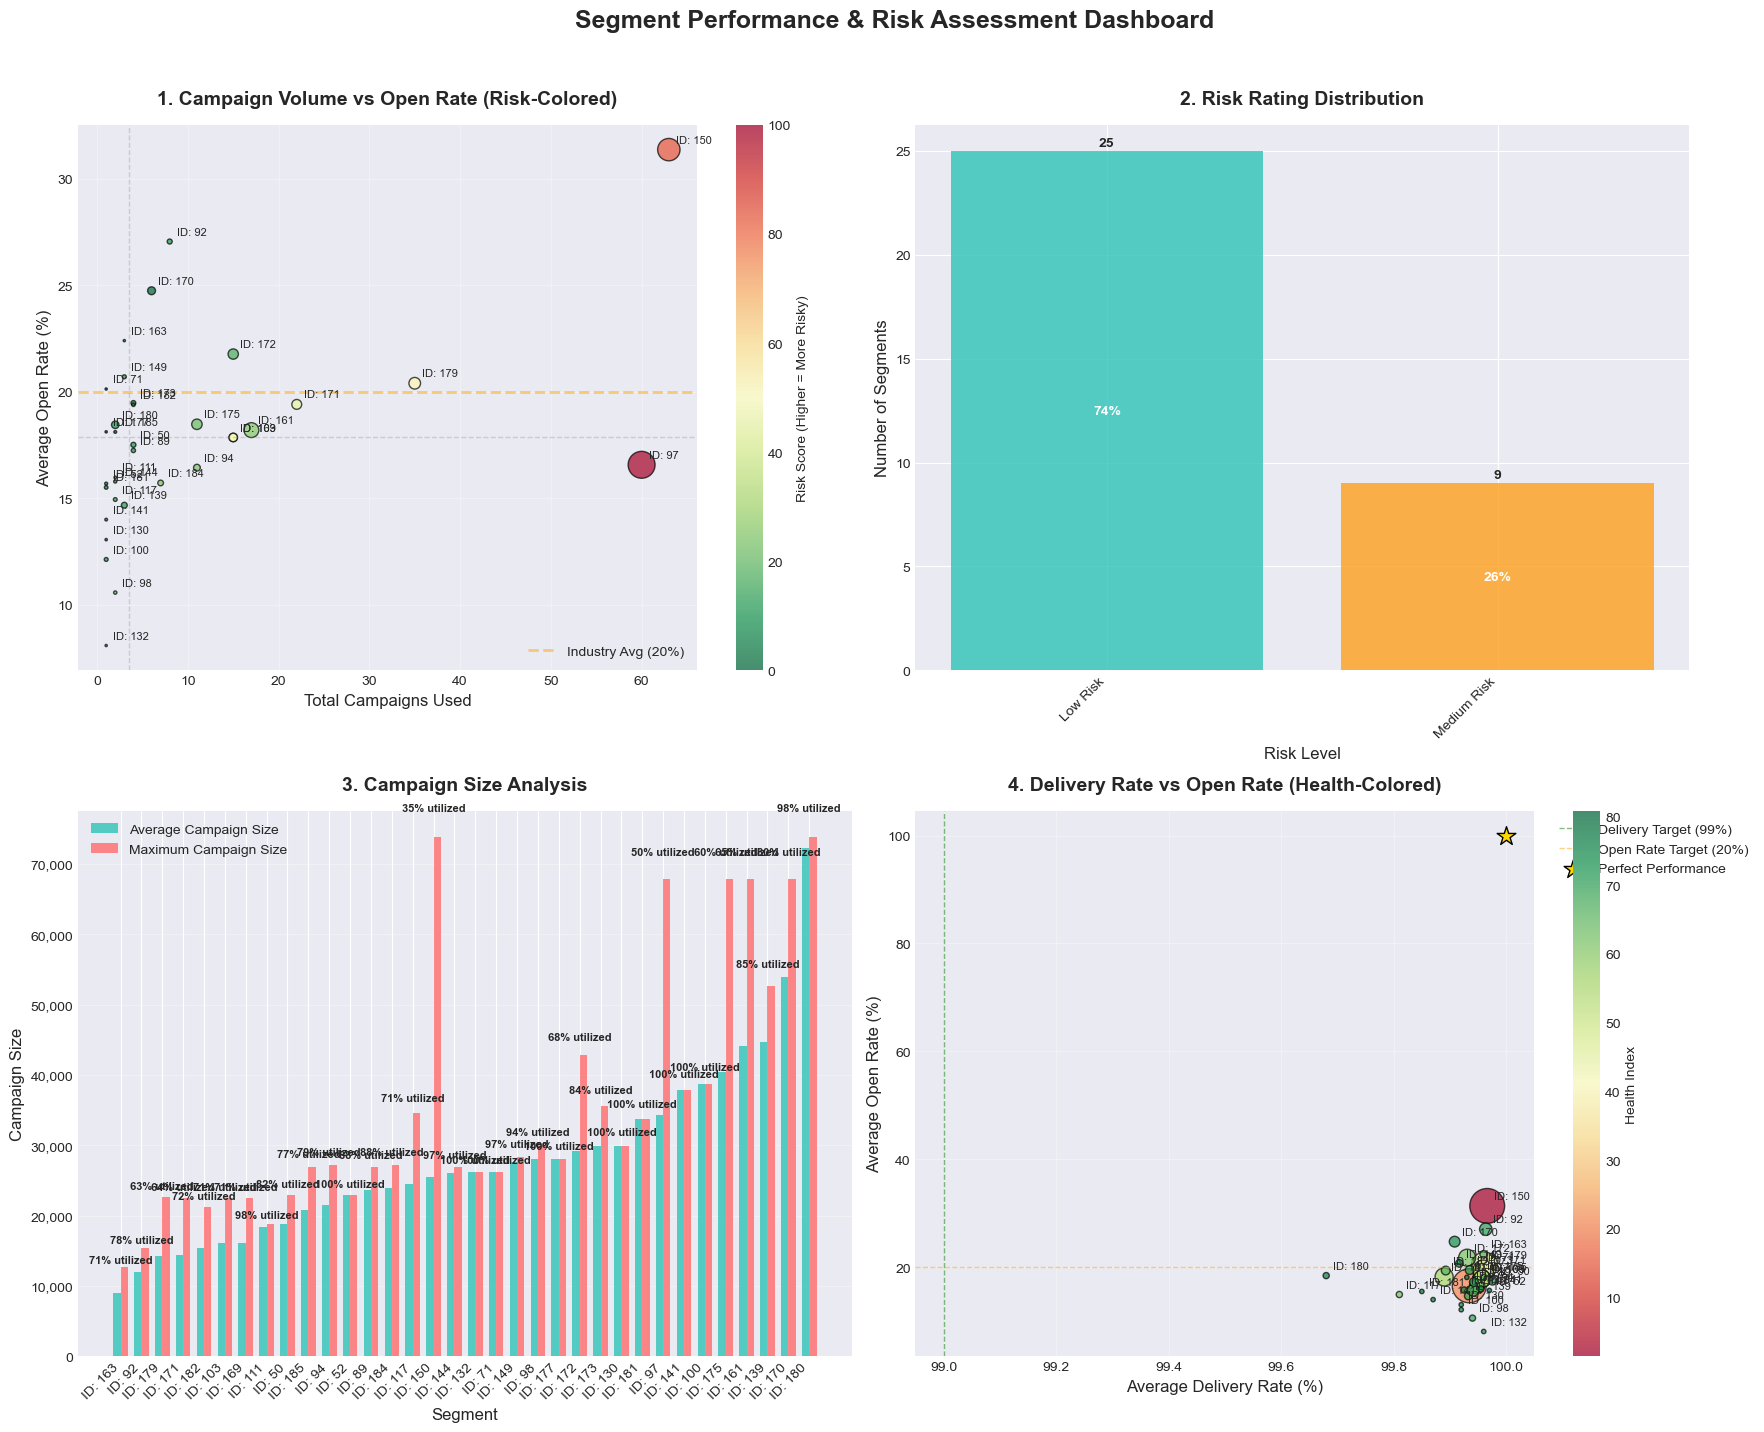

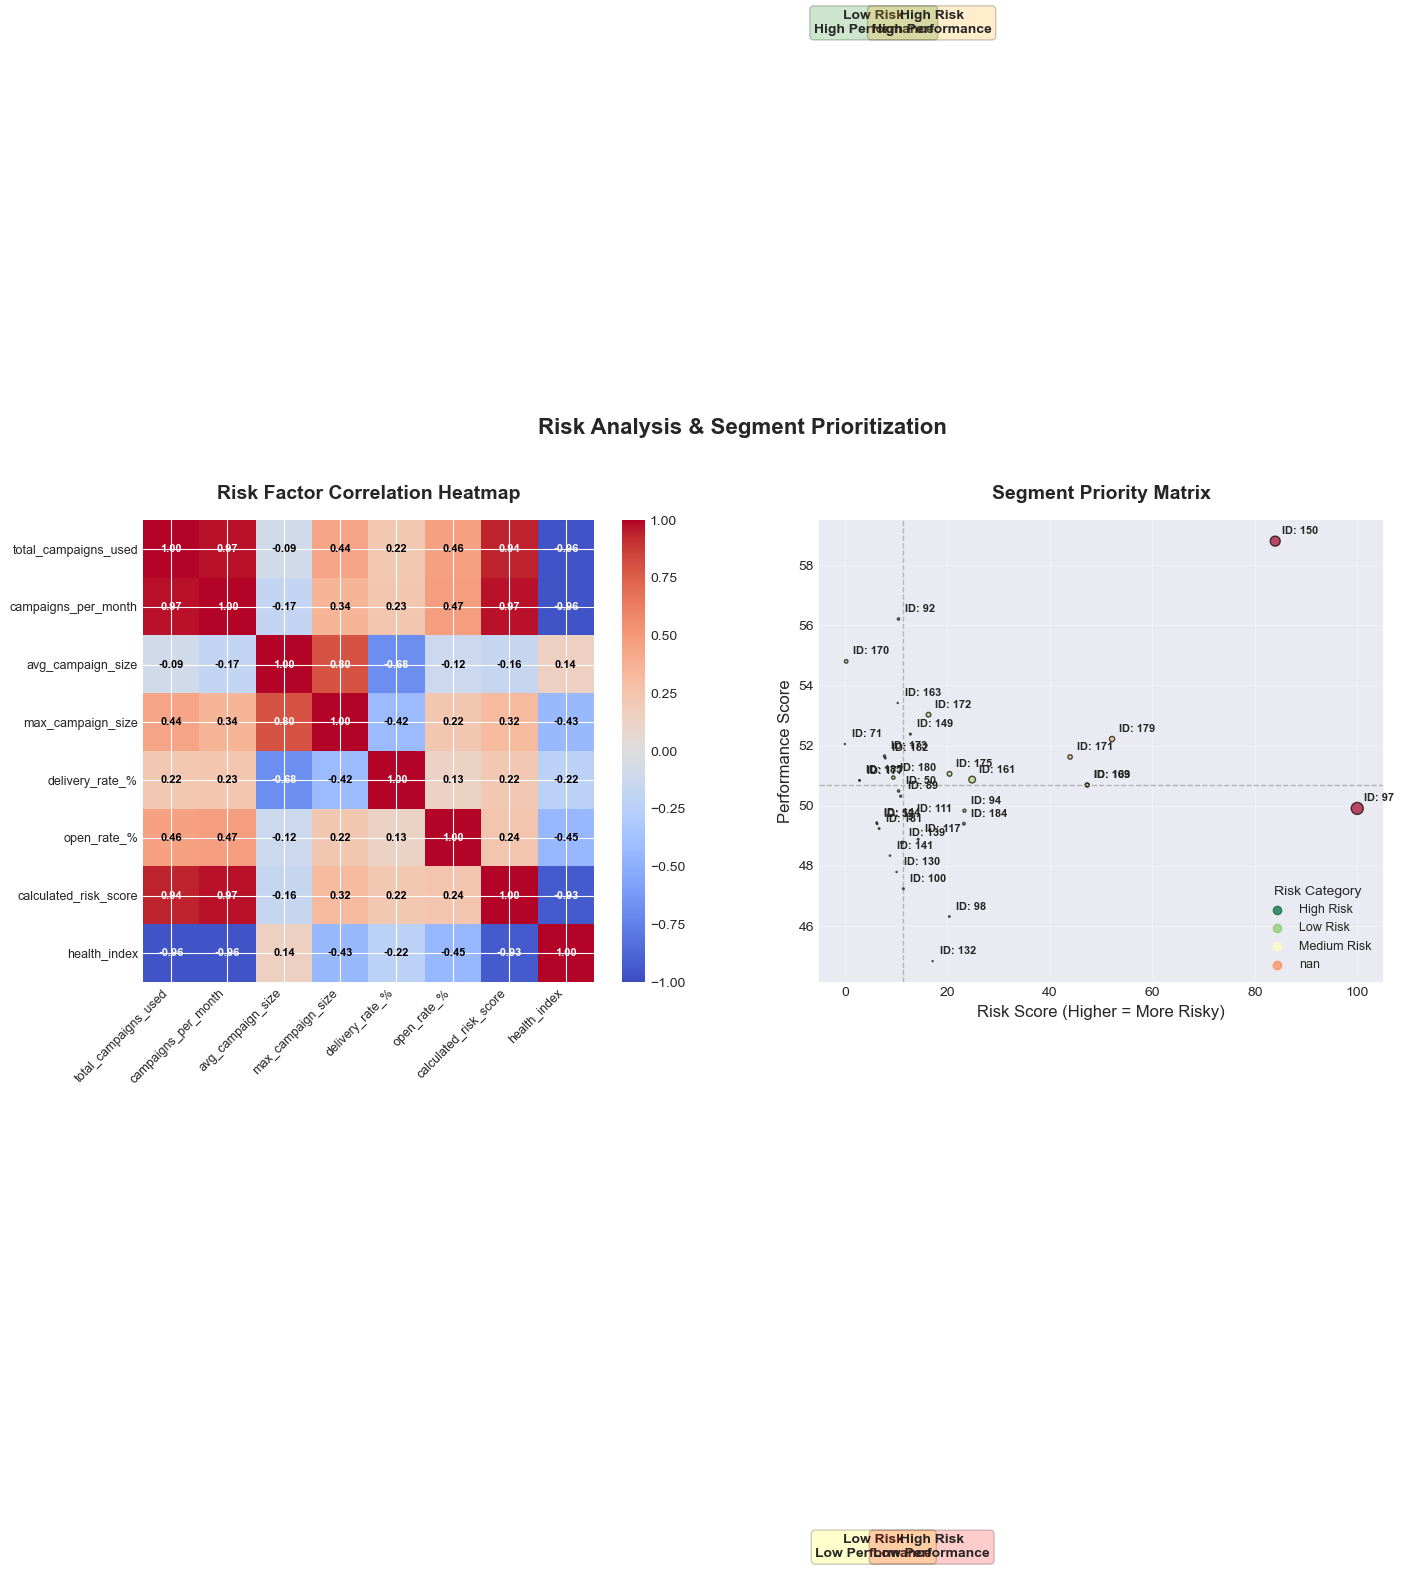


PERFORMANCE & RISK ASSESSMENT INSIGHTS

📊 PERFORMANCE SUMMARY:
   • Average Delivery Rate: 99.93%
   • Average Open Rate: 17.87%
   • Segments Above Industry Open Rate (20%): 8/34
   • Segments with High Delivery (≥99%): 34/34

⚠️  RISK ASSESSMENT:
   • Average Risk Score: 20.4/100
   • Health Index Average: 65.4/100
   • Low Risk: 25 segments (74%)
   • Medium Risk: 9 segments (26%)

🏆 TOP PERFORMERS:
   • Highest Open Rate: ID 150 (5 days recent engagement) - 31.36%
   • Highest Volume: ID 97 - 3,765,580 total sends
   • Most Campaigns: ID 150 - 63 campaigns

⚠️  AREAS OF CONCERN:
   1. LOW OPEN RATES: 26 segments below industry average:
      • ID 97: 16.56% (needs +3.44%)
      • ID 161: 18.19% (needs +1.81%)
      • ID 175: 18.46% (needs +1.54%)
      • ID 171: 19.40% (needs +0.60%)
      • ID 103: 17.85% (needs +2.15%)
      • ID 169: 17.85% (needs +2.15%)
      • ID 180: 18.44% (needs +1.56%)
      • ID 94: 16.43% (needs +3.57%)
      • ID 139: 14.67% (needs +5.33%)
      • ID 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_performance_risk(df):
    """
    Comprehensive segment performance and risk assessment analysis
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns:
        - segment_id, segment_name, segment_folder
        - total_campaigns_used, active_months, total_sent_volume
        - avg_campaign_size, max_campaign_size, estimated_segment_size
        - avg_delivery_pct, avg_open_pct, risk_rating
    """
    
    print("=" * 100)
    print("SEGMENT PERFORMANCE & RISK ASSESSMENT ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert to numeric where possible
    numeric_cols = ['total_campaigns_used', 'active_months', 'total_sent_volume',
                   'avg_campaign_size', 'max_campaign_size', 'avg_delivery_pct', 'avg_open_pct']
    
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Convert percentages to actual percentages
    df_analysis['delivery_rate_%'] = df_analysis['avg_delivery_pct'] * 100
    df_analysis['open_rate_%'] = df_analysis['avg_open_pct'] * 100
    
    # Calculate additional metrics
    df_analysis['campaigns_per_month'] = df_analysis['total_campaigns_used'] / df_analysis['active_months']
    df_analysis['volume_per_campaign'] = df_analysis['total_sent_volume'] / df_analysis['total_campaigns_used']
    
    # Calculate size utilization
    df_analysis['size_utilization'] = (df_analysis['avg_campaign_size'] / df_analysis['max_campaign_size']) * 100
    
    # Calculate performance score
    df_analysis['performance_score'] = (
        df_analysis['delivery_rate_%'] * 0.4 +
        df_analysis['open_rate_%'] * 0.6
    )
    
    # Calculate consistency score (lower variability = higher score)
    df_analysis['consistency_score'] = 100 - (df_analysis['max_campaign_size'] - df_analysis['avg_campaign_size']) / df_analysis['avg_campaign_size'] * 100
    
    # Calculate risk score based on metrics
    df_analysis['calculated_risk_score'] = (
        (100 - df_analysis['delivery_rate_%']) * 30 +  # Lower delivery = higher risk
        (100 - df_analysis['open_rate_%']) * 40 +      # Lower open rate = higher risk
        (df_analysis['campaigns_per_month'] / df_analysis['campaigns_per_month'].max() * 100) * 30  # Higher frequency = higher fatigue risk
    )
    
    # Normalize risk score to 0-100
    df_analysis['calculated_risk_score'] = (df_analysis['calculated_risk_score'] - df_analysis['calculated_risk_score'].min()) / (df_analysis['calculated_risk_score'].max() - df_analysis['calculated_risk_score'].min()) * 100
    
    # Categorize calculated risk
    df_analysis['calculated_risk_category'] = pd.cut(
        df_analysis['calculated_risk_score'],
        bins=[0, 30, 70, 100],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )
    
    # Calculate segment efficiency
    df_analysis['efficiency_score'] = (df_analysis['open_rate_%'] * df_analysis['total_campaigns_used']) / 1000
    
    # Calculate segment health index
    df_analysis['health_index'] = (
        df_analysis['performance_score'] * 0.4 +
        df_analysis['consistency_score'] * 0.3 +
        (100 - df_analysis['calculated_risk_score']) * 0.3
    )
    
    # Basic statistics
    total_segments = len(df_analysis)
    total_campaigns = df_analysis['total_campaigns_used'].sum()
    total_volume = df_analysis['total_sent_volume'].sum()
    avg_campaigns_per_segment = df_analysis['total_campaigns_used'].mean()
    avg_volume_per_segment = df_analysis['total_sent_volume'].mean()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Total Campaigns Analyzed: {total_campaigns:,.0f}")
    print(f"   • Total Sent Volume: {total_volume:,.0f}")
    print(f"   • Average Campaigns per Segment: {avg_campaigns_per_segment:.1f}")
    print(f"   • Average Volume per Segment: {avg_volume_per_segment:,.0f}")
    print(f"   • Average Delivery Rate: {df_analysis['delivery_rate_%'].mean():.2f}%")
    print(f"   • Average Open Rate: {df_analysis['open_rate_%'].mean():.2f}%")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Performance & Risk Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Performance & Risk Assessment Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Volume vs Performance Bubble Chart (Top-left)
    ax1 = axes1[0, 0]
    
    # Create bubble chart
    scatter1 = ax1.scatter(df_analysis['total_campaigns_used'], df_analysis['open_rate_%'],
                          s=df_analysis['total_sent_volume'] / 10000,  # Bubble size = total volume
                          c=df_analysis['calculated_risk_score'],      # Color = risk score
                          cmap='RdYlGn_r',  # Red for high risk, green for low risk
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax1.annotate(f"ID: {row['segment_id']}", 
                    (row['total_campaigns_used'], row['open_rate_%']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax1.set_title('1. Campaign Volume vs Open Rate (Risk-Colored)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Total Campaigns Used', fontsize=12)
    ax1.set_ylabel('Average Open Rate (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add industry benchmark line
    industry_avg_open = 20
    ax1.axhline(y=industry_avg_open, color='orange', linestyle='--', alpha=0.5, 
               linewidth=2, label=f'Industry Avg ({industry_avg_open}%)')
    
    # Add quadrant lines
    median_campaigns = df_analysis['total_campaigns_used'].median()
    median_open = df_analysis['open_rate_%'].median()
    
    ax1.axhline(y=median_open, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axvline(x=median_campaigns, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Add colorbar
    plt.colorbar(scatter1, ax=ax1, label='Risk Score (Higher = More Risky)')
    ax1.legend()
    
    # 1.2 Risk Rating Distribution (Top-right)
    ax2 = axes1[0, 1]
    
    # Extract base risk category
    if 'risk_rating' in df_analysis.columns:
        # Extract the risk level from the rating string
        df_analysis['risk_level'] = df_analysis['risk_rating'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else 'Unknown')
        risk_counts = df_analysis['risk_level'].value_counts()
        
        # Create color mapping
        risk_colors = {'Low Risk': '#2EC4B6', 'Medium Risk': '#FF9F1C', 
                      'High Risk': '#FF6B6B', 'Unknown': '#95E1D3'}
        
        colors2 = [risk_colors.get(risk, '#95E1D3') for risk in risk_counts.index]
        
        bars2 = ax2.bar(range(len(risk_counts)), risk_counts.values, color=colors2, alpha=0.8)
        
        ax2.set_title('2. Risk Rating Distribution', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Risk Level', fontsize=12)
        ax2.set_ylabel('Number of Segments', fontsize=12)
        ax2.set_xticks(range(len(risk_counts)))
        ax2.set_xticklabels(risk_counts.index, rotation=45, ha='right')
        
        # Add value labels
        for bar, count in zip(bars2, risk_counts.values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Add percentage labels
        total = len(df_analysis)
        for i, (bar, count) in enumerate(zip(bars2, risk_counts.values)):
            percentage = (count / total) * 100
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                    f'{percentage:.0f}%', ha='center', va='center', 
                    fontweight='bold', color='white')
    else:
        ax2.text(0.5, 0.5, 'No risk rating data available',
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('2. Risk Rating Distribution', fontsize=14, fontweight='bold', pad=15)
    
    # 1.3 Campaign Size Analysis (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Prepare data for grouped bar chart
    x_pos = np.arange(len(df_analysis))
    width = 0.35
    
    # Sort by avg campaign size for better visualization
    size_data = df_analysis.sort_values('avg_campaign_size', ascending=True)
    
    bars3_avg = ax3.bar(x_pos - width/2, size_data['avg_campaign_size'], width,
                       label='Average Campaign Size', color='#2EC4B6', alpha=0.8)
    bars3_max = ax3.bar(x_pos + width/2, size_data['max_campaign_size'], width,
                       label='Maximum Campaign Size', color='#FF6B6B', alpha=0.8)
    
    ax3.set_title('3. Campaign Size Analysis', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Campaign Size', fontsize=12)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"ID: {id}" for id in size_data['segment_id']], rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Format y-axis with thousands separator
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add utilization percentage labels
    for i, (_, row) in enumerate(size_data.iterrows()):
        utilization = row['size_utilization']
        ax3.text(i, max(row['avg_campaign_size'], row['max_campaign_size']) * 1.05,
                f'{utilization:.0f}% utilized', ha='center', fontsize=8, fontweight='bold')
    
    # 1.4 Delivery vs Open Rate Performance (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Create scatter plot
    scatter4 = ax4.scatter(df_analysis['delivery_rate_%'], df_analysis['open_rate_%'],
                          s=df_analysis['total_campaigns_used'] * 10,
                          c=df_analysis['health_index'],
                          cmap='RdYlGn',
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        ax4.annotate(f"ID: {row['segment_id']}", 
                    (row['delivery_rate_%'], row['open_rate_%']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax4.set_title('4. Delivery Rate vs Open Rate (Health-Colored)', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Average Delivery Rate (%)', fontsize=12)
    ax4.set_ylabel('Average Open Rate (%)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add delivery benchmark line
    delivery_benchmark = 99
    ax4.axvline(x=delivery_benchmark, color='green', linestyle='--', alpha=0.5, 
               linewidth=1, label=f'Delivery Target ({delivery_benchmark}%)')
    
    # Add open rate benchmark line
    ax4.axhline(y=industry_avg_open, color='orange', linestyle='--', alpha=0.5,
               linewidth=1, label=f'Open Rate Target ({industry_avg_open}%)')
    
    # Add perfect performance point
    ax4.scatter([100], [100], color='gold', s=200, marker='*', 
               label='Perfect Performance', edgecolors='black', linewidth=1)
    
    # Add colorbar
    plt.colorbar(scatter4, ax=ax4, label='Health Index')
    ax4.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Risk Heatmap & Priority Matrix
    # ============================================
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('Risk Analysis & Segment Prioritization', fontsize=16, fontweight='bold', y=1.05)
    
    # 2.1 Risk Factor Correlation Heatmap
    ax5 = axes2[0]
    
    # Calculate correlation matrix for risk factors
    risk_factors = ['total_campaigns_used', 'campaigns_per_month', 
                   'avg_campaign_size', 'max_campaign_size',
                   'delivery_rate_%', 'open_rate_%', 
                   'calculated_risk_score', 'health_index']
    
    # Filter to only include columns that exist
    existing_factors = [factor for factor in risk_factors if factor in df_analysis.columns]
    corr_matrix = df_analysis[existing_factors].corr()
    
    # Create heatmap
    im = ax5.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    
    ax5.set_title('Risk Factor Correlation Heatmap', fontsize=14, fontweight='bold', pad=15)
    ax5.set_xticks(np.arange(len(corr_matrix.columns)))
    ax5.set_yticks(np.arange(len(corr_matrix.columns)))
    ax5.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=9)
    ax5.set_yticklabels(corr_matrix.columns, fontsize=9)
    
    # Add correlation values
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            ax5.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha='center', va='center', 
                    color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                    fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax5)
    
    # 2.2 Priority Matrix: Risk vs Performance
    ax6 = axes2[1]
    
    # Create priority matrix
    scatter6 = ax6.scatter(df_analysis['calculated_risk_score'], df_analysis['performance_score'],
                          s=df_analysis['total_sent_volume'] / 50000,
                          c=pd.Categorical(df_analysis['calculated_risk_category']).codes,
                          cmap='RdYlGn_r',
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=1)
    
    # Add segment labels
    for _, row in df_analysis.iterrows():
        # Only label high-priority segments
        if row['calculated_risk_score'] > 50 or row['performance_score'] < 60:
            ax6.annotate(f"ID: {row['segment_id']}", 
                        (row['calculated_risk_score'], row['performance_score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, fontweight='bold')
    
    ax6.set_title('Segment Priority Matrix', fontsize=14, fontweight='bold', pad=15)
    ax6.set_xlabel('Risk Score (Higher = More Risky)', fontsize=12)
    ax6.set_ylabel('Performance Score', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # Add quadrant lines
    median_risk = df_analysis['calculated_risk_score'].median()
    median_performance = df_analysis['performance_score'].median()
    
    ax6.axhline(y=median_performance, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax6.axvline(x=median_risk, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add quadrant labels
    ax6.text(median_risk/2, median_performance*1.5, 'Low Risk\nHigh Performance', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
    ax6.text(median_risk*1.5, median_performance*1.5, 'High Risk\nHigh Performance', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.2))
    ax6.text(median_risk/2, median_performance/2, 'Low Risk\nLow Performance', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
    ax6.text(median_risk*1.5, median_performance/2, 'High Risk\nLow Performance', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
    # Create custom legend for risk categories
    if 'calculated_risk_category' in df_analysis.columns:
        unique_categories = df_analysis['calculated_risk_category'].unique()
        for i, category in enumerate(unique_categories):
            ax6.scatter([], [], color=plt.cm.RdYlGn_r(i/len(unique_categories)), 
                       label=str(category), alpha=0.7)
        ax6.legend(title='Risk Category', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("PERFORMANCE & RISK ASSESSMENT INSIGHTS")
    print("=" * 100)
    
    # Calculate key metrics
    avg_delivery = df_analysis['delivery_rate_%'].mean()
    avg_open = df_analysis['open_rate_%'].mean()
    avg_risk = df_analysis['calculated_risk_score'].mean()
    avg_health = df_analysis['health_index'].mean()
    
    # Identify best and worst performers
    best_open_segment = df_analysis.loc[df_analysis['open_rate_%'].idxmax()]
    worst_open_segment = df_analysis.loc[df_analysis['open_rate_%'].idxmin()]
    highest_risk_segment = df_analysis.loc[df_analysis['calculated_risk_score'].idxmax()]
    highest_volume_segment = df_analysis.loc[df_analysis['total_sent_volume'].idxmax()]
    
    # Calculate performance benchmarks
    segments_above_industry_open = len(df_analysis[df_analysis['open_rate_%'] >= industry_avg_open])
    segments_high_delivery = len(df_analysis[df_analysis['delivery_rate_%'] >= 99])
    
    # Analyze risk distribution
    if 'calculated_risk_category' in df_analysis.columns:
        high_risk_segments = df_analysis[df_analysis['calculated_risk_category'] == 'High Risk']
        medium_risk_segments = df_analysis[df_analysis['calculated_risk_category'] == 'Medium Risk']
        low_risk_segments = df_analysis[df_analysis['calculated_risk_category'] == 'Low Risk']
    else:
        high_risk_segments = pd.DataFrame()
        medium_risk_segments = pd.DataFrame()
        low_risk_segments = pd.DataFrame()
    
    # Calculate consistency metrics
    low_consistency_segments = df_analysis[df_analysis['consistency_score'] < 70]
    high_utilization_segments = df_analysis[df_analysis['size_utilization'] > 80]
    
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print(f"   • Average Delivery Rate: {avg_delivery:.2f}%")
    print(f"   • Average Open Rate: {avg_open:.2f}%")
    print(f"   • Segments Above Industry Open Rate ({industry_avg_open}%): {segments_above_industry_open}/{total_segments}")
    print(f"   • Segments with High Delivery (≥99%): {segments_high_delivery}/{total_segments}")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    print(f"   • Average Risk Score: {avg_risk:.1f}/100")
    print(f"   • Health Index Average: {avg_health:.1f}/100")
    
    if 'risk_rating' in df_analysis.columns:
        risk_summary = df_analysis['risk_level'].value_counts()
        for risk_level, count in risk_summary.items():
            percentage = (count / total_segments) * 100
            print(f"   • {risk_level}: {count} segments ({percentage:.0f}%)")
    
    print(f"\n🏆 TOP PERFORMERS:")
    print(f"   • Highest Open Rate: ID {best_open_segment['segment_id']} ({best_open_segment['segment_name']}) - {best_open_segment['open_rate_%']:.2f}%")
    print(f"   • Highest Volume: ID {highest_volume_segment['segment_id']} - {highest_volume_segment['total_sent_volume']:,.0f} total sends")
    print(f"   • Most Campaigns: ID {best_open_segment['segment_id']} - {best_open_segment['total_campaigns_used']} campaigns")
    
    print(f"\n⚠️  AREAS OF CONCERN:")
    
    # Concern 1: Low open rates
    low_open_segments = df_analysis[df_analysis['open_rate_%'] < industry_avg_open]
    if len(low_open_segments) > 0:
        print(f"   1. LOW OPEN RATES: {len(low_open_segments)} segments below industry average:")
        for _, row in low_open_segments.iterrows():
            gap = industry_avg_open - row['open_rate_%']
            print(f"      • ID {row['segment_id']}: {row['open_rate_%']:.2f}% (needs +{gap:.2f}%)")
    
    # Concern 2: High risk segments
    if len(high_risk_segments) > 0:
        print(f"   2. HIGH RISK SEGMENTS: {len(high_risk_segments)} segments with elevated risk:")
        for _, row in high_risk_segments.iterrows():
            print(f"      • ID {row['segment_id']}: Risk score {row['calculated_risk_score']:.1f}/100")
    
    # Concern 3: Low consistency
    if len(low_consistency_segments) > 0:
        print(f"   3. LOW CONSISTENCY: {len(low_consistency_segments)} segments with high campaign size variability:")
        for _, row in low_consistency_segments.iterrows():
            print(f"      • ID {row['segment_id']}: Consistency score {row['consistency_score']:.1f}/100")
    
    # Concern 4: High utilization
    if len(high_utilization_segments) > 0:
        print(f"   4. HIGH UTILIZATION: {len(high_utilization_segments)} segments using >80% of max capacity:")
        for _, row in high_utilization_segments.iterrows():
            print(f"      • ID {row['segment_id']}: {row['size_utilization']:.0f}% utilization")
    
    print(f"\n🔍 INVESTIGATION PRIORITIES:")
    
    # Priority 1: High risk, low performance segments
    high_risk_low_perf = df_analysis[
        (df_analysis['calculated_risk_score'] > df_analysis['calculated_risk_score'].median()) &
        (df_analysis['performance_score'] < df_analysis['performance_score'].median())
    ]
    if len(high_risk_low_perf) > 0:
        print(f"   1. HIGH PRIORITY - HIGH RISK, LOW PERFORMANCE:")
        for _, row in high_risk_low_perf.iterrows():
            print(f"      • ID {row['segment_id']}: Risk {row['calculated_risk_score']:.1f}, Performance {row['performance_score']:.1f}")
    
    # Priority 2: High volume with issues
    high_volume_with_issues = df_analysis[
        (df_analysis['total_sent_volume'] > df_analysis['total_sent_volume'].median()) &
        (df_analysis['open_rate_%'] < industry_avg_open)
    ]
    if len(high_volume_with_issues) > 0:
        print(f"   2. HIGH VOLUME WITH PERFORMANCE ISSUES:")
        for _, row in high_volume_with_issues.iterrows():
            print(f"      • ID {row['segment_id']}: {row['total_sent_volume']:,.0f} sends, only {row['open_rate_%']:.2f}% open rate")
    
    # Priority 3: High campaign frequency
    high_frequency_segments = df_analysis[df_analysis['campaigns_per_month'] > df_analysis['campaigns_per_month'].quantile(0.75)]
    if len(high_frequency_segments) > 0:
        print(f"   3. HIGH CAMPAIGN FREQUENCY (Potential Fatigue Risk):")
        for _, row in high_frequency_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: {row['campaigns_per_month']:.1f} campaigns/month")
    
    print(f"\n📋 STRATEGIC RECOMMENDATIONS:")
    
    # Recommendation 1: Risk mitigation
    print(f"   1. RISK MITIGATION STRATEGIES:")
    if len(high_risk_segments) > 0:
        high_risk_ids = high_risk_segments['segment_id'].tolist()
        print(f"      • Implement monitoring for high-risk segments: {', '.join([str(id) for id in high_risk_ids])}")
    
    # Recommendation 2: Performance optimization
    print(f"   2. PERFORMANCE OPTIMIZATION:")
    if len(low_open_segments) > 0:
        print(f"      • Focus on improving open rates for {len(low_open_segments)} underperforming segments")
        print(f"      • Test different messaging strategies for segments below {industry_avg_open}% open rate")
    
    # Recommendation 3: Campaign strategy
    print(f"   3. CAMPAIGN STRATEGY ADJUSTMENTS:")
    
    # For segments with high utilization
    if len(high_utilization_segments) > 0:
        print(f"      • Consider segment expansion for high-utilization segments (>80%)")
    
    # For segments with high frequency
    if len(high_frequency_segments) > 0:
        print(f"      • Review campaign frequency to prevent audience fatigue")
    
    # Recommendation 4: Resource allocation
    print(f"   4. RESOURCE ALLOCATION:")
    
    high_efficiency_segments = df_analysis[df_analysis['efficiency_score'] > df_analysis['efficiency_score'].median()]
    if len(high_efficiency_segments) > 0:
        print(f"      • Allocate more resources to high-efficiency segments")
    
    # Recommendation 5: Monitoring & alerts
    print(f"   5. MONITORING & ALERTS:")
    print(f"      • Set up alerts for segments with risk score >70")
    print(f"      • Monitor delivery rates dropping below 99%")
    print(f"      • Track open rate trends weekly")
    
    print(f"\n" + "=" * 100)
    print("DETAILED SEGMENT ANALYSIS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'total_campaigns_used',
                   'total_sent_volume', 'avg_campaign_size', 'max_campaign_size',
                   'delivery_rate_%', 'open_rate_%', 'campaigns_per_month',
                   'calculated_risk_score', 'health_index', 'size_utilization']
    
    if 'risk_rating' in df_analysis.columns:
        summary_cols.append('risk_level')
    
    summary_df = df_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['total_sent_volume'] = summary_df['total_sent_volume'].apply(format_number)
    summary_df['avg_campaign_size'] = summary_df['avg_campaign_size'].apply(format_number)
    summary_df['max_campaign_size'] = summary_df['max_campaign_size'].apply(format_number)
    summary_df['delivery_rate_%'] = summary_df['delivery_rate_%'].apply(lambda x: f"{x:.2f}%")
    summary_df['open_rate_%'] = summary_df['open_rate_%'].apply(lambda x: f"{x:.2f}%")
    summary_df['campaigns_per_month'] = summary_df['campaigns_per_month'].apply(lambda x: f"{x:.1f}")
    summary_df['calculated_risk_score'] = summary_df['calculated_risk_score'].apply(lambda x: f"{x:.1f}/100")
    summary_df['health_index'] = summary_df['health_index'].apply(lambda x: f"{x:.1f}/100")
    summary_df['size_utilization'] = summary_df['size_utilization'].apply(lambda x: f"{x:.0f}%")
    
    # Sort by health index (descending)
    summary_df = summary_df.sort_values('health_index', 
                                       key=lambda x: x.str.replace('/100', '').astype(float),
                                       ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{total_segments}",
        'Total Campaigns': f"{total_campaigns:,.0f}",
        'Total Sent Volume': f"{total_volume:,.0f}",
        'Average Delivery Rate': f"{avg_delivery:.2f}%",
        'Average Open Rate': f"{avg_open:.2f}%",
        'Average Risk Score': f"{avg_risk:.1f}/100",
        'Average Health Index': f"{avg_health:.1f}/100",
        'Segments Above Industry Open Rate': f"{segments_above_industry_open}",
        'Segments with High Delivery': f"{segments_high_delivery}",
        'Average Campaigns per Month': f"{df_analysis['campaigns_per_month'].mean():.1f}"
    }
    
    if 'risk_level' in df_analysis.columns:
        for risk_level in ['High Risk', 'Medium Risk', 'Low Risk']:
            count = len(df_analysis[df_analysis['risk_level'] == risk_level])
            if count > 0:
                metrics[f'Segments with {risk_level}'] = f"{count}"
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("RISK ASSESSMENT METHODOLOGY")
    print("=" * 100)
    
    print(f"\n📊 RISK CALCULATION FORMULA:")
    print(f"   Risk Score = (Delivery Risk + Open Rate Risk + Frequency Risk)")
    print(f"   • Delivery Risk: (100 - Delivery Rate %) × 30")
    print(f"   • Open Rate Risk: (100 - Open Rate %) × 40")
    print(f"   • Frequency Risk: (Campaigns/Month ÷ Max Campaigns/Month) × 100 × 30")
    print(f"   • Final Score: Normalized to 0-100 scale")
    
    print(f"\n🎯 PERFORMANCE THRESHOLDS:")
    print(f"   • Delivery Rate: ≥99% (Excellent)")
    print(f"   • Open Rate: ≥{industry_avg_open}% (Industry Average)")
    print(f"   • Size Utilization: <80% (Optimal)")
    print(f"   • Campaigns per Month: <15 (to avoid fatigue)")
    
    print(f"\n⚠️  RISK CATEGORIES:")
    print(f"   • Low Risk: Score 0-30")
    print(f"   • Medium Risk: Score 31-70")
    print(f"   • High Risk: Score 71-100")
    
    print(f"\n📈 SEGMENT HEALTH INDEX:")
    print(f"   • 40% Performance Score (Delivery + Open Rates)")
    print(f"   • 30% Consistency Score (Campaign size stability)")
    print(f"   • 30% Risk Mitigation (100 - Risk Score)")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Run the analysis
analyze_segment_performance_risk(df)